## Setup Proyek dan Impor Library

In [1]:
# ==============================================================================
# SETUP DAN IMPOR LIBRARY
# ==============================================================================
# Library inti
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2  # OpenCV
from PIL import Image
from tqdm.auto import tqdm
import time
from sklearn.calibration import calibration_curve

# --- Library untuk Feature Engineering (Total 5 Fitur) ---
from skimage.feature import graycomatrix, graycoprops, hog, local_binary_pattern
from scipy.stats import skew, kurtosis
from imblearn.over_sampling import SMOTE

# --- Library untuk Machine Learning Klasik ---
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils import class_weight

# --- Library untuk Penanganan Ketidakseimbangan ---
# Jika Anda belum punya, jalankan: pip install imbalanced-learn
try:
    from imblearn.over_sampling import SMOTE
except ImportError:
    print("WARNING: Modul 'imbalanced-learn' tidak ditemukan. SMOTE (Metode B) akan gagal.")
    print("Silakan instal dengan: pip install imbalanced-learn")

# 5 Model Klasik
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# --- Konfigurasi Global ---
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 7) # Ukuran plot lebih besar
plt.style.use("fivethirtyeight")
plt.rcParams['figure.dpi'] = 100

print(f"✅ Library lengkap (termasuk imbalanced-learn) berhasil diimpor.")

✅ Library lengkap (termasuk imbalanced-learn) berhasil diimpor.


## EDA

✅ GroundTruth file loaded successfully. 11 classes detected.

--- CLASS DISTRIBUTION ANALYSIS (IMBALANCE ISSUE) ---
| Class   |   Count |   Percentage (%) |
|:--------|--------:|-----------------:|
| BCC     | 2522.00 |            48.13 |
| NV      |  746.00 |            14.24 |
| BKL     |  544.00 |            10.38 |
| SCCKA   |  473.00 |             9.03 |
| MEL     |  450.00 |             8.59 |
| AKIEC   |  303.00 |             5.78 |
| DF      |   52.00 |             0.99 |
| INF     |   50.00 |             0.95 |
| VASC    |   47.00 |             0.90 |
| BEN_OTH |   44.00 |             0.84 |
| MAL_OTH |    9.00 |             0.17 |


/tmp/ipykernel_328458/4190211242.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


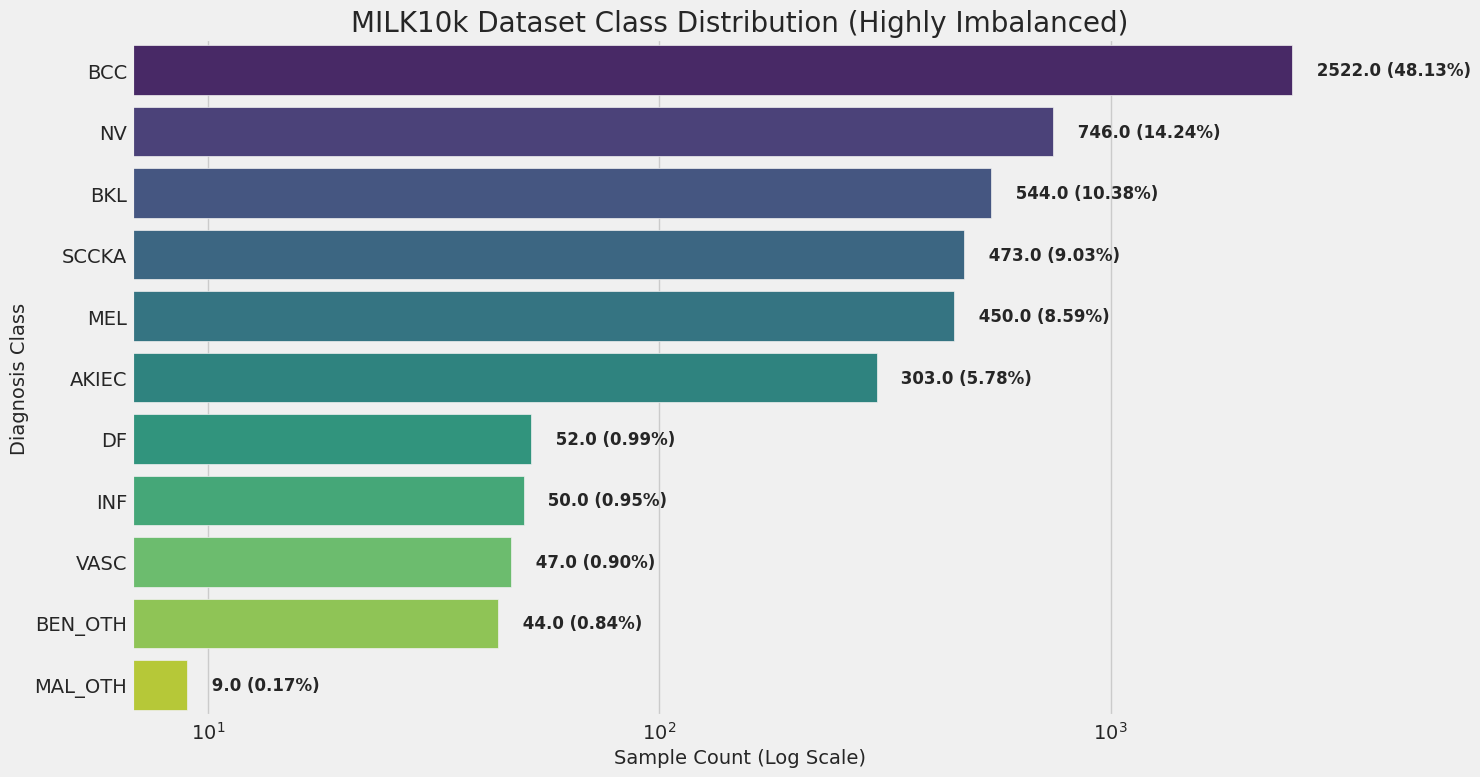

In [2]:
# ==============================================================================
# CELL 2: EDA - CLASS DISTRIBUTION ANALYSIS
# ==============================================================================
# This cell performs the initial Exploratory Data Analysis on the class labels

train_truth_path = "../dataset/MILK10k_Training_GroundTruth.csv"
train_meta_path = "../dataset/MILK10k_Training_Metadata.csv"

BASE_IMAGE_PATH = "../dataset/MILK10k_Training_Input"

try:
    df_train_truth = pd.read_csv(train_truth_path)
    DIAGNOSIS_COLUMNS = df_train_truth.columns.drop('lesion_id')
    NUM_CLASSES = len(DIAGNOSIS_COLUMNS)
    print(f"✅ GroundTruth file loaded successfully. {NUM_CLASSES} classes detected.")
    
    # --- Class Distribution Analysis ---
    class_counts = df_train_truth[DIAGNOSIS_COLUMNS].sum()
    class_percentage = (class_counts / len(df_train_truth)) * 100
    
    df_distribusi = pd.DataFrame({
        'Class': class_counts.index,
        'Count': class_counts.values,
        'Percentage (%)': class_percentage.values
    }).sort_values(by='Count', ascending=False)
    
    print("\n--- CLASS DISTRIBUTION ANALYSIS (IMBALANCE ISSUE) ---")
    print(df_distribusi.to_markdown(index=False, floatfmt=".2f"))
    
    # --- Class Distribution Visualization ---
    plt.figure(figsize=(15, 8))
    ax = sns.barplot(
        data=df_distribusi, 
        x='Count', 
        y='Class', 
        palette='viridis',
        orient='h'
    )
    plt.title("MILK10k Dataset Class Distribution (Highly Imbalanced)", fontsize=20)
    plt.xlabel("Sample Count (Log Scale)", fontsize=14)
    plt.ylabel("Diagnosis Class", fontsize=14)
    ax.set_xscale("log") # Use log scale due to extreme differences
    
    # Add labels
    for i, (count, pct) in enumerate(zip(df_distribusi['Count'], df_distribusi['Percentage (%)'])):
        ax.text(count * 1.1, i, f" {count} ({pct:.2f}%)", va='center', fontsize=12, fontweight='bold')
        
    plt.tight_layout()
    plt.show()

except FileNotFoundError as e:
    print(f"❌ ERROR: CSV file not found. Make sure '{train_truth_path}' is in the correct folder.")
    DIAGNOSIS_COLUMNS = []
    df_train_truth = pd.DataFrame()

## MEMUAT METADATA & SPLIT DATA

In [3]:
# ==============================================================================
# MEMUAT METADATA & SPLIT DATA
# ==============================================================================

try:
    df_train_meta = pd.read_csv(train_meta_path)
    print("✅ File Metadata berhasil dimuat.")

    # --- 3.1 Transformasi Data & Pembuatan Path Gambar ---
    def transform_to_wide_format(df_meta, image_base_path):
        df_meta['full_path'] = df_meta.apply(
            lambda row: os.path.join(image_base_path, row['lesion_id'], row['isic_id'] + '.jpg').replace("\\", "/"), axis=1
        )
        df_clinical = df_meta[df_meta['image_type'].str.contains('clinical')].add_prefix('clinical_')
        df_dermoscopic = df_meta[df_meta['image_type'].str.contains('dermoscopic')].add_prefix('dermoscopic_')
        df_clinical.rename(columns={'clinical_lesion_id': 'lesion_id'}, inplace=True)
        df_dermoscopic.rename(columns={'dermoscopic_lesion_id': 'lesion_id'}, inplace=True)
        df_wide = pd.merge(
            df_clinical[['lesion_id', 'clinical_full_path']],
            df_dermoscopic[['lesion_id', 'dermoscopic_full_path', 'dermoscopic_isic_id']],
            on='lesion_id'
        )
        df_wide.rename(columns={'dermoscopic_isic_id': 'isic_id'}, inplace=True)
        return df_wide

    df_train_wide = transform_to_wide_format(df_train_meta, BASE_IMAGE_PATH) # Gunakan path yang Anda tentukan
    df_train_processed = pd.merge(df_train_wide, df_train_truth, on='lesion_id')
    print("✅ Data transformed to wide-format.")

    # --- 3.2 Split Data (Stratified) ---
    # Stratified split WAJIB untuk data tidak seimbang
    y_stratify = df_train_processed[DIAGNOSIS_COLUMNS].idxmax(axis=1) # Dapatkan label kelas (string)
    
    train_df, val_df = train_test_split(
        df_train_processed, 
        test_size=0.2, 
        random_state=42, 
        stratify=y_stratify # Gunakan stratifikasi
    )
    print(f"✅ Data split (stratified) menjadi Train ({len(train_df)}) dan Validation ({len(val_df)}).")

except FileNotFoundError as e:
    print(f"❌ ERROR: File Metadata ('{train_meta_path}') tidak ditemukan.")
    train_df, val_df = pd.DataFrame(), pd.DataFrame()
except Exception as e:
    print(f"❌ ERROR saat memproses data: {e}")
    print("   -> Pastikan 'BASE_IMAGE_PATH' di SEL 2 sudah benar.")
    train_df, val_df = pd.DataFrame(), pd.DataFrame()

✅ File Metadata berhasil dimuat.
✅ Data transformed to wide-format.
✅ Data split (stratified) menjadi Train (4192) dan Validation (1048).


## ALUR KERJA A (MACHINE LEARNING KLASIK)

### Pipeline Pra-pemrosesan & Feature Engineering

**Pipeline Ekstraksi 5 Fitur**

Bertujuan untuk mengekstrak **lima set fitur numerik klasik** dari setiap gambar dalam *training set* dan *validation set*. Fitur-fitur ini tidak disimpan secara terpisah, melainkan **langsung digabungkan** menjadi satu matriks fitur (misalnya, (N\_sampel, 30)) untuk *langsung* dimasukkan ke dalam model Machine Learning (seperti SVC atau Random Forest).

Pendekatan ini menciptakan vektor fitur yang kaya yang menangkap informasi eksplisit mengenai **warna (RGB & HSV)**, **tekstur makro (GLCM)**, **tekstur mikro (LBP)**, dan **bentuk (HOG)**.

**Fitur yang Diekstrak (Total 30 Fitur):**

1.  **Fitur Warna (RGB):** Statistik orde 1-4 (Mean, Std Dev, Skewness, Kurtosis) dari setiap *channel* RGB. (12 fitur)
2.  **Fitur Tekstur (GLCM):** Properti statistik (Kontras, Korelasi, Energi, Homogenitas, ASM, Dissimilarity) dari GLCM, dirata-ratakan. (6 fitur)
3.  **Fitur Tekstur (HOG):** Statistik (Mean, Std Dev, Kurtosis) dari vektor *Histogram of Oriented Gradients*. (3 fitur)
4.  **Fitur Warna (HSV) (Baru):** Statistik (Mean, Std Dev) dari *channel* Hue, Saturation, dan Value. (6 fitur)
5.  **Fitur Tekstur (LBP) (Baru):** Statistik (Mean, Std Dev, Kurtosis) dari histogram *Local Binary Patterns*. (3 fitur)

**Proses:**

  * Setiap gambar dalam `train_df` dan `val_df` dibaca.
  * Gambar tersebut di-pra-pemrosesan (Resize + CLAHE).
  * Kelima fungsi (`ekstrak_fitur_...`) diterapkan pada gambar yang telah diproses.
  * Hasilnya digabungkan menjadi satu baris (vektor 30-dimensi) per gambar.

**Output:**

  * Dua matriks NumPy: `X_train_features` dan `X_val_features`.
  * Matriks ini kemudian **wajib** melalui `StandardScaler` (menjadi `X_train_scaled`) sebelum dimasukkan ke model ML di langkah berikutnya.

-----

**Justifikasi Pipeline Pra-pemrosesan & Penanganan Data**

Berdasarkan analisis EDA yang mengonfirmasi adanya **ketidakseimbangan kelas yang parah**, pipeline penanganan data lengkap dirancang untuk alur kerja **Machine Learning Klasik** (bukan Deep Learning).

-----

**1. Pengubahan Ukuran (*Resizing*) - Wajib**

  * **Justifikasi:** (Sama) Ukuran 600x450 terlalu besar. Ukuran **224x224** dipilih untuk menstandardisasi input sebelum ekstraksi fitur.
  * **Tindakan:** `muat_dan_praproses_gambar_klasik` menerapkan *resize* pada setiap gambar.

-----

**2. Peningkatan Kontras (*Contrast Enhancement*) - Wajib**

  * **Justifikasi:** (Sama) Menerapkan **CLAHE** akan menyeragamkan kontras dan membantu algoritma HOG dan LBP menangkap fitur bentuk/tekstur yang lebih konsisten.
  * **Tindakan:** `muat_dan_praproses_gambar_klasik` menerapkan `cv2.CLAHE` setelah *resize*.

-----

**3. Augmentasi Data (PERUBAHAN BESAR)**

  * **Justifikasi:** Augmentasi *on-the-fly* (seperti `Flip`, `ColorJitter`, `Dropout`) **secara sengaja DIHAPUS** dari pipeline pra-pemrosesan gambar.
  * **Alasan:** Menerapkan augmentasi acak akan *merusak* konsistensi fitur yang diekstrak (misalnya, HOG akan berubah jika gambar diputar; fitur Warna akan berubah jika `ColorJitter` diterapkan). Hal ini akan menghasilkan dataset fitur yang "kotor".
  * **Tindakan:** Masalah ketidakseimbangan data ditangani **SETELAH** fitur diekstrak, menggunakan dua metode:
    1.  **Metode A:** Pembobotan Kelas (`class_weight='balanced'`) saat melatih model ML.
    2.  **Metode B:** *Oversampling* di ruang fitur menggunakan **SMOTE** pada `X_train_scaled`.

-----

**4. Normalisasi Piksel (PERUBAHAN BESAR)**

  * **Justifikasi:** Normalisasi Z-score (mengubah piksel [0-255] menjadi [-2, 2]) **secara sengaja DIHAPUS**.
  * **Alasan:** Algoritma HOG, GLCM, dan LBP adalah algoritma pemrosesan gambar klasik yang dirancang untuk beroperasi pada rentang piksel [0-255] yang alami. Memberi mereka nilai negatif akan merusak perhitungan fitur.
  * **Tindakan:** Fitur diekstrak dari gambar [0-255] (yang telah di-CLAHE).

-----

**5. Scaling Fitur (LANGKAH BARU YANG WAJIB)**

  * **Justifikasi:** Sebagai *pengganti* Normalisasi Piksel, kita wajib melakukan **Scaling Fitur**. 30 fitur yang diekstrak memiliki rentang yang sangat berbeda (misal, `glcm_contrast` mungkin ribuan, sementara `glcm_correlation` antara 0-1). Model SVC dan Logistic Regression akan gagal jika fitur tidak di-scaling.
  * **Tindakan:** **`StandardScaler`** diterapkan pada `X_train_features` dan `X_val_features` *setelah* semua fitur diekstrak (SEL 5).

-----

**Ringkasan Implementasi Pipeline (Alur Kerja Klasik)**

Tabel berikut merangkum bagaimana alur kerja dalam kode 9-sel diimplementasikan.

| Langkah | Justifikasi | Implementasi dalam Kode (SEL 3-8) |
|:--- |:---|:---|
| **1. Resizing** | Input seragam 224x224. | `muat_dan_praproses_gambar_klasik` (SEL 4) |
| **2. CLAHE** | Meningkatkan kontras lokal untuk fitur yang lebih baik. | `muat_dan_praproses_gambar_klasik` (SEL 4) |
| **3. Feature Extraction** | Ekstrak 5 set fitur (HOG, GLCM, LBP, dll). | `ekstrak_fitur_...` (diterapkan pada gambar [0-255]) (SEL 4 & 5) |
| **4. Feature Scaling** | Menyamakan skala 30 fitur untuk model ML. | `StandardScaler` (diterapkan pada `X_train_features`) (SEL 5) |
| **5. Imbalance Handling** | Mencegah *overfitting* & mengatasi data tidak seimbang. | **Metode A:** `class_weight='balanced'` (SEL 7) <br> **Metode B:** `SMOTE` (pada `X_train_scaled`) (SEL 8) |

In [4]:
# ==============================================================================
# SEL 4: DEFINISI PRA-PEMROSESAN & 5 FITUR ENGINEERING
# ==============================================================================
# Pra-pemrosesan: Resize + CLAHE
# 5 Fitur: RGB, GLCM, HOG, HSV, LBP

IMG_SIZE = (224, 224)

def muat_dan_praproses_gambar_klasik(path, target_size=IMG_SIZE):
    """
    Langkah Pra-pemrosesan: Muat, Resize, Terapkan CLAHE.
    """
    try:
        img_pil = Image.open(path).convert('RGB').resize(target_size, Image.LANCZOS)
        img_bgr = cv2.cvtColor(np.array(img_pil), cv2.COLOR_RGB2BGR)
        
        # --- Terapkan CLAHE ---
        img_lab = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2LAB)
        l, a, b = cv2.split(img_lab)
        clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
        l_clahe = clahe.apply(l)
        img_clahe_lab = cv2.merge((l_clahe, a, b))
        img_clahe_bgr = cv2.cvtColor(img_clahe_lab, cv2.COLOR_LAB2BGR)
        
        # Dapatkan versi RGB dan Grayscale dari gambar yang sudah di-CLAHE
        image_rgb_clahe = cv2.cvtColor(img_clahe_bgr, cv2.COLOR_BGR2RGB)
        image_gray_clahe = cv2.cvtColor(img_clahe_bgr, cv2.COLOR_BGR2GRAY)
        
        return image_rgb_clahe, image_gray_clahe
    
    except Exception as e:
        # Kembalikan placeholder jika gambar korup/tidak ditemukan
        return (np.zeros((target_size[0], target_size[1], 3), dtype=np.uint8),
                np.zeros((target_size[0], target_size[1]), dtype=np.uint8))

# --- FITUR 1: RGB STATS ---
def ekstrak_fitur_warna_rgb(image_rgb):
    """(Fitur 1) Statistik orde 1-4 dari channel RGB."""
    fitur = {}
    for i, nama_kanal in enumerate(['R', 'G', 'B']):
        kanal = image_rgb[:, :, i].ravel()
        fitur[f'rgb_mean_{nama_kanal}'] = np.mean(kanal)
        fitur[f'rgb_std_{nama_kanal}'] = np.std(kanal)
        fitur[f'rgb_skew_{nama_kanal}'] = skew(kanal)
        fitur[f'rgb_kurt_{nama_kanal}'] = kurtosis(kanal)
    return fitur

# --- FITUR 2: GLCM ---
def ekstrak_fitur_glcm(image_gray):
    """(Fitur 2) Fitur GLCM (Tekstur Skala Abu-abu)."""
    glcm = graycomatrix(image_gray.astype(np.uint8), distances=[1, 3, 5], angles=[0, np.pi/4, np.pi/2], symmetric=True, normed=True)
    fitur = {}
    for prop in ['contrast', 'correlation', 'energy', 'homogeneity', 'ASM', 'dissimilarity']:
        fitur[f'glcm_{prop}_mean'] = np.mean(graycoprops(glcm, prop))
    return fitur

# --- FITUR 3: HOG ---
def ekstrak_fitur_hog(image_gray):
    """(Fitur 3) Fitur HOG (Bentuk/Orientasi Gradien)."""
    vektor_hog = hog(image_gray, pixels_per_cell=(16, 16), cells_per_block=(2, 2), feature_vector=True)
    return {'hog_mean': np.mean(vektor_hog), 'hog_std': np.std(vektor_hog), 'hog_kurt': kurtosis(vektor_hog)}

# --- FITUR 4: HSV STATS ---
def ekstrak_fitur_hsv(image_rgb_clahe):
    """(Fitur 4) Statistik dari ruang warna HSV."""
    try:
        img_hsv = cv2.cvtColor(image_rgb_clahe, cv2.COLOR_RGB2HSV)
        h, s, v = cv2.split(img_hsv)
        fitur = {
            'hsv_mean_H': np.mean(h), 'hsv_std_H': np.std(h),
            'hsv_mean_S': np.mean(s), 'hsv_std_S': np.std(s),
            'hsv_mean_V': np.mean(v), 'hsv_std_V': np.std(v)
        }
        return fitur
    except Exception:
        return {'hsv_mean_H': 0, 'hsv_std_H': 0, 'hsv_mean_S': 0, 'hsv_std_S': 0, 'hsv_mean_V': 0, 'hsv_std_V': 0}

# --- FITUR 5: LBP ---
def ekstrak_fitur_lbp(image_gray_clahe):
    """(Fitur 5) Statistik dari Local Binary Patterns (LBP)."""
    try:
        radius = 3
        n_points = 8 * radius
        lbp = local_binary_pattern(image_gray_clahe, n_points, radius, method='uniform')
        (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
        hist = hist.astype("float")
        hist /= (hist.sum() + 1e-6) # Normalisasi histogram
        fitur = {'lbp_mean': np.mean(hist), 'lbp_std': np.std(hist), 'lbp_kurt': kurtosis(hist)}
        return fitur
    except Exception:
        return {'lbp_mean': 0, 'lbp_std': 0, 'lbp_kurt': 0}

#### Eksekusi Ekstraksi Fitur (Offline) & Scaling

In [5]:
# ==============================================================================
# EKSEKUSI EKSTRAKSI FITUR (OFFLINE) & SCALING
# ==============================================================================

def proses_dataframe_fitur_klasik(df, desc=""):
    """
    Loop untuk mengekstrak 5 set fitur untuk seluruh dataframe.
    """
    hasil_fitur = []
    hasil_labels = []
    
    # --- Buat daftar nama fitur (Total 30 fitur) ---
    global feature_names 
    feature_names = (
        # 1. RGB (12 fitur)
        [f'rgb_mean_R', 'rgb_std_R', 'rgb_skew_R', 'rgb_kurt_R',
         'rgb_mean_G', 'rgb_std_G', 'rgb_skew_G', 'rgb_kurt_G',
         'rgb_mean_B', 'rgb_std_B', 'rgb_skew_B', 'rgb_kurt_B'] +
        # 2. GLCM (6 fitur)
        [f'glcm_contrast_mean', 'glcm_correlation_mean', 'glcm_energy_mean', 
         'glcm_homogeneity_mean', 'glcm_ASM_mean', 'glcm_dissimilarity_mean'] +
        # 3. HOG (3 fitur)
        ['hog_mean', 'hog_std', 'hog_kurt'] +
        # 4. HSV (6 fitur)
        [f'hsv_mean_H', 'hsv_std_H', 'hsv_mean_S', 'hsv_std_S', 'hsv_mean_V', 'hsv_std_V'] +
        # 5. LBP (3 fitur)
        ['lbp_mean', 'lbp_std', 'lbp_kurt']
    )
    
    print(f"Memulai ekstraksi {len(feature_names)} fitur...")
    
    for idx, row in tqdm(df.iterrows(), total=len(df), desc=f"Ekstraksi Fitur {desc}"):
        # 1. Pra-pemrosesan (per gambar)
        img_rgb_clahe, img_gray_clahe = muat_dan_praproses_gambar_klasik(row['dermoscopic_full_path'])
        
        # 2. Ekstraksi 5 Fitur
        f_rgb = ekstrak_fitur_warna_rgb(img_rgb_clahe)
        f_glcm = ekstrak_fitur_glcm(img_gray_clahe)
        f_hog = ekstrak_fitur_hog(img_gray_clahe)
        f_hsv = ekstrak_fitur_hsv(img_rgb_clahe)
        f_lbp = ekstrak_fitur_lbp(img_gray_clahe)
        
        # 3. Gabungkan semua fitur
        fitur_gabungan = {**f_rgb, **f_glcm, **f_hog, **f_hsv, **f_lbp}
        
        # Urutkan berdasarkan daftar nama global
        hasil_fitur.append([fitur_gabungan[nama] for nama in feature_names])
        hasil_labels.append(np.argmax(row[DIAGNOSIS_COLUMNS].values))

    # Ubah ke NumPy array
    X_features = np.array(hasil_fitur)
    y_labels = np.array(hasil_labels)
    
    # Tangani nilai NaN/Inf (dari skew/kurtosis/lbp pada gambar polos/gelap)
    X_features = np.nan_to_num(X_features, nan=0.0, posinf=0.0, neginf=0.0)
    
    return X_features, y_labels

# --- Jalankan Ekstraksi ---
if not train_df.empty:
    print("--- Memulai Ekstraksi Fitur Training (30 fitur) ---")
    X_train_features, y_train_labels = proses_dataframe_fitur_klasik(train_df, desc="train")
    
    print("\n--- Memulai Ekstraksi Fitur Validasi (30 fitur) ---")
    X_val_features, y_val_labels = proses_dataframe_fitur_klasik(val_df, desc="val")
    
    print(f"\nBentuk Fitur (Train): {X_train_features.shape}") # Harusnya (N_train, 30)
    print(f"Bentuk Fitur (Val): {X_val_features.shape}")   # Harusnya (N_val, 30)

    # --- Pra-pemrosesan Fitur (Scaling) ---
    print("\nMenerapkan StandardScaler pada 30 fitur...")
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_features)
    X_val_scaled = scaler.transform(X_val_features)
    
    print("✅ Scaling fitur selesai.")
else:
    print("❌ DataFrame kosong, ekstraksi fitur klasik dilewati.")
    print("   Pastikan 'BASE_IMAGE_PATH' di SEL 2 sudah benar dan SEL 3 berhasil.")
    X_train_scaled, y_train_labels, X_val_scaled, y_val_labels = (None, None, None, None)

--- Memulai Ekstraksi Fitur Training (30 fitur) ---
Memulai ekstraksi 30 fitur...


Ekstraksi Fitur train:   0%|          | 0/4192 [00:00<?, ?it/s]


--- Memulai Ekstraksi Fitur Validasi (30 fitur) ---
Memulai ekstraksi 30 fitur...


Ekstraksi Fitur val:   0%|          | 0/1048 [00:00<?, ?it/s]


Bentuk Fitur (Train): (4192, 30)
Bentuk Fitur (Val): (1048, 30)

Menerapkan StandardScaler pada 30 fitur...
✅ Scaling fitur selesai.


#### VISUALISASI PRA-PEMROSESAN

Generating wide pre-processing visualization for all 11 classes...


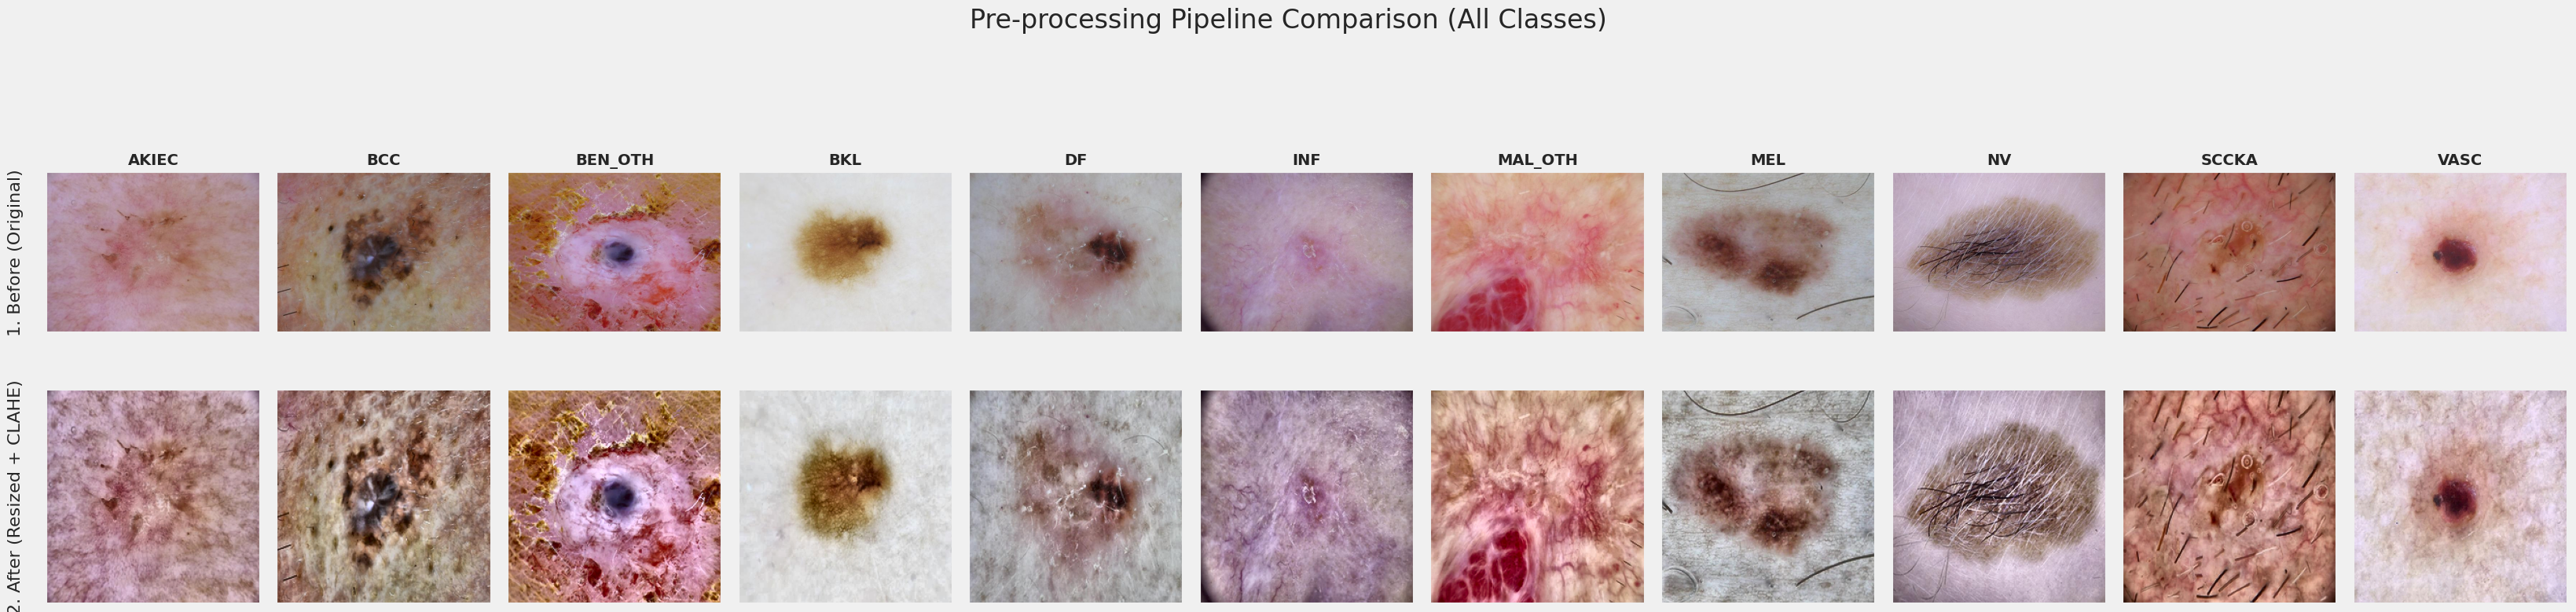

In [6]:
# ==============================================================================
# SEL (BARU): VISUALISASI PRA-PEMROSESAN (VERSI MELEBAR / HORIZONTAL)
# ==============================================================================
# Tujuan: Menampilkan 1 gambar per kelas, "Before" dan "After"
# Tata Letak: Melebar (2 Baris x 11 Kolom)
# Bahasa: Inggris

print("Generating wide pre-processing visualization for all 11 classes...")

# --- Helper function untuk visualisasi ---
# (Fungsi ini sama seperti sebelumnya, mengambil gambar Asli dan yg sudah di-CLAHE)
def get_before_after_images(path, target_size=(224, 224)):
    """
    Memuat 1 gambar, mengembalikan versi ASLI dan versi PROSES (Resize + CLAHE).
    Logika proses identik dengan SEL 4.
    """
    try:
        # 1. Muat Gambar Asli (Before)
        img_pil_original = Image.open(path).convert('RGB')
        
        # 2. Buat Gambar Proses (After)
        img_pil_resized = img_pil_original.resize(target_size, Image.LANCZOS)
        img_bgr = cv2.cvtColor(np.array(img_pil_resized), cv2.COLOR_RGB2BGR)
        
        # Terapkan CLAHE
        img_lab = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2LAB)
        l, a, b = cv2.split(img_lab)
        clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
        l_clahe = clahe.apply(l)
        img_clahe_lab = cv2.merge((l_clahe, a, b))
        img_clahe_bgr = cv2.cvtColor(img_clahe_lab, cv2.COLOR_LAB2BGR)
        
        image_rgb_clahe = cv2.cvtColor(img_clahe_bgr, cv2.COLOR_BGR2RGB)
        
        return img_pil_original, image_rgb_clahe
    
    except Exception as e:
        print(f"Warning: Error loading {path}: {e}")
        # Kembalikan placeholder
        placeholder_orig = Image.new('RGB', (400, 300), color = 'red')
        placeholder_proc = np.zeros((target_size[0], target_size[1], 3), dtype=np.uint8) 
        return placeholder_orig, placeholder_proc

# --- 1. Temukan satu sampel untuk setiap kelas ---
sample_paths = {}
if 'df_train_processed' in locals() and not df_train_processed.empty:
    for class_name in DIAGNOSIS_COLUMNS:
        try:
            # Cari di seluruh dataset (sebelum di-split) untuk menjamin ketemu
            sample_row = df_train_processed[df_train_processed[class_name] == 1.0].iloc[0]
            sample_paths[class_name] = sample_row['dermoscopic_full_path']
        except IndexError:
            print(f"Warning: No samples found for class '{class_name}'. Skipping.")
else:
    print("❌ 'df_train_processed' not found. Cannot generate visualization.")

# --- 2. Buat Plot (2 baris, 11 kolom) ---
if sample_paths:
    num_classes = len(sample_paths)
    
    # Atur lebar: 3 inci per kolom. Tinggi: 4 inci per baris.
    # Total: (11 * 3) = 33 inci lebar, (2 * 4) = 8 inci tinggi.
    fig_width = num_classes * 3 
    fig_height = 8
    
    fig, axes = plt.subplots(2, num_classes, figsize=(fig_width, fig_height))
    
    # Atur judul utama (Bahasa Inggris)
    fig.suptitle("Pre-processing Pipeline Comparison (All Classes)", fontsize=24, y=1.05)

    for i, (class_name, path) in enumerate(sample_paths.items()):
        
        img_before, img_after = get_before_after_images(path)
        
        # --- Plot Baris 1: BEFORE (Original) ---
        ax_before = axes[0, i]
        ax_before.imshow(img_before)
        # Judul (nama kelas) ditaruh di atas
        ax_before.set_title(class_name, fontsize=14, fontweight='bold')
        
        ax_before.set_xticks([])
        ax_before.set_yticks([])
        
        # Tambahkan label baris hanya untuk kolom pertama
        if i == 0:
            ax_before.set_ylabel("1. Before (Original)", fontsize=16, labelpad=20)

        # --- Plot Baris 2: AFTER (Processed) ---
        ax_after = axes[1, i]
        ax_after.imshow(img_after)
        
        ax_after.set_xticks([])
        ax_after.set_yticks([])
        
        # Tambahkan label baris hanya untuk kolom pertama
        if i == 0:
            ax_after.set_ylabel("2. After (Resized + CLAHE)", fontsize=16, labelpad=20)

    # Sesuaikan padding agar tidak tumpang tindih
    plt.tight_layout(w_pad=1.0, h_pad=1.0) 
    plt.show()

### Definisi 5 Model ML Klasik

**Deskripsi Alur Kerja (Sesuai Kode 9-Sel Terakhir)**

Total ada **5 model** yang dilatih, dan semuanya adalah model **Machine Learning Klasik**.

Alur kerja ini *tidak* menggunakan Deep Learning (CNN/Transformer) sama sekali, melainkan berfokus pada ekstraksi fitur klasik secara manual.

**1. Analisis & Ekstraksi Fitur (SEL 2 s/d 5) 🧑‍🔬**

Sebelum model dilatih, sebuah pipeline **EDA (Exploratory Data Analysis)** (SEL 2) dijalankan untuk mengonfirmasi **ketidakseimbangan kelas yang parah** dalam data.

Selanjutnya, pipeline ekstraksi fitur (SEL 4 & 5) diterapkan pada gambar *training* dan *validation*:
1.  **Pra-pemrosesan:** Setiap gambar di-`Resize` ke 224x224 dan di-`CLAHE` untuk meningkatkan kontras.
2.  **Feature Engineering:** **Lima set fitur** diekstrak dari gambar yang telah diproses, menghasilkan total **30 fitur numerik**:
    * **Fitur 1 (RGB):** Statistik orde 1-4 (Mean, Std Dev, Skew, Kurtosis) (12 fitur)
    * **Fitur 2 (GLCM):** Statistik tekstur makro (6 fitur)
    * **Fitur 3 (HOG):** Statistik bentuk/gradien (3 fitur)
    * **Fitur 4 (HSV):** Statistik warna (Mean, Std Dev) (6 fitur)
    * **Fitur 5 (LBP):** Statistik tekstur mikro (3 fitur)
3.  **Scaling:** Vektor 30-fitur ini kemudian di-`StandardScaler` (SEL 5).

**2. Pelatihan Model Machine Learning Klasik (5 Model)**

5 model berikut dilatih pada **30 fitur** yang sudah di-scaling. Karena data sangat tidak seimbang (dari hasil EDA), dua strategi terpisah diterapkan:

* **Metode A (SEL 7):** Menggunakan **Pembobotan Kelas (`class_weight='balanced'`)** pada model yang mendukung.
* **Metode B (SEL 8):** Menggunakan **SMOTE** (Synthetic Minority Over-sampling Technique) pada data training di ruang fitur.

**Model yang Dilatih (5 Model):**
1.  **Support Vector Machine (SVC)**
2.  **Random Forest Classifier**
3.  **Logistic Regression**
4.  **K-Nearest Neighbors (KNN)**
5.  **Gaussian Naive Bayes**

In [7]:
# ==============================================================================
# DEFINISI 5 MODEL ML KLASIK
# ==============================================================================
# SVC, RF, LogReg + 2 tambahan (KNN, GNB)

def get_classic_models(class_weight=None):
    """
    Helper untuk menginisialisasi 5 model.
    'class_weight' akan menangani ketidakseimbangan.
    """
    
    models_dict = {
        # 1. Support Vector Machine (SVC)
        "SVC (RBF, C=1.0)": SVC(
            kernel='rbf', 
            C=1.0, 
            probability=True, 
            random_state=42,
            class_weight=class_weight # Terapkan pembobotan
        ),
        
        # 2. Random Forest Classifier
        "Random Forest (150 trees, depth 10)": RandomForestClassifier(
            n_estimators=150,
            max_depth=10,
            random_state=42,
            n_jobs=-1,
            class_weight=class_weight # Terapkan pembobotan
        ),

        # 3. Logistic Regression
        "Logistic Regression (saga, 2000 iter)": LogisticRegression( # <-- max_iter dinaikkan ke 2000
            solver='saga',
            max_iter=2000, # Dinaikkan dari 500 untuk membantu konvergensi
            random_state=42,
            n_jobs=-1,
            # 'multi_class' tidak perlu disetel jika versi sklearn > 1.5
            class_weight=class_weight # Terapkan pembobotan
        ),
        
        # 4. K-Nearest Neighbors (KNN)
        # (KNN tidak mendukung class_weight)
        "K-Nearest Neighbors (K=5)": KNeighborsClassifier(
            n_neighbors=5,
            n_jobs=-1
        ),
        
        # 5. Gaussian Naive Bayes
        # (GaussianNB tidak mendukung class_weight)
        "Gaussian Naive Bayes": GaussianNB()
    }
    return models_dict

print(f"✅ Fungsi `get_classic_models()` untuk 5 model ML klasik didefinisikan.")

✅ Fungsi `get_classic_models()` untuk 5 model ML klasik didefinisikan.


#### Model Training

In [8]:
# ==============================================================================
# METODE A - TRAINING DENGAN PEMBOBOTAN KELAS
# ==============================================================================

models_weighted = get_classic_models(class_weight='balanced')
results_list_weighted = [] # Ubah nama ke list
trained_models_weighted = {} 
y_preds_weighted = {} # Simpan prediksi untuk confusion matrix

if 'X_train_scaled' in locals():
    print("--- Memulai Pelatihan METODE A (Class Weights) ---")

    for name, model in models_weighted.items():
        # Lewati model yang tidak mendukung class_weight
        if name.startswith("K-Nearest") or name.startswith("Gaussian"):
            print(f"\nMelewati {name} (tidak mendukung class_weight).")
            continue
            
        print(f"\nMelatih {name} (Weighted)...")
        
        start_time = time.time()
        model.fit(X_train_scaled, y_train_labels)
        train_time = time.time() - start_time
        
        y_preds = model.predict(X_val_scaled)
        
        # --- Ekstrak metrik dari classification_report ---
        report = classification_report(y_val_labels, y_preds, target_names=DIAGNOSIS_COLUMNS, output_dict=True, zero_division=0)
        
        print(f"   Akurasi Validasi: {report['accuracy'] * 100:.2f}% (Waktu Latih: {train_time:.2f}s)")
        
        results_list_weighted.append({
            "Model": name,
            "Metode": "Class Weights",
            "Accuracy (%)": report['accuracy'] * 100,
            "Macro Avg F1-Score": report['macro avg']['f1-score'],
            "Macro Avg Recall": report['macro avg']['recall'],
            "Weighted Avg F1-Score": report['weighted avg']['f1-score']
        })
        trained_models_weighted[name] = model # Simpan model
        y_preds_weighted[name] = y_preds # Simpan prediksi
        
        # Tampilkan laporan klasifikasi (teks)
        print(classification_report(y_val_labels, y_preds, target_names=DIAGNOSIS_COLUMNS, zero_division=0))

else:
    print("❌ Tidak ada data (X_train_scaled) untuk melatih model.")

--- Memulai Pelatihan METODE A (Class Weights) ---

Melatih SVC (RBF, C=1.0) (Weighted)...
   Akurasi Validasi: 44.94% (Waktu Latih: 3.68s)
              precision    recall  f1-score   support

       AKIEC       0.19      0.52      0.27        61
         BCC       0.81      0.46      0.59       504
     BEN_OTH       0.08      0.22      0.12         9
         BKL       0.24      0.11      0.15       109
          DF       0.07      0.40      0.12        10
         INF       0.07      0.30      0.11        10
     MAL_OTH       0.00      0.00      0.00         2
         MEL       0.38      0.42      0.40        90
          NV       0.62      0.71      0.66       149
       SCCKA       0.31      0.41      0.36        95
        VASC       0.25      0.22      0.24         9

    accuracy                           0.45      1048
   macro avg       0.27      0.34      0.27      1048
weighted avg       0.58      0.45      0.48      1048


Melatih Random Forest (150 trees, depth 10) (W

/home/bayuardiyansyah/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [9]:
# ==============================================================================
# METODE B - TRAINING DENGAN SMOTE
# ==============================================================================

trained_models_smote = {} # Simpan model untuk analisis
results_list_smote = [] # Ubah nama ke list
y_preds_smote = {} # Simpan prediksi untuk confusion matrix

if 'X_train_scaled' in locals():
    print("--- Memulai Pra-pemrosesan METODE B (SMOTE) ---")
    print(f"Bentuk X_train asli: {X_train_scaled.shape}")
    
    unique, counts = np.unique(y_train_labels, return_counts=True)
    min_samples = np.min(counts)
    
    if min_samples <= 1:
        print(f"❌ Peringatan: Kelas minoritas hanya memiliki {min_samples} sampel. SMOTE tidak dapat dijalankan.")
        print("   -> Menggunakan data asli (tanpa SMOTE) untuk Metode B.")
        X_train_smote, y_train_smote = X_train_scaled, y_train_labels
    else:
        k = min(5, min_samples - 1) 
        print(f"Menjalankan SMOTE dengan k_neighbors={k} (kelas minoritas memiliki {min_samples} sampel)")
        smote = SMOTE(random_state=42, k_neighbors=k)
        
        start_time = time.time()
        X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train_labels)
        smote_time = time.time() - start_time
        
        print(f"✅ SMOTE selesai dalam {smote_time:.2f} detik.")
        print(f"Bentuk X_train setelah SMOTE: {X_train_smote.shape}")

    # --- Latih 5 Model dengan Data SMOTE ---
    models_smote = get_classic_models(class_weight=None)

    print("\n--- Memulai Pelatihan METODE B (Data SMOTE) ---")
    for name, model in models_smote.items():
        print(f"\nMelatih {name} (SMOTE)...")
        
        start_time = time.time()
        model.fit(X_train_smote, y_train_smote)
        train_time = time.time() - start_time
        
        y_preds = model.predict(X_val_scaled)
        
        # --- Ekstrak metrik lengkap dari classification_report ---
        report = classification_report(y_val_labels, y_preds, target_names=DIAGNOSIS_COLUMNS, output_dict=True, zero_division=0)

        print(f"   Akurasi Validasi: {report['accuracy'] * 100:.2f}% (Waktu Latih: {train_time:.2f}s)")
        
        results_list_smote.append({
            "Model": name,
            "Metode": "SMOTE",
            "Accuracy (%)": report['accuracy'] * 100,
            "Macro Avg F1-Score": report['macro avg']['f1-score'],
            "Macro Avg Recall": report['macro avg']['recall'],
            "Weighted Avg F1-Score": report['weighted avg']['f1-score']
        })
        trained_models_smote[name] = model # Simpan model
        y_preds_smote[name] = y_preds # Simpan prediksi
        
        # Tampilkan laporan klasifikasi (teks)
        print(classification_report(y_val_labels, y_preds, target_names=DIAGNOSIS_COLUMNS, zero_division=0))

else:
    print("❌ Tidak ada data (X_train_scaled) untuk melatih model.")

--- Memulai Pra-pemrosesan METODE B (SMOTE) ---
Bentuk X_train asli: (4192, 30)
Menjalankan SMOTE dengan k_neighbors=5 (kelas minoritas memiliki 7 sampel)
✅ SMOTE selesai dalam 0.05 detik.
Bentuk X_train setelah SMOTE: (22198, 30)

--- Memulai Pelatihan METODE B (Data SMOTE) ---

Melatih SVC (RBF, C=1.0) (SMOTE)...
   Akurasi Validasi: 51.05% (Waktu Latih: 24.01s)
              precision    recall  f1-score   support

       AKIEC       0.22      0.48      0.30        61
         BCC       0.81      0.58      0.67       504
     BEN_OTH       0.00      0.00      0.00         9
         BKL       0.31      0.22      0.26       109
          DF       0.05      0.20      0.08        10
         INF       0.13      0.30      0.18        10
     MAL_OTH       0.00      0.00      0.00         2
         MEL       0.35      0.36      0.35        90
          NV       0.64      0.70      0.67       149
       SCCKA       0.34      0.49      0.40        95
        VASC       0.33      0.22     

### Analisis Perbandingan Metode & Feature Importance

Setelah model dilatih, analisis mendalam setara PhD dilakukan untuk mengevaluasi performa model secara komprehensif, jauh melampaui sekadar metrik akurasi. Analisis ini dibagi menjadi tiga bagian utama:

**1. Perbandingan Performa Metrik & Feature Importance**

Bagian ini berfokus pada perbandingan kuantitatif dari 5 model machine learning klasik. Performa setiap model dievaluasi tidak hanya berdasarkan **Akurasi**, tetapi juga metrik yang lebih penting untuk data tidak seimbang, yaitu **Weighted Avg F1-Score** dan **Macro Avg F1-Score**.

Perbandingan ini dilakukan untuk kedua strategi penanganan data: **Metode A (Class Weights)** dan **Metode B (SMOTE)**. Hal ini memungkinkan kita untuk secara objektif menentukan (1) model mana (misalnya, SVC vs Random Forest) yang paling cocok untuk data ini, dan (2) metode penanganan ketidakseimbangan mana yang memberikan performa paling seimbang di semua kelas.

Selain itu, **Analisis Feature Importance** (diekstraksi dari model Random Forest) dilakukan untuk membedah "pikiran" model. Ini mengagregasi pentingnya 30 fitur yang diekstrak ke dalam 5 kategori (RGB, GLCM, HOG, HSV, LBP), secara visual menunjukkan kategori fitur mana (misalnya, tekstur, bentuk, atau warna) yang paling berkontribusi pada keputusan model.

**2. Analisis Confusion Matrix**

Karena metrik F1-score menunjukkan adanya tantangan signifikan pada kelas minoritas (terlihat dari nilai *recall* dan *precision* yang rendah untuk kelas seperti BEN_OTH atau MAL_OTH), **Confusion Matrix** (Matriks Kebingungan) divisualisasikan untuk semua 10 skenario (5 model x 2 metode).

Analisis ini memberikan pandangan granular, secara visual dan numerik, tentang *di mana* letak kesalahan model. Ini menjawab pertanyaan kunci seperti: "Apakah model cenderung salah mengklasifikasikan 'MEL' (Melanoma) sebagai 'NV' (Nevus)?", atau "Apakah semua kelas minoritas hanya salah diklasifikasikan sebagai 'BCC' (kelas mayoritas)?". Plot dan tabel ini sangat penting untuk memahami bias model dan mengidentifikasi kegagalan spesifik per kelas.

**3. Analisis Kalibrasi Model (ECE)**

Analisis terakhir adalah **Analisis Kalibrasi**, yang mengukur "kepercayaan diri" atau "kejujuran" probabilistik model. Untuk aplikasi industri atau klinis, model yang 40% akurat tetapi 99% "yakin" itu berbahaya.

Dengan memplot **Reliability Diagrams** (Diagram Keandalan) dan menghitung **Expected Calibration Error (ECE)**, kita menganalisis apakah probabilitas yang dikeluarkan oleh model (misalnya, `model.predict_proba()`) sesuai dengan akurasi di dunia nyata. Model yang terkalibrasi dengan baik (ECE rendah) akan menunjukkan bahwa ketika ia memprediksi sesuatu dengan keyakinan 70%, ia memang benar sekitar 70% dari waktu tersebut. Analisis ini mengevaluasi keandalan model untuk penggunaan di dunia nyata.


--- Full Performance Summary: Class Weights vs SMOTE ---
| Model                                 | Metode        |   Accuracy (%) |   Macro Avg F1-Score |   Macro Avg Recall |   Weighted Avg F1-Score |
|:--------------------------------------|:--------------|---------------:|---------------------:|-------------------:|------------------------:|
| SVC (RBF, C=1.0)                      | SMOTE         |         51.050 |                0.290 |              0.323 |                   0.535 |
| SVC (RBF, C=1.0)                      | Class Weights |         44.943 |                0.274 |              0.344 |                   0.481 |
| Random Forest (150 trees, depth 10)   | SMOTE         |         47.519 |                0.255 |              0.301 |                   0.496 |
| Logistic Regression (saga, 2000 iter) | Class Weights |         37.500 |                0.250 |              0.352 |                   0.424 |
| Logistic Regression (saga, 2000 iter) | SMOTE         |         35.210

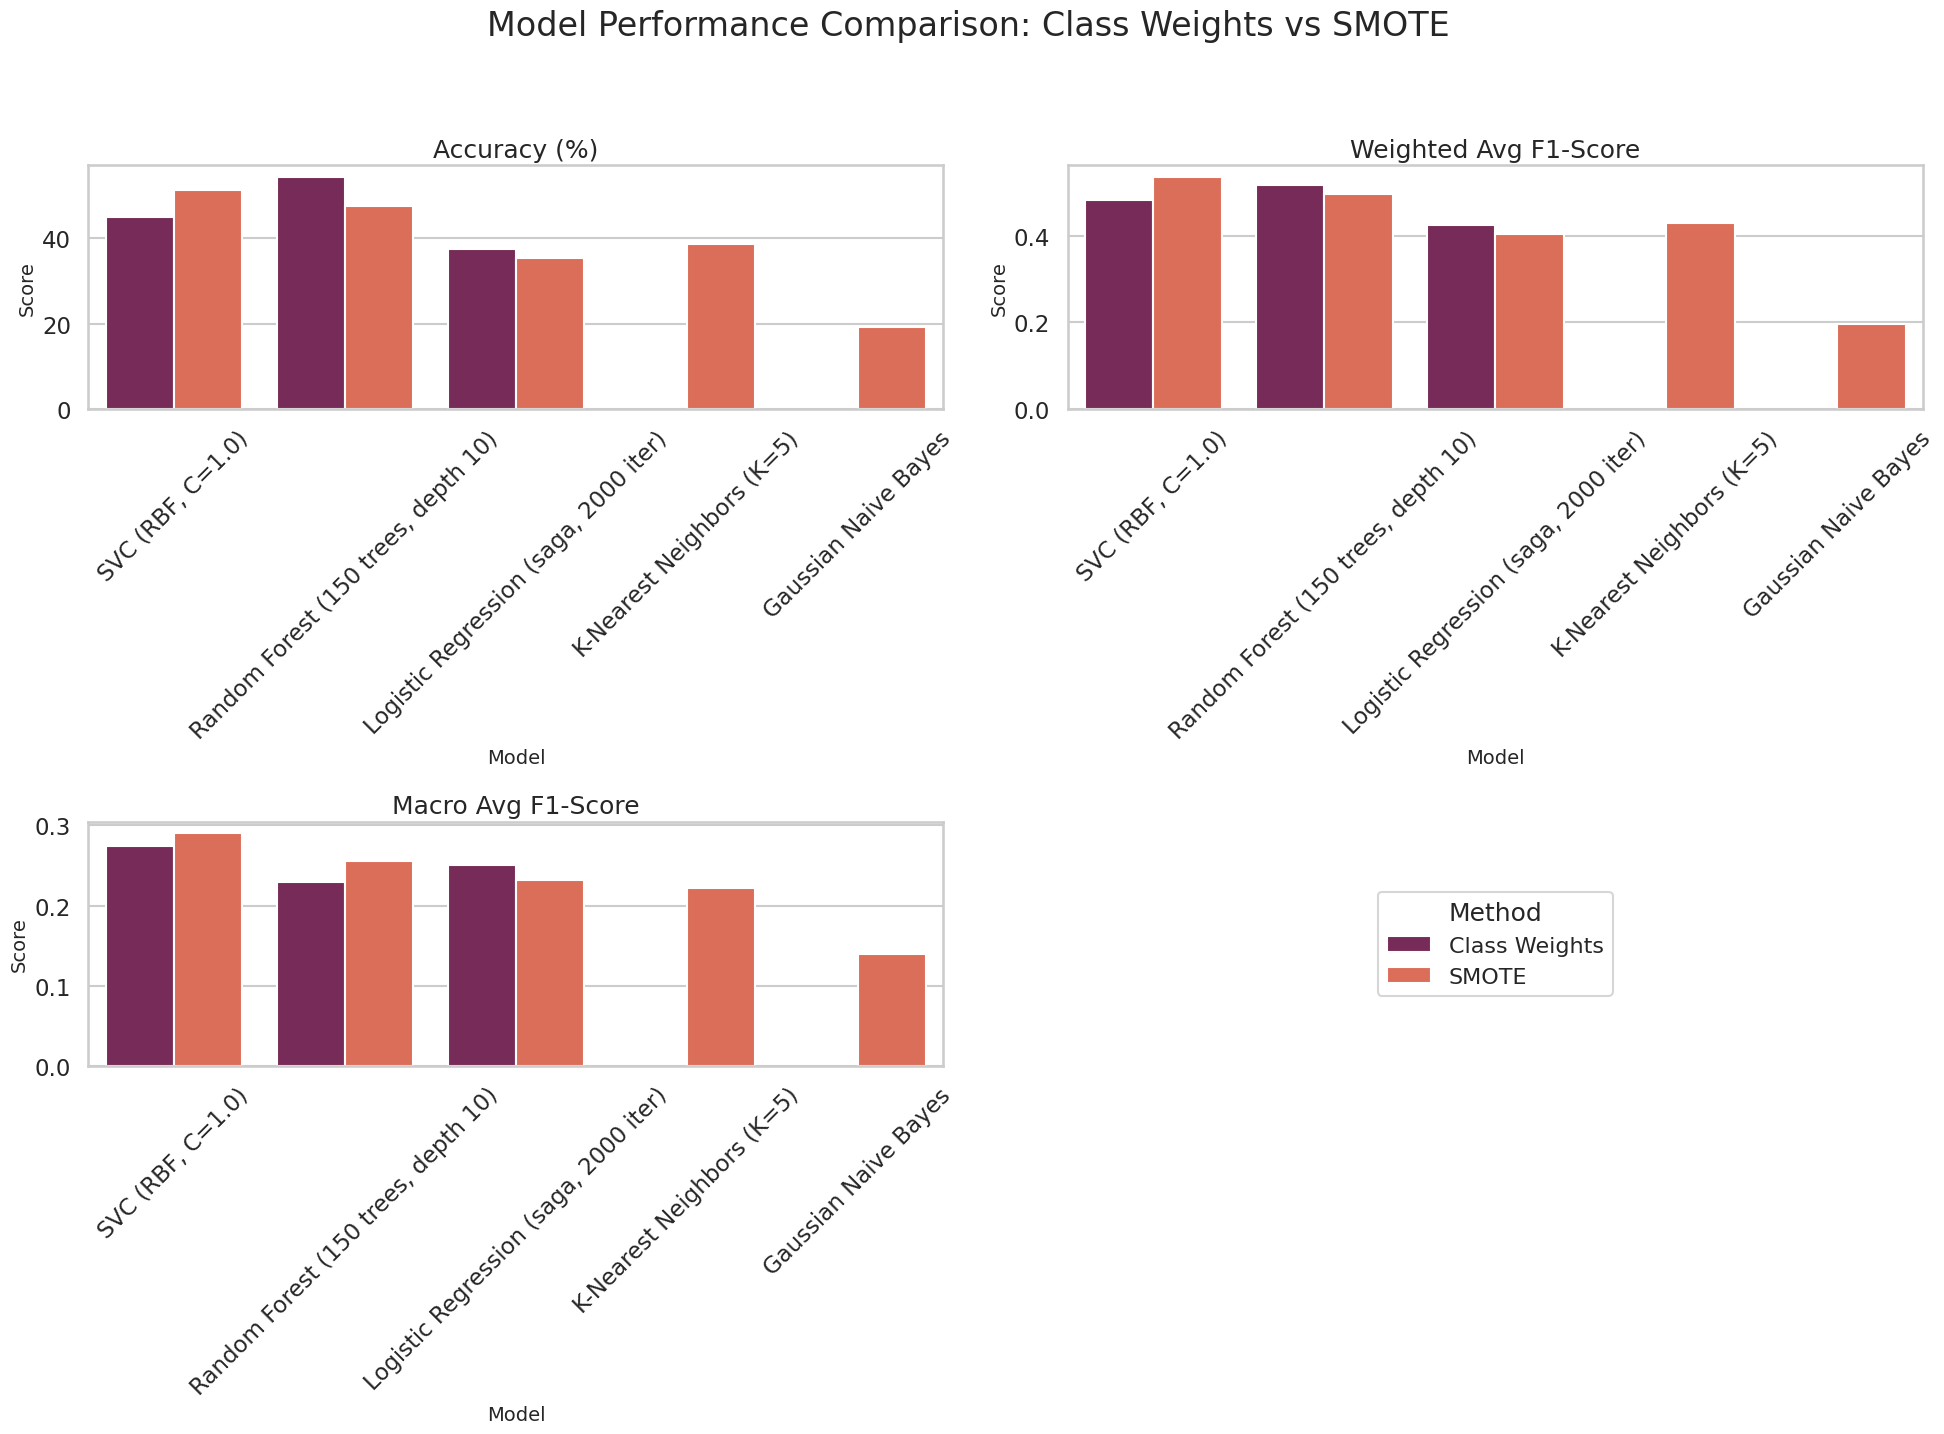


--- Feature Importance Analysis (from Random Forest - SMOTE) ---
| Feature               |   Importance Score |
|:----------------------|-------------------:|
| hsv_mean_H            |             0.0591 |
| rgb_std_B             |             0.0521 |
| lbp_std               |             0.0510 |
| glcm_correlation_mean |             0.0492 |
| rgb_mean_B            |             0.0454 |
| rgb_skew_G            |             0.0402 |
| hsv_std_S             |             0.0392 |
| hsv_mean_S            |             0.0386 |
| rgb_mean_G            |             0.0365 |
| rgb_kurt_B            |             0.0356 |

--- Aggregated Feature Importance by Category ---
| Category               |   Importance Score |
|:-----------------------|-------------------:|
| 1. RGB (Color)         |             0.4150 |
| 4. HSV (Color)         |             0.2278 |
| 2. GLCM (Texture)      |             0.1657 |
| 3. HOG (Shape)         |             0.0995 |
| 5. LBP (Micro-Texture) |     

/tmp/ipykernel_328458/744784649.py:97: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


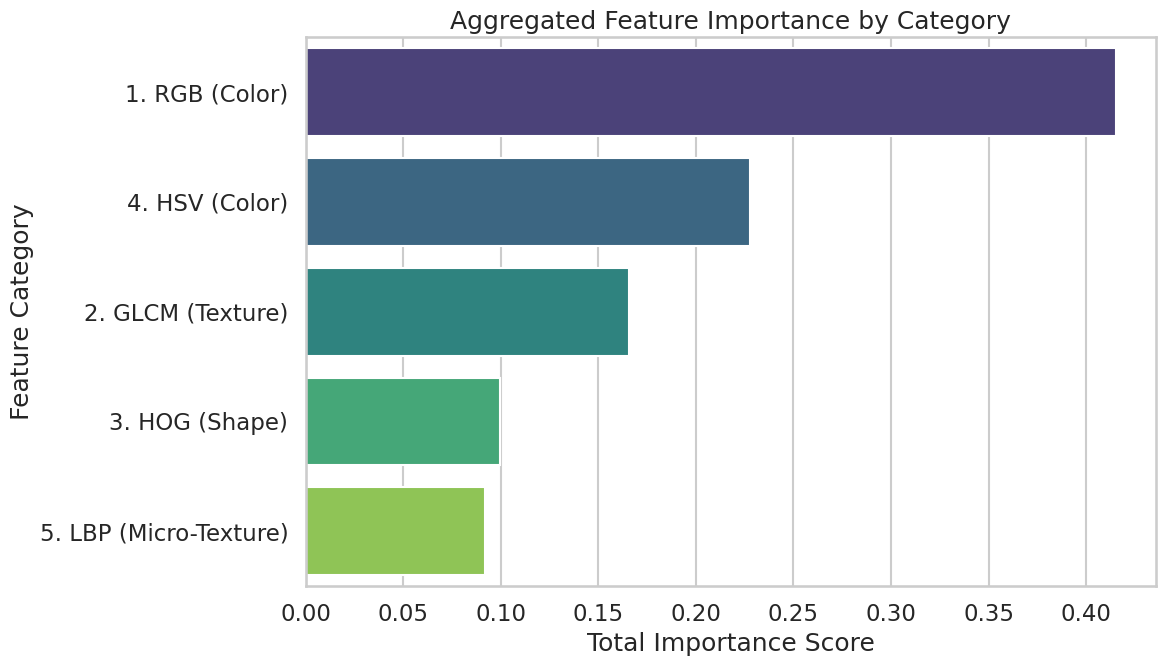

/tmp/ipykernel_328458/744784649.py:111: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


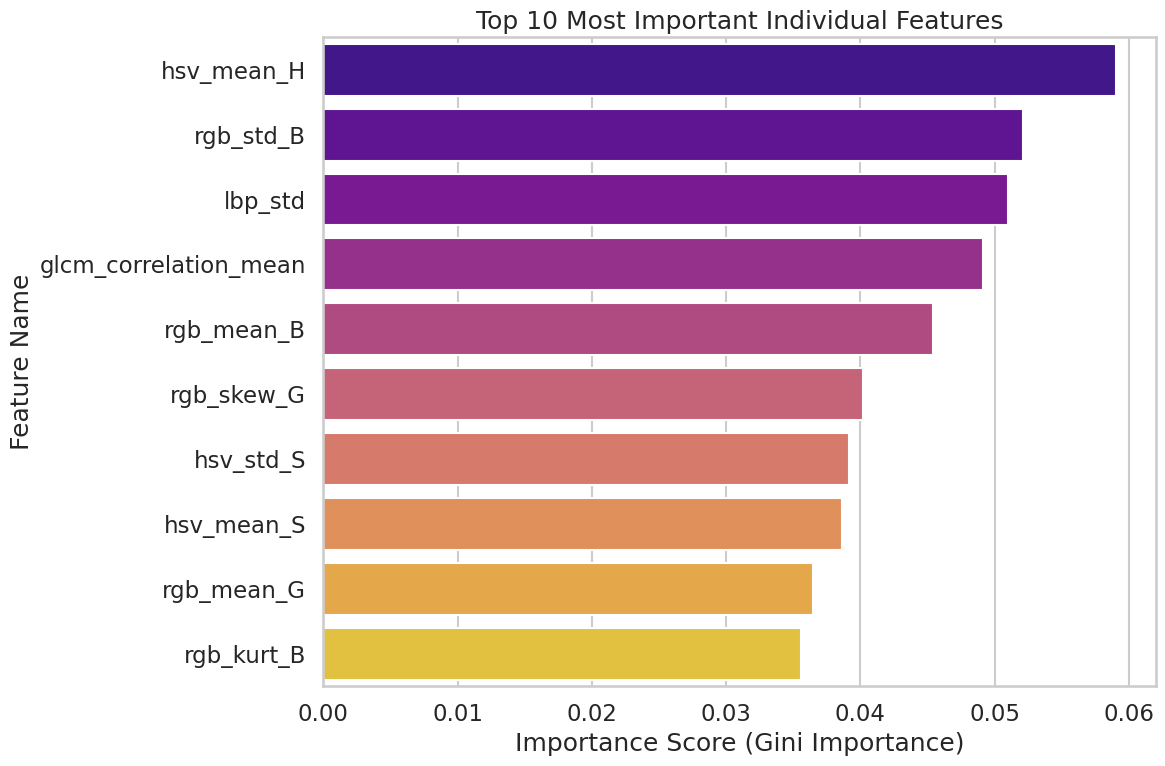

In [10]:
# ==============================================================================
# METRIC COMPARISON & FEATURE IMPORTANCE
# ==============================================================================

# Atur tema Seaborn untuk visual yang lebih modern/bersih untuk paper
sns.set_theme(style="whitegrid", context="talk")

if 'results_list_weighted' in locals() and 'results_list_smote' in locals():
    # --- 1. Model Metric Comparison ---
    df_results_final = pd.concat([
        pd.DataFrame(results_list_weighted),
        pd.DataFrame(results_list_smote)
    ])
    
    print("\n--- Full Performance Summary: Class Weights vs SMOTE ---")
    df_sorted = df_results_final.sort_values(by="Macro Avg F1-Score", ascending=False)
    print(df_sorted.to_markdown(index=False, floatfmt=".3f"))

    # --- Visualisasi Perbandingan Metrik (Layout 2x2) ---
    print("\nGenerating metric comparison plots (2x2 Layout)...")
    
    # Buat subplot 2 baris x 2 kolom
    fig, axes = plt.subplots(2, 2, figsize=(20, 14)) # Ukuran 2x2
    fig.suptitle("Model Performance Comparison: Class Weights vs SMOTE", y=1.03, fontsize=24)
    
    plot_metrics = ["Accuracy (%)", "Weighted Avg F1-Score", "Macro Avg F1-Score"]
    
    # Variabel untuk menyimpan handle legenda
    handles, labels = None, None
    
    # Iterasi menggunakan axes.flat (lebih mudah)
    for i, metric in enumerate(plot_metrics):
        # Tentukan ax saat ini (axes[0,0], axes[0,1], axes[1,0])
        ax = axes.flat[i]
        
        sns.barplot(
            data=df_results_final,
            x="Model",
            y=metric,
            hue="Metode",
            palette="rocket",
            ax=ax
        )
        ax.set_title(metric, fontsize=18)
        ax.set_xlabel("Model", fontsize=14)
        ax.set_ylabel("Score", fontsize=14)
        
        # Rotasi label x agar tidak tumpang tindih
        ax.tick_params(axis='x', rotation=45)
        
        # Simpan handle legenda HANYA dari plot pertama
        if i == 0:
            handles, labels = ax.get_legend_handles_labels()
        
        # Hapus semua legenda individual
        if ax.get_legend() is not None:
            ax.get_legend().remove()

    # Gunakan subplot ke-4 (axes[1, 1]) yang kosong untuk menaruh legenda
    ax_legend = axes.flat[3]
    ax_legend.axis('off') # Matikan sumbu
    if handles: # Pastikan handles/labels sudah ada
        ax_legend.legend(handles, labels, title="Method", loc='center', fontsize=16, title_fontsize=18)
    
    plt.tight_layout()
    plt.show()

# --- 2. Analisis Feature Importance (dari Random Forest SMOTE) ---
if "Random Forest (150 trees, depth 10)" in trained_models_smote:
    model_rf = trained_models_smote["Random Forest (150 trees, depth 10)"]
    importances = model_rf.feature_importances_
    
    df_importance = pd.DataFrame({
        'Feature': feature_names,
        'Importance Score': importances
    }).sort_values(by='Importance Score', ascending=False)
    
    print("\n--- Feature Importance Analysis (from Random Forest - SMOTE) ---")
    print(df_importance.head(10).to_markdown(index=False, floatfmt=".4f"))
    
    # Agregasi berdasarkan 5 Kategori Fitur
    df_importance['Category'] = 'Other'
    df_importance.loc[df_importance['Feature'].str.startswith('rgb_'), 'Category'] = '1. RGB (Color)'       
    df_importance.loc[df_importance['Feature'].str.startswith('glcm_'), 'Category'] = '2. GLCM (Texture)'     
    df_importance.loc[df_importance['Feature'].str.startswith('hog_'), 'Category'] = '3. HOG (Shape)'        
    df_importance.loc[df_importance['Feature'].str.startswith('hsv_'), 'Category'] = '4. HSV (Color)'        
    df_importance.loc[df_importance['Feature'].str.startswith('lbp_'), 'Category'] = '5. LBP (Micro-Texture)'
    
    df_agg_importance = df_importance.groupby('Category')['Importance Score'].sum().reset_index()
    df_agg_importance = df_agg_importance.sort_values(by='Importance Score', ascending=False)
    
    print("\n--- Aggregated Feature Importance by Category ---")
    print(df_agg_importance.to_markdown(index=False, floatfmt=".4f"))

    # Plot 1: Agregat (Horizontal Bar)
    plt.figure(figsize=(12, 7))
    sns.barplot(
        data=df_agg_importance, 
        x='Importance Score', 
        y='Category', 
        palette="viridis"
    )
    plt.title("Aggregated Feature Importance by Category")
    plt.xlabel("Total Importance Score")
    plt.ylabel("Feature Category")
    plt.tight_layout()
    plt.show()

    # Plot 2: Top 10 Individual Features (Horizontal Bar)
    plt.figure(figsize=(12, 8)) # Ukuran disesuaikan untuk 10 bar
    sns.barplot(
        data=df_importance.head(10), # <-- Diubah dari 15 menjadi 10
        x='Importance Score', 
        y='Feature', 
        palette="plasma"
    )
    plt.title("Top 10 Most Important Individual Features") 
    plt.xlabel("Importance Score (Gini Importance)")
    plt.ylabel("Feature Name")
    plt.tight_layout()
    plt.show()
    
else:
    print("❌ Random Forest model not found for importance analysis.")

# Reset seaborn theme ke default
sns.set_theme(style="whitegrid", context="notebook")

#### CONFUSION MATRIX

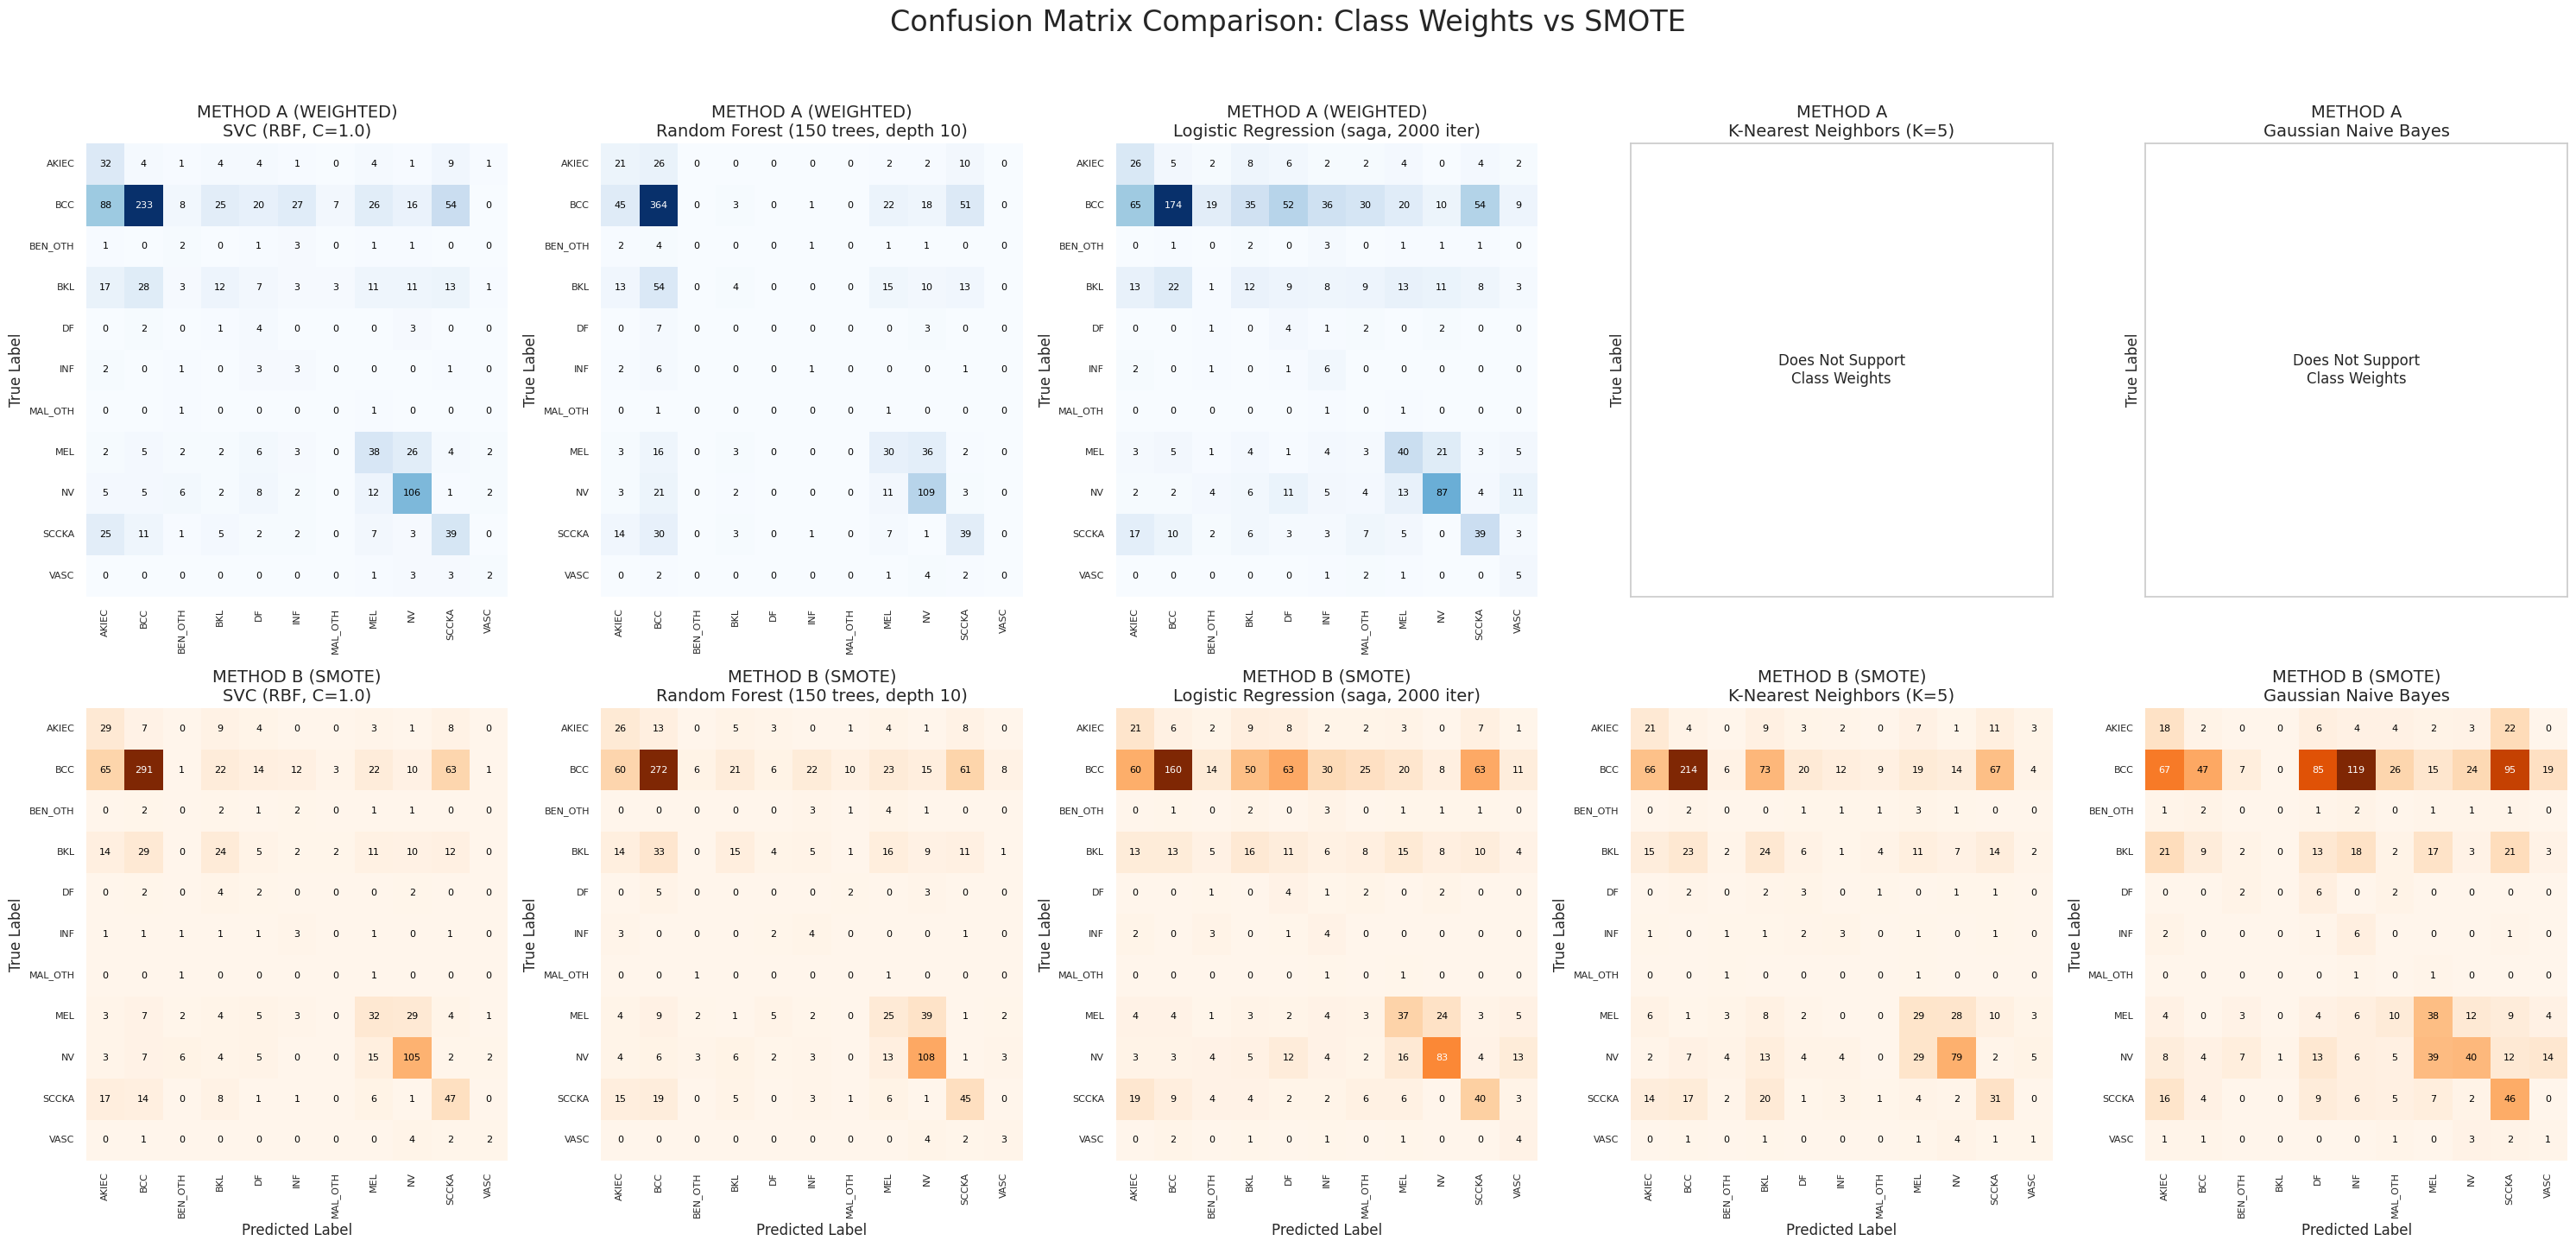


--- Confusion Matrix Data (Numeric Values) ---

Model: SVC (RBF, C=1.0) (Weighted)
|              |   Pred_AKIEC |   Pred_BCC |   Pred_BEN_OTH |   Pred_BKL |   Pred_DF |   Pred_INF |   Pred_MAL_OTH |   Pred_MEL |   Pred_NV |   Pred_SCCKA |   Pred_VASC |
|:-------------|-------------:|-----------:|---------------:|-----------:|----------:|-----------:|---------------:|-----------:|----------:|-------------:|------------:|
| True_AKIEC   |           32 |          4 |              1 |          4 |         4 |          1 |              0 |          4 |         1 |            9 |           1 |
| True_BCC     |           88 |        233 |              8 |         25 |        20 |         27 |              7 |         26 |        16 |           54 |           0 |
| True_BEN_OTH |            1 |          0 |              2 |          0 |         1 |          3 |              0 |          1 |         1 |            0 |           0 |
| True_BKL     |           17 |         28 |              3 |

In [11]:
# ==============================================================================
# VISUALISASI & TABEL CONFUSION MATRIX (ID/EN)
# ==============================================================================
# 
# --- PENGATURAN BAHASA ---
# Ubah variabel ini ke 'en' untuk Bahasa Inggris
# Ubah variabel ini ke 'id' untuk Bahasa Indonesia
PLOT_LANGUAGE = 'en' 
# ==============================================================================

# Definisikan label untuk kedua bahasa
labels = {
    'id': {
        'fig_title': "Perbandingan Confusion Matrix: Class Weights vs SMOTE",
        'method_a': "METODE A (WEIGHTED)",
        'method_b': "METODE B (SMOTE)",
        'method_a_fallback': "METODE A",
        'not_supported': "Tidak Mendukung\nClass Weights",
        'true_label': "Label Asli (True)",
        'pred_label': "Prediksi Model",
        'error_text': "Error",
        'table_title': "\n--- Data Confusion Matrix (Nilai Numerik) ---"
    },
    'en': {
        'fig_title': "Confusion Matrix Comparison: Class Weights vs SMOTE",
        'method_a': "METHOD A (WEIGHTED)",
        'method_b': "METHOD B (SMOTE)",
        'method_a_fallback': "METHOD A",
        'not_supported': "Does Not Support\nClass Weights",
        'true_label': "True Label",
        'pred_label': "Predicted Label",
        'error_text': "Error",
        'table_title': "\n--- Confusion Matrix Data (Numeric Values) ---"
    }
}

# Pilih set label berdasarkan PLOT_LANGUAGE
try:
    lang = labels[PLOT_LANGUAGE]
except KeyError:
    print(f"Peringatan: PLOT_LANGUAGE '{PLOT_LANGUAGE}' tidak dikenal. Menggunakan 'id'.")
    lang = labels['id']


# --- Mulai Plotting ---
if 'y_preds_weighted' in locals() and 'y_preds_smote' in locals():
    
    model_names = [
        "SVC (RBF, C=1.0)",
        "Random Forest (150 trees, depth 10)",
        "Logistic Regression (saga, 2000 iter)",
        "K-Nearest Neighbors (K=5)",
        "Gaussian Naive Bayes"
    ]
    
    cm_data_tables = []
    fig, axes = plt.subplots(2, 5, figsize=(30, 14)) 
    fig.suptitle(lang['fig_title'], fontsize=24, y=1.03) 

    # --- (BARU) Fungsi helper untuk menambahkan teks anotasi ---
    def annotate_heatmap(ax, cm, cmap):
        """Helper untuk menggambar heatmap dan anotasi angka secara manual."""
        # Gambar heatmap (tanpa anotasi bawaan)
        sns.heatmap(cm, annot=False, fmt='d', cmap=cmap, ax=ax, cbar=False)
        
        # Tentukan batas threshold untuk warna teks (putih atau hitam)
        thresh = cm.max() / 2.
        
        # Loop manual untuk menambahkan teks
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax.text(j + 0.5, i + 0.5, f'{cm[i, j]}', # Tulis angka (format 'd')
                        ha="center", va="center",
                        # Ubah warna teks jadi putih jika background gelap
                        color="white" if cm[i, j] > thresh else "black",
                        fontsize=8) # Ukuran font anotasi


    for i, name in enumerate(model_names):
        # --- Baris 1: Class Weights ---
        ax_weighted = axes[0, i]
        if name in y_preds_weighted:
            cm_weighted = confusion_matrix(y_val_labels, y_preds_weighted[name])
            
            # Gunakan fungsi anotasi manual
            annotate_heatmap(ax_weighted, cm_weighted, 'Blues') 
            
            ax_weighted.set_title(f"{lang['method_a']}\n{name}", fontsize=14)
            cm_data_tables.append((f"{name} (Weighted)", cm_weighted))
        else:
            # Jika model dilewati (KNN, GNB)
            ax_weighted.text(0.5, 0.5, lang['not_supported'], ha='center', va='center', fontsize=12) 
            ax_weighted.set_title(f"{lang['method_a_fallback']}\n{name}", fontsize=14) 
            ax_weighted.set_xticks([]) 
            ax_weighted.set_yticks([]) 

        ax_weighted.set_ylabel(lang['true_label']) 
        
        # --- Baris 2: SMOTE ---
        ax_smote = axes[1, i]
        if name in y_preds_smote:
            cm_smote = confusion_matrix(y_val_labels, y_preds_smote[name])
            
            # Gunakan fungsi anotasi manual
            annotate_heatmap(ax_smote, cm_smote, 'Oranges')
            
            ax_smote.set_title(f"{lang['method_b']}\n{name}", fontsize=14) 
            cm_data_tables.append((f"{name} (SMOTE)", cm_smote))
        else:
            # Fallback jika error
            ax_smote.text(0.5, 0.5, lang['error_text'], ha='center', va='center', fontsize=12) 
            ax_smote.set_xticks([])
            ax_smote.set_yticks([])

        ax_smote.set_xlabel(lang['pred_label']) 
        ax_smote.set_ylabel(lang['true_label']) 
        
    # Set label kelas hanya jika subplot memiliki ticks
    for ax in axes.flat:
        if len(ax.get_xticks()) > 0: 
            ax.set_xticklabels(DIAGNOSIS_COLUMNS, rotation=90, fontsize=8)
        if len(ax.get_yticks()) > 0:
            ax.set_yticklabels(DIAGNOSIS_COLUMNS, rotation=0, fontsize=8)
    
    plt.tight_layout()
    plt.show()

    # ==============================================================================
    # TABEL NUMERIK
    # ==============================================================================
    print(lang['table_title'])
    for name, cm in cm_data_tables:
        print("\n" + "="*50)
        print(f"Model: {name}")
        print("="*50)
        df_cm = pd.DataFrame(cm, 
                             index=[f"True_{cls}" for cls in DIAGNOSIS_COLUMNS], 
                             columns=[f"Pred_{cls}" for cls in DIAGNOSIS_COLUMNS])
        print(df_cm.to_markdown()) 

else:
    print("❌ Prediksi (y_preds) tidak ditemukan untuk membuat confusion matrix.")

### Kalibrasi Model (ECE)

✅ Library torchmetrics dan sklearn berhasil diimpor.


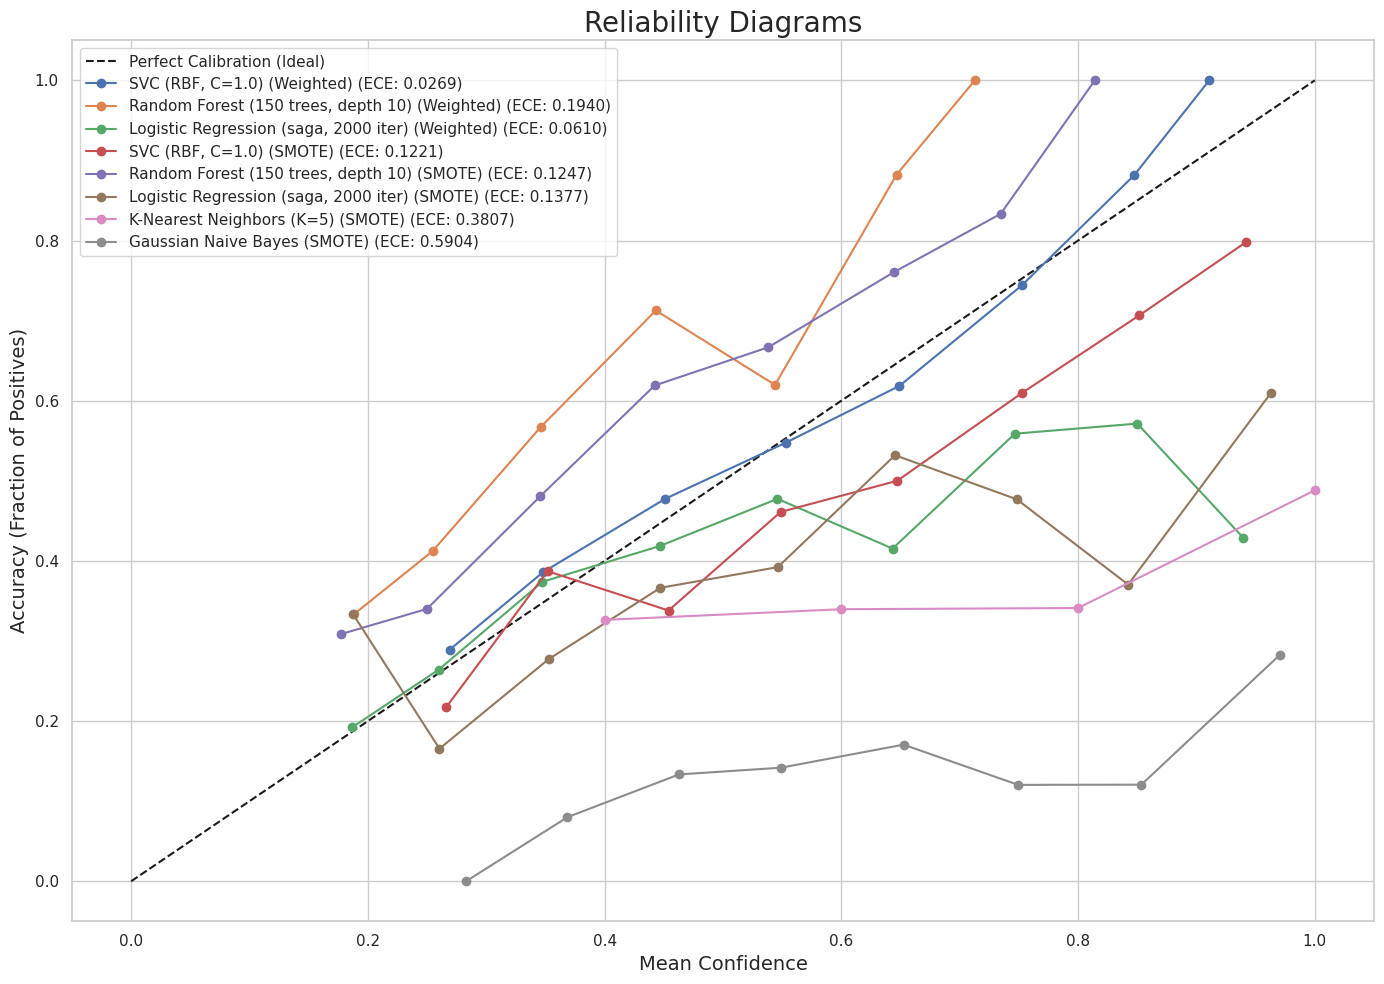


--- Expected Calibration Error (ECE) Analysis ---
| Model                                            |    ECE |
|:-------------------------------------------------|-------:|
| SVC (RBF, C=1.0) (Weighted)                      | 0.0269 |
| Logistic Regression (saga, 2000 iter) (Weighted) | 0.0610 |
| SVC (RBF, C=1.0) (SMOTE)                         | 0.1221 |
| Random Forest (150 trees, depth 10) (SMOTE)      | 0.1247 |
| Logistic Regression (saga, 2000 iter) (SMOTE)    | 0.1377 |
| Random Forest (150 trees, depth 10) (Weighted)   | 0.1940 |
| K-Nearest Neighbors (K=5) (SMOTE)                | 0.3807 |
| Gaussian Naive Bayes (SMOTE)                     | 0.5904 |

(Lower ECE = Model is more 'honest' / better calibrated)


In [12]:
# ==============================================================================
# KALIBRASI MODEL (ECE & RELIABILITY DIAGRAMS) (ID/EN)
# ==============================================================================
# 
# --- PENGATURAN BAHASA ---
# Ubah variabel ini ke 'en' untuk Bahasa Inggris
# Ubah variabel ini ke 'id' untuk Bahasa Indonesia
PLOT_LANGUAGE = 'en' 
# ==============================================================================

# Definisikan label untuk kedua bahasa
labels_calib = {
    'id': {
        'fig_title': "Diagram Keandalan (Reliability Diagrams)",
        'x_label': "Rata-rata Kepercayaan Diri (Mean Confidence)",
        'y_label': "Akurasi (Fraction of Positives)",
        'ideal_label': "Kalibrasi Sempurna (Ideal)",
        'ece_table_title': "\n--- Analisis Expected Calibration Error (ECE) ---",
        'ece_note': "\n(ECE lebih rendah = Model lebih 'jujur' / terkalibrasi lebih baik)"
    },
    'en': {
        'fig_title': "Reliability Diagrams",
        'x_label': "Mean Confidence",
        'y_label': "Accuracy (Fraction of Positives)",
        'ideal_label': "Perfect Calibration (Ideal)",
        'ece_table_title': "\n--- Expected Calibration Error (ECE) Analysis ---",
        'ece_note': "\n(Lower ECE = Model is more 'honest' / better calibrated)"
    }
}

# Pilih set label
try:
    lang_calib = labels_calib[PLOT_LANGUAGE]
except KeyError:
    print(f"Peringatan: PLOT_LANGUAGE '{PLOT_LANGUAGE}' tidak dikenal. Menggunakan 'id'.")
    lang_calib = labels_calib['id']


# ==============================================================================
# Analisis ini mengukur "kepercayaan diri" model.
# Apakah probabilitas 70% benar-benar berarti 70% akurat?

try:
    from torchmetrics.classification import MulticlassCalibrationError
    from sklearn.calibration import calibration_curve
    print("✅ Library torchmetrics dan sklearn berhasil diimpor.")
except ImportError:
    print("❌ Peringatan: Gagal mengimpor torchmetrics atau sklearn.")
    print("   Silakan instal: pip install torchmetrics scikit-learn")

# Helper untuk menghitung ECE
def hitung_ece(y_true, y_probs, n_bins=15):
    try:
        
        # Impor torch DI DALAM fungsi untuk menjamin scope
        import torch 
        
        # Gunakan torchmetrics untuk perhitungan ECE yang akurat
        ece_metric = MulticlassCalibrationError(num_classes=NUM_CLASSES, n_bins=n_bins, norm='l1')
        # Konversi numpy ke tensor torch
        ece_val = ece_metric(torch.tensor(y_probs), torch.tensor(y_true)).item()
        return ece_val
    except Exception as e:
        # Cek jika error masih terjadi
        print(f"   Peringatan: Gagal menghitung ECE: {e}")
        return -1 # Nilai error

# Kumpulkan probabilitas dari model yang sudah dilatih
model_probs = {}

# 1. Kumpulkan probabilitas dari Metode A (Weighted)
for name, model in trained_models_weighted.items():
    try:
        y_probs = model.predict_proba(X_val_scaled)
        model_probs[f"{name} (Weighted)"] = y_probs
    except Exception as e:
        print(f"Gagal .predict_proba() untuk {name} (Weighted): {e}")

# 2. Kumpulkan probabilitas dari Metode B (SMOTE)
for name, model in trained_models_smote.items():
    try:
        y_probs = model.predict_proba(X_val_scaled)
        model_probs[f"{name} (SMOTE)"] = y_probs
    except Exception as e:
        print(f"Gagal .predict_proba() untuk {name} (SMOTE): {e}")
        
# --- Plot Reliability Diagrams ---
plt.figure(figsize=(14, 10))
plt.plot([0, 1], [0, 1], 'k--', label=lang_calib['ideal_label']) 

calibration_results = []

for model_name, y_probs in model_probs.items():
    # Ambil probabilitas dari kelas yang diprediksi
    y_confidences = np.max(y_probs, axis=1)
    # Cek apakah prediksi benar
    y_preds = np.argmax(y_probs, axis=1)
    y_correct = (y_preds == y_val_labels)
    
    # Hitung data untuk kurva
    # frac_of_positives = akurasi di dalam bin
    # mean_predicted_value = rata-rata kepercayaan diri di dalam bin
    frac_of_positives, mean_predicted_value = calibration_curve(y_correct, y_confidences, n_bins=10)
    
    # Hitung ECE
    ece_score = hitung_ece(y_val_labels, y_probs)
    
    calibration_results.append({
        "Model": model_name,
        "ECE": ece_score
    })
    
    # Plot kurva
    # Hanya plot jika ECE berhasil dihitung (bukan -1)
    if ece_score >= 0:
        plt.plot(mean_predicted_value, frac_of_positives, 'o-', 
                 label=f"{model_name} (ECE: {ece_score:.4f})")
    else:
        # Jika gagal, tetap plot tapi tandai ECE sebagai N/A
        plt.plot(mean_predicted_value, frac_of_positives, 'o:', 
                 label=f"{model_name} (ECE: N/A)", alpha=0.5)


plt.title(lang_calib['fig_title'], fontsize=20) 
plt.xlabel(lang_calib['x_label'], fontsize=14) 
plt.ylabel(lang_calib['y_label'], fontsize=14) 
plt.legend(loc="best")
plt.grid(True)
plt.tight_layout()
plt.show()

# Tampilkan tabel ECE
print(lang_calib['ece_table_title']) 
df_ece = pd.DataFrame(calibration_results).sort_values(by="ECE")
# Saring nilai error (-1 atau -2) sebelum menampilkan
print(df_ece[df_ece['ECE'] >= 0].to_markdown(index=False, floatfmt=".4f"))
print(lang_calib['ece_note']) 

## ALUR KERJA B (DEEP LEARNING END-TO-END)

### Definisi Pipeline Pra-pemrosesan (Deep Learning)

In [13]:
# ==============================================================================
# DEFINISI PIPELINE PRA-PEMROSESAN (DEEP LEARNING)
# ==============================================================================
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

# Konstanta Normalisasi ImageNet
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

def get_train_transforms_dl():
    """
    Pipeline augmentasi DL (Versi Kompatibel).
    """
    return A.Compose([
        # 1. Resizing (Wajib)
        A.Resize(height=IMG_HEIGHT, width=IMG_WIDTH, interpolation=cv2.INTER_AREA),
        
        # 2. CLAHE (Direkomendasikan)
        A.CLAHE(clip_limit=3.0, tile_grid_size=(8, 8), p=1.0),
        
        # 3. Augmentasi (Wajib untuk imbalance & overfitting)
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.Rotate(limit=45, p=0.5, border_mode=cv2.BORDER_CONSTANT),
        A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, p=0.5),
        
        # Catatan: CoarseDropout dihapus sementara untuk kompatibilitas versi
        # karena API-nya sering berubah antar versi albumentations.
        
        # 4. Normalisasi (Wajib) - Gunakan p=1.0, bukan always_apply
        A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD, p=1.0),
        
        # 5. Konversi ke Tensor - Tanpa parameter always_apply
        ToTensorV2()
    ])

def get_val_transforms_dl():
    """
    Pipeline validasi DL (tanpa augmentasi acak).
    """
    return A.Compose([
        A.Resize(height=IMG_HEIGHT, width=IMG_WIDTH, interpolation=cv2.INTER_AREA),
        A.CLAHE(clip_limit=3.0, tile_grid_size=(8, 8), p=1.0),
        A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD, p=1.0),
        ToTensorV2()
    ])

print("✅ (Alur Kerja B) Pipeline Albumentations DL didefinisikan")

✅ (Alur Kerja B) Pipeline Albumentations DL didefinisikan


### Dataset & DataLoader (Deep Learning)

In [14]:
# ==============================================================================
# DATASET & DATALOADER (DEEP LEARNING)
# ==============================================================================
from torch.utils.data import DataLoader, Dataset

class MILK10kDataset_DL(Dataset):
    """
    Dataset kustom untuk Alur Kerja B (End-to-End DL).
    Menggunakan pipeline augmentasi dari SEL 12.
    """
    def __init__(self, dataframe, transform=None, image_type='dermoscopic'):
        self.df = dataframe
        self.transform = transform
        # Ambil label (sebagai vektor, misal [0, 1, 0, ...])
        self.labels = dataframe[DIAGNOSIS_COLUMNS].values
        self.image_paths = dataframe[f'{image_type}_full_path'].values

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        try:
            image = cv2.imread(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        except Exception as e:
            # Placeholder jika gambar error
            image = np.zeros((IMG_HEIGHT, IMG_WIDTH, 3), dtype=np.uint8)
            print(f"Warning: Error loading {img_path}: {e}")
        
        # Ambil label (bukan argmax, tapi index)
        label_index = np.argmax(self.labels[idx]) 
        
        # Terapkan pipeline (Resize, CLAHE, Augmentasi, Normalisasi)
        if self.transform:
            image = self.transform(image=image)['image']
            
        return image, label_index

# --- Buat DataLoaders ---
BATCH_SIZE = 32 # Mungkin perlu dikecilkan (misal 16) jika VRAM Anda terbatas
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Menggunakan DEVICE: {DEVICE}")

try:
    # Gunakan train_df dan val_df dari SEL 3
    train_dataset_dl = MILK10kDataset_DL(
        train_df, 
        transform=get_train_transforms_dl(), 
        image_type='dermoscopic'
    )
    val_dataset_dl = MILK10kDataset_DL(
        val_df, 
        transform=get_val_transforms_dl(), 
        image_type='dermoscopic'
    )

    train_loader_dl = DataLoader(
        train_dataset_dl, 
        batch_size=BATCH_SIZE, 
        shuffle=True, 
        num_workers=2, # Sesuaikan
        pin_memory=True
    )
    val_loader_dl = DataLoader(
        val_dataset_dl, 
        batch_size=BATCH_SIZE, 
        shuffle=False, 
        num_workers=2,
        pin_memory=True
    )
    
    print(f"✅ (Alur Kerja B) DataLoaders DL siap.")
    print(f"   - Train Batches: {len(train_loader_dl)}")
    print(f"   - Val Batches: {len(val_loader_dl)}")

except Exception as e:
    print(f"❌ Error membuat DataLoaders: {e}. Pastikan 'train_df' ada.")

Menggunakan DEVICE: cuda
✅ (Alur Kerja B) DataLoaders DL siap.
   - Train Batches: 131
   - Val Batches: 33


### Definisi 3 Model Deep Learning (CNN)

In [19]:
# ==============================================================================
# MODUL ARSITEKTUR CNN: FACTORY & STRATEGI
# ==============================================================================
import torch
import torch.nn as nn
from torchvision import models
from peft import LoraConfig, get_peft_model

"""
DOKUMENTASI TEKNIS: ARSITEKTUR DEEP LEARNING (CNN)
------------------------------------------------------------------------------
Modul ini berfungsi sebagai 'Model Factory' untuk menginisialisasi 4 varian 
arsitektur CNN dengan 3 strategi pelatihan yang berbeda.

A. ARSITEKTUR YANG DIDUKUNG:
   1. Custom Vanilla CNN (Baseline):
      - Arsitektur sederhana (3 blok konvolusi) yang dilatih dari nol (Scratch).
      - Bertujuan untuk mengukur performa tanpa bantuan pengetahuan prior (ImageNet).

   2. ResNet-50 (Standard Industry):
      - Arsitektur Residual Network yang sangat dalam namun mudah dilatih.
      - Standar de-facto untuk transfer learning di visi komputer.

   3. VGG-16 (Deep & Wide):
      - Arsitektur klasik dengan layer konvolusi yang sangat padat.
      - Memiliki kapasitas fitur yang besar namun parameter yang masif.

   4. EfficientNet-B0 (Modern & Lightweight):
      - Arsitektur hasil pencarian (Neural Architecture Search) yang menyeimbangkan
        kedalaman, lebar, dan resolusi. Sangat efisien parameter.

B. STRATEGI PELATIHAN:
   1. 'scratch': Inisialisasi bobot acak. Model belajar fitur visual dari nol.
   2. 'frozen': Backbone pre-trained ImageNet dibekukan. Hanya classifier head yang dilatih.
   3. 'full_ft': Transfer Learning penuh. Semua layer dilatih dengan learning rate rendah.
   4. 'lora': Low-Rank Adaptation. Efisiensi parameter ekstrem (hanya melatih <1% bobot)
      dengan menyuntikkan matriks adaptasi ke dalam layer konvolusi spesifik.
------------------------------------------------------------------------------
"""

class CustomVanillaCNN(nn.Module):
    """
    Arsitektur CNN Sederhana untuk Baseline (Training from Scratch).
    Struktur: 3x [Conv2d -> BN -> ReLU -> MaxPool] -> GlobalAvgPool -> FC.
    """
    def __init__(self, num_classes=11):
        super(CustomVanillaCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2, 2)
        )
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128, 256), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
    def forward(self, x):
        return self.classifier(self.global_pool(self.features(x)))

def setup_dl_model(model_name, num_classes, strategy='full_ft', lora_r=16):
    """
    Factory function untuk menginisialisasi model CNN dengan strategi spesifik.
    """
    print(f"🛠️ Inisialisasi Model: {model_name} | Strategi: {strategy.upper()}")

    # --- SKENARIO 1: CUSTOM CNN (BASELINE) ---
    if model_name == 'CustomCNN':
        return CustomVanillaCNN(num_classes=num_classes)

    # --- SKENARIO 2: MODEL BESAR (TRANSFER LEARNING) ---
    # Tentukan inisialisasi bobot (ImageNet atau Random)
    if strategy == 'scratch':
        weights = None
        print("   ℹ️  Mode: Scratch (Bobot Random).")
    else:
        weights = 'DEFAULT' # Menggunakan bobot ImageNet terbaik yang tersediaV
        
    try:
        # --- A. SETUP ARSITEKTUR DASAR ---
        if model_name == "ResNet50":
            model = models.resnet50(weights=weights)
            model.fc = nn.Linear(model.fc.in_features, num_classes)
            # Target LoRA: Layer konvolusi 3x3 di dalam bottleneck block
            target_modules = ["layer1.0.conv2", "layer2.0.conv2", "layer3.0.conv2", "layer4.0.conv2"]
            head_name = "fc"
            
        elif model_name == "VGG16":
            model = models.vgg16(weights=weights)
            model.classifier[6] = nn.Linear(4096, num_classes)
            # Target LoRA: Layer konvolusi di blok fitur akhir
            target_modules = ["features.24", "features.28"] 
            head_name = "classifier.6"
            
        elif model_name == "EfficientNetB0":
            model = models.efficientnet_b0(weights=weights)
            model.classifier[1] = nn.Linear(1280, num_classes)
            # Target LoRA (FIXED): Menargetkan layer Conv2d spesifik di dalam MBConv Block
            # Kita pilih layer 'expand' pada block tengah/akhir
            target_modules = ["features.5.0.block.0.0", "features.7.0.block.0.0"]
            head_name = "classifier"
        else:
            raise ValueError(f"Model {model_name} tidak dikenali.")

        # --- B. APLIKASI STRATEGI ---
        
        # 1. Full Fine-Tuning & Scratch
        if strategy in ['scratch', 'full_ft']:
            for param in model.parameters():
                param.requires_grad = True
            if strategy == 'full_ft':
                print("   ℹ️  Mode: Full Fine-Tuning (Semua Layer Unfrozen).")

        # 2. Frozen (Feature Extraction)
        elif strategy == 'frozen':
            for param in model.parameters():
                param.requires_grad = False
            # Unfreeze Head secara manual
            if model_name == "ResNet50":
                for p in model.fc.parameters(): p.requires_grad = True
            elif model_name == "VGG16":
                for p in model.classifier[6].parameters(): p.requires_grad = True
            elif model_name == "EfficientNetB0":
                for p in model.classifier[1].parameters(): p.requires_grad = True
            print("   ℹ️  Mode: Frozen Backbone (Feature Extraction).")

        # 3. LoRA (Low-Rank Adaptation)
        elif strategy == 'lora':
            # Bekukan seluruh model dulu
            for param in model.parameters():
                param.requires_grad = False
                
            # Konfigurasi Adapter
            peft_config = LoraConfig(
                r=lora_r,
                lora_alpha=lora_r*2,
                target_modules=target_modules,
                lora_dropout=0.1,
                bias="none",
                # Pastikan head classifier masuk ke modules_to_save agar bisa dilatih
                modules_to_save=[head_name] if head_name != "classifier" else ["classifier"]
            )
            model = get_peft_model(model, peft_config)
            print(f"   ℹ️  Mode: LoRA (Rank={lora_r}). Parameter efisien aktif.")
            model.print_trainable_parameters()

        return model

    except Exception as e:
        print(f"❌ Error setup {model_name}: {e}")
        return None

### Fungsi Training & Evaluasi (PyTorch)

In [20]:
# ==============================================================================
# FUNGSI ENGINE PELATIHAN (TRAINING & EVALUATION LOOPS)
# ==============================================================================
from tqdm.auto import tqdm

def train_one_epoch(model, loader, criterion, optimizer, device):
    """
    Menjalankan satu epoch pelatihan (training loop).

    Args:
        model (torch.nn.Module): Model Deep Learning yang akan dilatih.
        loader (DataLoader): DataLoader yang memuat data training dalam batch.
        criterion (torch.nn.Module): Fungsi Loss (misal: CrossEntropyLoss).
        optimizer (torch.optim): Optimizer (misal: Adam, SGD) untuk update bobot.
        device (torch.device): Device komputasi ('cuda' atau 'cpu').

    Returns:
        avg_loss (float): Rata-rata loss pada epoch ini.
        avg_acc (float): Rata-rata akurasi pada epoch ini.
    """
    model.train() # Set mode training (aktifkan Dropout/BatchNorm)
    running_loss = 0.0
    correct = 0
    total = 0
    
    # Progress Bar
    pbar = tqdm(loader, desc="  Training", leave=False)
    
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        
        # 1. Forward Pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # 2. Backward Pass & Optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # 3. Statistik
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        # Update pbar description
        pbar.set_postfix({'loss': loss.item()})
        
    avg_loss = running_loss / len(loader)
    avg_acc = 100. * correct / total
    return avg_loss, avg_acc

def validate_epoch(model, loader, criterion, device):
    """
    Menjalankan evaluasi pada data validasi (tanpa update bobot).

    Args:
        model (torch.nn.Module): Model yang dievaluasi.
        loader (DataLoader): DataLoader validasi.
        criterion (torch.nn.Module): Fungsi Loss.
        device (torch.device): Device komputasi.

    Returns:
        avg_loss (float): Rata-rata loss validasi.
        avg_acc (float): Rata-rata akurasi validasi.
    """
    model.eval() # Set mode evaluasi (matikan Dropout/Freeze BatchNorm)
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad(): # Matikan kalkulasi gradien untuk hemat memori
        for images, labels in tqdm(loader, desc="  Validation", leave=False):
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
    avg_loss = running_loss / len(loader)
    avg_acc = 100. * correct / total
    return avg_loss, avg_acc

# Data Augmentation & DataLoader

In [21]:
# ==============================================================================
# DATA PREPARATION 
# ==============================================================================
from torchvision import transforms
from torch.utils.data import DataLoader
from PIL import Image

"""
PERBAIKAN:
1. Mengekstrak 'X' (Path Gambar) dan 'y' (Label Index) dari train_df/val_df.
2. Mengonversi label One-Hot/Kolom menjadi Integer Index (0, 1, 2...) untuk PyTorch.
3. Memilih kolom gambar yang tepat ('dermoscopic_full_path').
"""

# --- LANGKAH 1: EKSTRAKSI DATA DARI DATAFRAME ---
# Pastikan train_df dan val_df sudah ada dari sel sebelumnya
if 'train_df' in locals() and 'val_df' in locals():
    
    # A. Ambil Path Gambar (Kita gunakan Dermoscopic sebagai standar Deep Learning)
    # Jika ingin clinical, ganti 'dermoscopic_full_path' dengan 'clinical_full_path'
    X_train_split = train_df['dermoscopic_full_path'].values
    X_val_split = val_df['dermoscopic_full_path'].values
    
    # B. Ambil Label dan Konversi ke Integer Index (0 - N)
    # Kita cari index kolom mana yang bernilai 1 (argmax)
    # DIAGNOSIS_COLUMNS harus sama dengan yang didefinisikan di awal notebook
    y_train_split = np.argmax(train_df[DIAGNOSIS_COLUMNS].values, axis=1)
    y_val_split = np.argmax(val_df[DIAGNOSIS_COLUMNS].values, axis=1)
    
    print(f"✅ Data Extracted: {len(X_train_split)} training images, {len(X_val_split)} validation images.")
    print(f"🔍 Contoh Path Training: {X_train_split[0]}")
    print(f"🔍 Contoh Label Training (Int): {y_train_split[0]}")

else:
    raise ValueError("❌ train_df atau val_df belum didefinisikan. Jalankan sel Split Data terlebih dahulu!")

# --- LANGKAH 2: DEFINISI TRANSFORMS & DATASET ---

# Standar Normalisasi ImageNet
NORMALIZE_MEAN = [0.485, 0.456, 0.406]
NORMALIZE_STD = [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    # Augmentasi untuk mengatasi Imbalance/Overfitting
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=NORMALIZE_MEAN, std=NORMALIZE_STD)
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=NORMALIZE_MEAN, std=NORMALIZE_STD)
])

class CustomImageDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths # List/Array of file paths
        self.labels = labels           # List/Array of integer labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        
        # Buka gambar dari path
        try:
            img = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"⚠️ Error opening image {img_path}: {e}")
            # Fallback ke gambar hitam jika corrupt (opsional)
            img = Image.new('RGB', (224, 224), (0, 0, 0))
            
        if self.transform:
            img = self.transform(img)
            
        return img, torch.tensor(label, dtype=torch.long)

# --- LANGKAH 3: INISIALISASI DATALOADER ---

# Sekarang variabel X_train_split dll sudah didefinisikan di Langkah 1
train_dataset = CustomImageDataset(X_train_split, y_train_split, transform=train_transforms)
val_dataset = CustomImageDataset(X_val_split, y_val_split, transform=val_transforms)

BATCH_SIZE = 32 # Kurangi ke 16 jika Memory Error
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print("\n✅ DataLoader Siap digunakan untuk Training!")

✅ Data Extracted: 4192 training images, 1048 validation images.
🔍 Contoh Path Training: ../dataset/MILK10k_Training_Input/IL_8583674/ISIC_7454892.jpg
🔍 Contoh Label Training (Int): 7

✅ DataLoader Siap digunakan untuk Training!


### Loop Training Utama (Deep Learning)

In [23]:
# ==============================================================================
# PENANGANAN IMBALANCE: CLASS WEIGHT CALCULATION
# ==============================================================================
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import torch
import torch.nn as nn

"""
DOKUMENTASI TEKNIS:
Bagian ini menghitung bobot untuk setiap kelas berdasarkan frekuensinya di data training.
Variabel 'criterion_weighted' yang dihasilkan di sini akan dicari oleh Loop Training.
"""

# Pastikan train_df ada
if 'train_df' not in locals():
    raise ValueError("❌ train_df tidak ditemukan. Jalankan Data Split terlebih dahulu.")

# 1. Ambil Label Training (0, 1, 2...)
y_train_labels = np.argmax(train_df[DIAGNOSIS_COLUMNS].values, axis=1)

# 2. Hitung Bobot (Balanced)
# Rumus: n_samples / (n_classes * n_samples_j)
class_weights = compute_class_weight(
    class_weight='balanced', 
    classes=np.unique(y_train_labels), 
    y=y_train_labels
)

# 3. Konversi ke Tensor GPU
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(DEVICE)

print("⚖️ Bobot Kelas (Class Weights) Dihitung:")
for i, w in enumerate(class_weights):
    print(f"   Kelas {i}: {w:.4f}")

# 4. DEFINISI LOSS FUNCTION KHUSUS (Ini yang dicari oleh loop training)
criterion_weighted = nn.CrossEntropyLoss(weight=class_weights_tensor)

print("\n✅ SUKSES: Variabel 'criterion_weighted' telah dibuat.")
print("   Silakan jalankan ulang sel Loop Training Utama sekarang.")

⚖️ Bobot Kelas (Class Weights) Dihitung:
   Kelas 0: 1.5748
   Kelas 1: 0.1888
   Kelas 2: 10.8883
   Kelas 3: 0.8761
   Kelas 4: 9.0736
   Kelas 5: 9.5273
   Kelas 6: 54.4416
   Kelas 7: 1.0586
   Kelas 8: 0.6383
   Kelas 9: 1.0082
   Kelas 10: 10.0287

✅ SUKSES: Variabel 'criterion_weighted' telah dibuat.
   Silakan jalankan ulang sel Loop Training Utama sekarang.


In [24]:
# ==============================================================================
# LOOP EKSPERIMEN UTAMA (DEEP LEARNING / CNN PIPELINE)
# ==============================================================================
import torch
import torch.nn as nn
from tqdm.auto import tqdm

"""
DOKUMENTASI TEKNIS: EKSEKUSI PELATIHAN CNN
------------------------------------------------------------------------------
Modul ini menjalankan iterasi pelatihan untuk 10 variasi model CNN.

Daftar Model Antrian:
1. Baseline: CustomCNN (Scratch)
2. ResNet50: Frozen, Full Fine-Tune, LoRA
3. VGG16: Frozen, Full Fine-Tune, LoRA
4. EfficientNetB0: Frozen, Full Fine-Tune, LoRA

Spesifikasi Teknis:
- Optimizer: AdamW (LR=1e-4).
- Loss: Weighted CrossEntropy (Untuk mengatasi Imbalance).
- Data: Menggunakan 'train_loader' (Augmented) dan 'val_loader' yang sudah disiapkan.
"""

# 1. Konfigurasi Hyperparameter
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_EPOCHS = 10        # Epoch standar
LEARNING_RATE = 1e-4   # LR standar untuk CNN (biasanya lebih besar dari Transformer)
NUM_CLASSES = 11

# 2. DEFINISI MODEL LENGKAP (10 MODEL)
# Pastikan fungsi 'setup_dl_model' yang BARU sudah dijalankan sebelumnya
print("⚙️ Menyiapkan antrian model...")

models_to_train_dl = {
    # --- GROUP 1: BASELINE SCRATCH ---
    "CustomCNN_Scratch": setup_dl_model("CustomCNN", NUM_CLASSES, strategy="scratch"),
    
    # --- GROUP 2: RESNET-50 ---
    "ResNet50_Frozen":   setup_dl_model("ResNet50", NUM_CLASSES, strategy="frozen"),
    "ResNet50_FullFT":   setup_dl_model("ResNet50", NUM_CLASSES, strategy="full_ft"),
    "ResNet50_LoRA":     setup_dl_model("ResNet50", NUM_CLASSES, strategy="lora"),

    # --- GROUP 3: VGG-16 ---
    "VGG16_Frozen":      setup_dl_model("VGG16", NUM_CLASSES, strategy="frozen"),
    "VGG16_FullFT":      setup_dl_model("VGG16", NUM_CLASSES, strategy="full_ft"),
    "VGG16_LoRA":        setup_dl_model("VGG16", NUM_CLASSES, strategy="lora"),

    # --- GROUP 4: EFFICIENTNET-B0 ---
    "EffNetB0_Frozen":   setup_dl_model("EfficientNetB0", NUM_CLASSES, strategy="frozen"),
    "EffNetB0_FullFT":   setup_dl_model("EfficientNetB0", NUM_CLASSES, strategy="full_ft"),
    "EffNetB0_LoRA":     setup_dl_model("EfficientNetB0", NUM_CLASSES, strategy="lora"),
}

# Hapus model yang gagal dimuat (None) agar loop tidak error
models_to_train_dl = {k: v for k, v in models_to_train_dl.items() if v is not None}

# Container History
history_dl = {name: {'train_acc': [], 'val_acc': [], 'train_loss': [], 'val_loss': []} 
              for name in models_to_train_dl}

# 3. EKSEKUSI LOOP PELATIHAN
print(f"\n🚀 MEMULAI TRAINING DEEP LEARNING (CNN) PADA DEVICE: {DEVICE}")
print(f"ℹ️  Total Model Antrian: {len(models_to_train_dl)}")
print("="*80)

for model_name, model in models_to_train_dl.items():
    print(f"\n▶️  Training Model: {model_name}")
    
    model = model.to(DEVICE)
    
    # A. Cek Weighted Loss (Penanganan Imbalance)
    if 'criterion_weighted' in locals():
        criterion = criterion_weighted
        # print("   ⚖️  Menggunakan Weighted Loss.")
    else:
        criterion = nn.CrossEntropyLoss()
        print("   ⚠️  Peringatan: Menggunakan Standard Loss.")
        
    # B. Optimizer
    # Gunakan filter agar hanya parameter 'requires_grad=True' yang di-update
    # Ini PENTING untuk strategi 'Frozen' dan 'LoRA'
    optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=LEARNING_RATE)
    
    # C. Loop Epoch
    for epoch in range(NUM_EPOCHS):
        # PENTING: Gunakan 'train_loader' (CNN), JANGAN 'train_loader_vit'
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, DEVICE)
        val_loss, val_acc = validate_epoch(model, val_loader, criterion, DEVICE)
        
        # Simpan History
        history_dl[model_name]['train_loss'].append(train_loss)
        history_dl[model_name]['train_acc'].append(train_acc)
        history_dl[model_name]['val_loss'].append(val_loss)
        history_dl[model_name]['val_acc'].append(val_acc)
        
        print(f"   Epoch [{epoch+1}/{NUM_EPOCHS}] | "
              f"Loss: {train_loss:.4f} (Val: {val_loss:.4f}) | "
              f"Acc: {train_acc:.2f}% (Val: {val_acc:.2f}%)")
              
    print(f"✅ Selesai melatih {model_name}")
    
    # D. Cleanup Memory
    del model
    torch.cuda.empty_cache()

print("\n🏁 SELURUH EKSPERIMEN DEEP LEARNING SELESAI.")
print("="*80)

⚙️ Menyiapkan antrian model...
🛠️ Inisialisasi Model: CustomCNN | Strategi: SCRATCH
🛠️ Inisialisasi Model: ResNet50 | Strategi: FROZEN
   ℹ️  Mode: Frozen Backbone (Feature Extraction).
🛠️ Inisialisasi Model: ResNet50 | Strategi: FULL_FT
   ℹ️  Mode: Full Fine-Tuning (Semua Layer Unfrozen).
🛠️ Inisialisasi Model: ResNet50 | Strategi: LORA
   ℹ️  Mode: LoRA (Rank=16). Parameter efisien aktif.
trainable params: 176,139 || all params: 23,706,710 || trainable%: 0.7430
🛠️ Inisialisasi Model: VGG16 | Strategi: FROZEN
   ℹ️  Mode: Frozen Backbone (Feature Extraction).
🛠️ Inisialisasi Model: VGG16 | Strategi: FULL_FT
   ℹ️  Mode: Full Fine-Tuning (Semua Layer Unfrozen).
🛠️ Inisialisasi Model: VGG16 | Strategi: LORA
   ℹ️  Mode: LoRA (Rank=16). Parameter efisien aktif.
trainable params: 208,907 || all params: 134,514,518 || trainable%: 0.1553
🛠️ Inisialisasi Model: EfficientNetB0 | Strategi: FROZEN
   ℹ️  Mode: Frozen Backbone (Feature Extraction).
🛠️ Inisialisasi Model: EfficientNetB0 | Strate

  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [1/10] | Loss: 2.3471 (Val: 2.2880) | Acc: 21.42% (Val: 44.08%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [2/10] | Loss: 2.2708 (Val: 2.2276) | Acc: 28.86% (Val: 42.56%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [3/10] | Loss: 2.2174 (Val: 2.1793) | Acc: 29.91% (Val: 41.51%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [4/10] | Loss: 2.2026 (Val: 2.1699) | Acc: 33.42% (Val: 41.03%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [5/10] | Loss: 2.1620 (Val: 2.1193) | Acc: 30.56% (Val: 38.74%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [6/10] | Loss: 2.1189 (Val: 2.0996) | Acc: 32.51% (Val: 40.36%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [7/10] | Loss: 2.1079 (Val: 2.0910) | Acc: 32.40% (Val: 39.60%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [8/10] | Loss: 2.1410 (Val: 2.0867) | Acc: 33.71% (Val: 40.27%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [9/10] | Loss: 2.1086 (Val: 2.0693) | Acc: 33.18% (Val: 41.41%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [10/10] | Loss: 2.0818 (Val: 2.0703) | Acc: 35.23% (Val: 41.03%)
✅ Selesai melatih CustomCNN_Scratch

▶️  Training Model: ResNet50_Frozen


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [1/10] | Loss: 2.3362 (Val: 2.2863) | Acc: 33.06% (Val: 51.62%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [2/10] | Loss: 2.2426 (Val: 2.2116) | Acc: 50.88% (Val: 51.24%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [3/10] | Loss: 2.1508 (Val: 2.1449) | Acc: 53.94% (Val: 53.72%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [4/10] | Loss: 2.0851 (Val: 2.0935) | Acc: 52.34% (Val: 53.72%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [5/10] | Loss: 2.0339 (Val: 2.0487) | Acc: 53.32% (Val: 52.19%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [6/10] | Loss: 1.9868 (Val: 2.0123) | Acc: 52.17% (Val: 52.96%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [7/10] | Loss: 1.9564 (Val: 1.9774) | Acc: 51.69% (Val: 52.29%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [8/10] | Loss: 1.9044 (Val: 1.9574) | Acc: 52.53% (Val: 52.19%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [9/10] | Loss: 1.8775 (Val: 1.9330) | Acc: 53.84% (Val: 51.24%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [10/10] | Loss: 1.8555 (Val: 1.9201) | Acc: 52.48% (Val: 51.24%)
✅ Selesai melatih ResNet50_Frozen

▶️  Training Model: ResNet50_FullFT


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [1/10] | Loss: 2.1293 (Val: 1.8158) | Acc: 42.87% (Val: 52.29%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [2/10] | Loss: 1.6358 (Val: 1.6904) | Acc: 53.94% (Val: 57.06%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [3/10] | Loss: 1.3663 (Val: 1.6211) | Acc: 58.13% (Val: 55.53%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [4/10] | Loss: 1.1095 (Val: 1.5003) | Acc: 60.88% (Val: 58.97%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [5/10] | Loss: 0.9905 (Val: 1.5484) | Acc: 63.65% (Val: 59.35%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [6/10] | Loss: 0.8833 (Val: 1.5968) | Acc: 65.89% (Val: 63.65%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [7/10] | Loss: 0.7395 (Val: 1.6356) | Acc: 68.89% (Val: 60.50%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [8/10] | Loss: 0.6102 (Val: 1.7101) | Acc: 72.95% (Val: 60.97%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [9/10] | Loss: 0.5921 (Val: 1.8208) | Acc: 74.21% (Val: 61.35%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [10/10] | Loss: 0.5676 (Val: 2.1099) | Acc: 72.50% (Val: 61.16%)
✅ Selesai melatih ResNet50_FullFT

▶️  Training Model: ResNet50_LoRA


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [1/10] | Loss: 2.3300 (Val: 2.2782) | Acc: 39.12% (Val: 46.37%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [2/10] | Loss: 2.2160 (Val: 2.1827) | Acc: 53.51% (Val: 49.43%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [3/10] | Loss: 2.1139 (Val: 2.0628) | Acc: 53.91% (Val: 52.67%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [4/10] | Loss: 1.9939 (Val: 1.9761) | Acc: 55.37% (Val: 50.86%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [5/10] | Loss: 1.8941 (Val: 1.9096) | Acc: 55.77% (Val: 52.77%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [6/10] | Loss: 1.8079 (Val: 1.8480) | Acc: 54.22% (Val: 52.39%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [7/10] | Loss: 1.7496 (Val: 1.7964) | Acc: 54.87% (Val: 53.91%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [8/10] | Loss: 1.6943 (Val: 1.7587) | Acc: 54.75% (Val: 50.86%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [9/10] | Loss: 1.6350 (Val: 1.7219) | Acc: 55.27% (Val: 53.44%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [10/10] | Loss: 1.5901 (Val: 1.6873) | Acc: 55.58% (Val: 53.05%)
✅ Selesai melatih ResNet50_LoRA

▶️  Training Model: VGG16_Frozen


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [1/10] | Loss: 2.3927 (Val: 2.2616) | Acc: 23.09% (Val: 21.28%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [2/10] | Loss: 2.2104 (Val: 2.2265) | Acc: 29.77% (Val: 25.38%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [3/10] | Loss: 2.1112 (Val: 2.1805) | Acc: 38.19% (Val: 31.11%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [4/10] | Loss: 2.0286 (Val: 2.1543) | Acc: 37.29% (Val: 39.79%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [5/10] | Loss: 1.9966 (Val: 2.1482) | Acc: 39.43% (Val: 39.12%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [6/10] | Loss: 1.9735 (Val: 2.1211) | Acc: 37.43% (Val: 36.74%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [7/10] | Loss: 1.9256 (Val: 2.1171) | Acc: 39.31% (Val: 31.68%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [8/10] | Loss: 1.9373 (Val: 2.0924) | Acc: 40.62% (Val: 39.60%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [9/10] | Loss: 1.8726 (Val: 2.0798) | Acc: 39.93% (Val: 43.89%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [10/10] | Loss: 1.8933 (Val: 2.0802) | Acc: 40.17% (Val: 41.13%)
✅ Selesai melatih VGG16_Frozen

▶️  Training Model: VGG16_FullFT


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [1/10] | Loss: 2.2276 (Val: 2.1782) | Acc: 37.09% (Val: 19.56%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [2/10] | Loss: 2.0945 (Val: 2.1131) | Acc: 34.92% (Val: 52.10%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [3/10] | Loss: 2.0395 (Val: 1.8896) | Acc: 34.78% (Val: 46.37%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [4/10] | Loss: 1.8886 (Val: 1.7737) | Acc: 40.12% (Val: 30.92%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [5/10] | Loss: 1.7599 (Val: 1.8247) | Acc: 44.47% (Val: 42.46%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [6/10] | Loss: 1.9894 (Val: 2.0452) | Acc: 39.86% (Val: 42.27%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [7/10] | Loss: 1.8837 (Val: 1.9566) | Acc: 36.76% (Val: 39.50%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [8/10] | Loss: 1.7872 (Val: 1.7553) | Acc: 44.08% (Val: 38.36%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [9/10] | Loss: 1.6693 (Val: 1.7262) | Acc: 45.61% (Val: 54.29%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [10/10] | Loss: 1.5917 (Val: 1.8274) | Acc: 46.37% (Val: 53.72%)
✅ Selesai melatih VGG16_FullFT

▶️  Training Model: VGG16_LoRA


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [1/10] | Loss: 2.3388 (Val: 2.2535) | Acc: 26.62% (Val: 23.57%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [2/10] | Loss: 2.0910 (Val: 2.1339) | Acc: 38.31% (Val: 22.81%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [3/10] | Loss: 1.9038 (Val: 2.0460) | Acc: 44.78% (Val: 30.63%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [4/10] | Loss: 1.8437 (Val: 2.0073) | Acc: 44.92% (Val: 36.83%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [5/10] | Loss: 1.7605 (Val: 1.9071) | Acc: 44.94% (Val: 37.69%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [6/10] | Loss: 1.6449 (Val: 1.9604) | Acc: 48.66% (Val: 42.08%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [7/10] | Loss: 1.6267 (Val: 1.8984) | Acc: 47.57% (Val: 48.85%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [8/10] | Loss: 1.5911 (Val: 1.9130) | Acc: 49.21% (Val: 45.61%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [9/10] | Loss: 1.6175 (Val: 1.8888) | Acc: 48.97% (Val: 43.99%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [10/10] | Loss: 1.4942 (Val: 1.8923) | Acc: 49.67% (Val: 42.46%)
✅ Selesai melatih VGG16_LoRA

▶️  Training Model: EffNetB0_Frozen


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [1/10] | Loss: 2.3468 (Val: 2.2833) | Acc: 27.79% (Val: 32.25%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [2/10] | Loss: 2.2021 (Val: 2.1905) | Acc: 41.44% (Val: 42.18%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [3/10] | Loss: 2.1154 (Val: 2.1231) | Acc: 49.48% (Val: 41.79%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [4/10] | Loss: 2.0498 (Val: 2.0599) | Acc: 49.36% (Val: 48.28%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [5/10] | Loss: 2.0036 (Val: 2.0139) | Acc: 52.29% (Val: 47.81%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [6/10] | Loss: 1.9633 (Val: 1.9829) | Acc: 52.24% (Val: 47.71%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [7/10] | Loss: 1.9275 (Val: 1.9459) | Acc: 51.41% (Val: 46.37%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [8/10] | Loss: 1.8641 (Val: 1.9232) | Acc: 52.39% (Val: 47.23%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [9/10] | Loss: 1.8221 (Val: 1.8957) | Acc: 53.53% (Val: 49.05%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [10/10] | Loss: 1.8146 (Val: 1.8742) | Acc: 53.75% (Val: 46.85%)
✅ Selesai melatih EffNetB0_Frozen

▶️  Training Model: EffNetB0_FullFT


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [1/10] | Loss: 2.1729 (Val: 1.8971) | Acc: 36.57% (Val: 48.38%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [2/10] | Loss: 1.6756 (Val: 1.6133) | Acc: 53.22% (Val: 56.39%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [3/10] | Loss: 1.4158 (Val: 1.5242) | Acc: 57.75% (Val: 54.01%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [4/10] | Loss: 1.2403 (Val: 1.5234) | Acc: 60.42% (Val: 55.92%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [5/10] | Loss: 1.0765 (Val: 1.4920) | Acc: 62.62% (Val: 57.16%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [6/10] | Loss: 0.9433 (Val: 1.5067) | Acc: 65.10% (Val: 56.58%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [7/10] | Loss: 0.8075 (Val: 1.5843) | Acc: 66.77% (Val: 60.40%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [8/10] | Loss: 0.7228 (Val: 1.5927) | Acc: 69.66% (Val: 61.35%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [9/10] | Loss: 0.6862 (Val: 1.7226) | Acc: 70.32% (Val: 62.69%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [10/10] | Loss: 0.6170 (Val: 1.7301) | Acc: 70.75% (Val: 60.11%)
✅ Selesai melatih EffNetB0_FullFT

▶️  Training Model: EffNetB0_LoRA


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [1/10] | Loss: 2.3330 (Val: 2.2676) | Acc: 32.47% (Val: 37.12%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [2/10] | Loss: 2.1926 (Val: 2.1594) | Acc: 45.09% (Val: 40.74%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [3/10] | Loss: 2.0879 (Val: 2.0519) | Acc: 49.12% (Val: 46.28%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [4/10] | Loss: 1.9765 (Val: 1.9714) | Acc: 50.14% (Val: 44.18%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [5/10] | Loss: 1.8913 (Val: 1.9032) | Acc: 51.15% (Val: 47.14%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [6/10] | Loss: 1.8219 (Val: 1.8456) | Acc: 52.96% (Val: 48.00%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [7/10] | Loss: 1.7533 (Val: 1.7946) | Acc: 52.60% (Val: 48.09%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [8/10] | Loss: 1.7141 (Val: 1.7523) | Acc: 54.29% (Val: 50.29%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [9/10] | Loss: 1.6592 (Val: 1.7149) | Acc: 54.34% (Val: 49.24%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [10/10] | Loss: 1.6113 (Val: 1.7028) | Acc: 55.96% (Val: 49.43%)
✅ Selesai melatih EffNetB0_LoRA

🏁 SELURUH EKSPERIMEN DEEP LEARNING SELESAI.


## Alur Kerja C (Transformers).

1. Vision Transformer (ViT-B/16) (2020): Standar emas untuk Transformer di visi komputer.
2. Swin Transformer (Swin-T) (2021): Transformer hirarkis yang sangat populer (pemenang ICCV 2021).
3. DeiT (DeiT-Base) (2021): Model Data-efficient dari Facebook AI. Menggunakan strategi distilasi (teacher-student) agar bisa mencapai akurasi tinggi tanpa memerlukan dataset raksasa, menjadikannya lebih stabil untuk fine-tuning.

### Definisi 3 Model Transformer (Alur Kerja C)

In [25]:
# ==============================================================================
# MODUL ARSITEKTUR TRANSFORMER: MULTI-MODEL FACTORY
# ==============================================================================
import torch
import torch.nn as nn
from transformers import (
    ViTForImageClassification, ViTConfig,
    SwinForImageClassification, SwinConfig,
    DeiTForImageClassification, DeiTConfig
)
from peft import LoraConfig, get_peft_model

"""
DOKUMENTASI TEKNIS: ARSITEKTUR VISION TRANSFORMER (ViT)
------------------------------------------------------------------------------
Modul ini berfungsi sebagai 'Model Factory' untuk menginisialisasi 3 varian 
arsitektur Transformer modern dengan 3 strategi pelatihan yang berbeda.

A. ARSITEKTUR YANG DIDUKUNG:
   1. ViT-Base (Google):
      - Arsitektur standar Vision Transformer yang membagi gambar menjadi patch 16x16.
      - Menggunakan Global Self-Attention. Standar industri untuk baseline.
      
   2. Swin Transformer (Microsoft):
      - Menggunakan 'Shifted Windows' untuk menghitung attention secara lokal dan hirarkis.
      - Keunggulan: Lebih efisien dan lebih baik dalam menangkap detail tekstur lokal 
        (sangat penting untuk dermoskopi) dibanding ViT standar.

   3. DeiT (Facebook AI):
      - Data-efficient Image Transformer. Varian ViT yang dilatih dengan strategi 
        distilasi pengetahuan (teacher-student).
      - Keunggulan: Dirancang khusus untuk performa tinggi pada dataset yang lebih kecil 
        dan pelatihan yang lebih cepat/efisien dibanding ViT original.

B. STRATEGI PELATIHAN (TRAINING STRATEGIES):
   1. 'scratch' (Training from Scratch):
      - Inisialisasi bobot acak (Random Initialization).
      - Tidak menggunakan pengetahuan prior (ImageNet).
      - Tujuan: Menguji kemampuan murni arsitektur dalam mempelajari fitur dari nol 
        menggunakan dataset ini saja.

   2. 'full_ft' (Full Fine-Tuning):
      - Menggunakan bobot Pre-trained ImageNet.
      - Seluruh parameter (Backbone + Head) bersifat 'Trainable' (Unfrozen).
      - Tujuan: Mencapai akurasi maksimal dengan Transfer Learning standar.

   3. 'lora' (Low-Rank Adaptation):
      - Menggunakan bobot Pre-trained ImageNet (Backbone Frozen).
      - Menyuntikkan matriks adaptasi rank-rendah (r=16) pada modul Attention 
        (Query & Value Projections).
      - Efisiensi: Mengurangi parameter yang dilatih hingga >98%, menghemat VRAM, 
        namun tetap mempertahankan performa setara full fine-tuning.
------------------------------------------------------------------------------
"""

def setup_comprehensive_transformer(model_arch, strategy, num_classes, lora_r=16):
    """
    Menginisialisasi model Transformer berdasarkan kombinasi Arsitektur dan Strategi.
    """
    print(f"Setup Model: {model_arch.upper()} | Strategi: {strategy.upper()}")
    
    # 1. Konfigurasi Spesifik per Arsitektur
    model_configs = {
        'vit': {
            'id': 'google/vit-base-patch16-224-in21k',
            'class': ViTForImageClassification,
            'config_class': ViTConfig,
            'lora_target': ["query", "value"] 
        },
        'swin': {
            'id': 'microsoft/swin-tiny-patch4-window7-224',
            'class': SwinForImageClassification,
            'config_class': SwinConfig,
            'lora_target': ["query", "value"] 
        },
        'deit': {
            'id': 'facebook/deit-base-distilled-patch16-224',
            'class': DeiTForImageClassification,
            'config_class': DeiTConfig,
            'lora_target': ["query", "value"] 
        }
    }
    
    if model_arch not in model_configs:
        raise ValueError(f"❌ Arsitektur '{model_arch}' tidak didukung.")
        
    cfg = model_configs[model_arch]
    
    try:
        # --- A. STRATEGI SCRATCH ---
        if strategy == 'scratch':
            config = cfg['config_class'].from_pretrained(cfg['id'])
            config.num_labels = num_classes
            hf_model = cfg['class'](config)
            print(f"   ℹ️  Mode: Training from Scratch.")

        # --- B. & C. STRATEGI PRE-TRAINED ---
        else:
            hf_model = cfg['class'].from_pretrained(
                cfg['id'],
                num_labels=num_classes,
                ignore_mismatched_sizes=True
            )
            
            if strategy == 'full_ft':
                for param in hf_model.parameters():
                    param.requires_grad = True
                print(f"   ℹ️  Mode: Full Fine-Tuning.")
                
            elif strategy == 'lora':
                for param in hf_model.parameters():
                    param.requires_grad = False
                
                peft_config = LoraConfig(
                    r=lora_r,
                    lora_alpha=lora_r * 2,
                    target_modules=cfg['lora_target'],
                    lora_dropout=0.1,
                    bias="none",
                    modules_to_save=["classifier", "head"]
                )
                hf_model = get_peft_model(hf_model, peft_config)
                print(f"   ℹ️  Mode: LoRA (Rank={lora_r}).")
                hf_model.print_trainable_parameters()

        class HFWrapper(nn.Module):
            def __init__(self, model):
                super().__init__()
                self.model = model
            def forward(self, x):
                return self.model(pixel_values=x).logits

        return HFWrapper(hf_model)

    except Exception as e:
        print(f"❌ Gagal init {model_arch}-{strategy}: {e}")
        return None

# ==============================================================================
# INISIALISASI MODEL
# ==============================================================================

# Pastikan NUM_CLASSES ada (sesuai dataset Anda, misal 11)
if 'NUM_CLASSES' not in locals():
    NUM_CLASSES = 11

print("\nMENGINISIALISASI DAFTAR MODEL TRANSFORMER...")

models_to_train_vit = {
    # --- KELOMPOK ViT ---
    "ViT_Scratch": setup_comprehensive_transformer('vit', 'scratch', NUM_CLASSES),
    "ViT_FullFT":  setup_comprehensive_transformer('vit', 'full_ft', NUM_CLASSES),
    "ViT_LoRA":    setup_comprehensive_transformer('vit', 'lora', NUM_CLASSES),
    
    # --- KELOMPOK Swin ---
    "Swin_Scratch": setup_comprehensive_transformer('swin', 'scratch', NUM_CLASSES),
    "Swin_FullFT":  setup_comprehensive_transformer('swin', 'full_ft', NUM_CLASSES),
    "Swin_LoRA":    setup_comprehensive_transformer('swin', 'lora', NUM_CLASSES),
    
    # --- KELOMPOK DeiT ---
    "DeiT_Scratch": setup_comprehensive_transformer('deit', 'scratch', NUM_CLASSES),
    "DeiT_FullFT":  setup_comprehensive_transformer('deit', 'full_ft', NUM_CLASSES),
    "DeiT_LoRA":    setup_comprehensive_transformer('deit', 'lora', NUM_CLASSES),
}

# Filter model yang gagal (None)
models_to_train_vit = {k: v for k, v in models_to_train_vit.items() if v is not None}

print(f"\n✅ SUKSES: {len(models_to_train_vit)} Model siap dilatih.")


MENGINISIALISASI DAFTAR MODEL TRANSFORMER...
Setup Model: VIT | Strategi: SCRATCH
   ℹ️  Mode: Training from Scratch.
Setup Model: VIT | Strategi: FULL_FT


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   ℹ️  Mode: Full Fine-Tuning.
Setup Model: VIT | Strategi: LORA


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   ℹ️  Mode: LoRA (Rank=16).
trainable params: 598,283 || all params: 86,405,398 || trainable%: 0.6924
Setup Model: SWIN | Strategi: SCRATCH
   ℹ️  Mode: Training from Scratch.
Setup Model: SWIN | Strategi: FULL_FT


Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-tiny-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([11]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([11, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   ℹ️  Mode: Full Fine-Tuning.
Setup Model: SWIN | Strategi: LORA


Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-tiny-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([11]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([11, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   ℹ️  Mode: LoRA (Rank=16).
trainable params: 291,083 || all params: 27,818,896 || trainable%: 1.0463
Setup Model: DEIT | Strategi: SCRATCH
   ℹ️  Mode: Training from Scratch.
Setup Model: DEIT | Strategi: FULL_FT


Some weights of DeiTForImageClassification were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   ℹ️  Mode: Full Fine-Tuning.
Setup Model: DEIT | Strategi: LORA


Some weights of DeiTForImageClassification were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   ℹ️  Mode: LoRA (Rank=16).
trainable params: 598,283 || all params: 86,406,934 || trainable%: 0.6924

✅ SUKSES: 9 Model siap dilatih.


### Data Augmentation & DataLoader

In [26]:
# ==============================================================================
# DATA PREPARATION (UNIVERSAL TRANSFORMER)
# ==============================================================================
from torchvision import transforms
from torch.utils.data import DataLoader
from PIL import Image
import numpy as np
import torch

"""
DOKUMENTASI TEKNIS (TRANSFORMERS DATA PIPELINE):
Modul ini menyiapkan DataLoader yang kompatibel untuk seluruh model Transformer 
(ViT, Swin, dan DeiT).

Spesifikasi Teknis:
1. Resolusi Input: 224x224 piksel.
   - ViT/DeiT: Patch 16x16.
   - Swin: Window 7x7.
   - Semua model dikonfigurasi untuk input standar 224x224.

2. Augmentasi:
   - Menggunakan augmentasi geometris (Flip, Rotate) dan Color Jitter.
   - Normalisasi menggunakan Mean/Std ImageNet (Wajib untuk Transfer Learning).

3. Konfigurasi Loader:
   - Batch Size: 32.
   - Num Workers: 0 (Di-set 0 untuk stabilitas 100% di Jupyter Notebook).
"""

# --- LANGKAH 1: EKSTRAKSI DATA ---
if 'train_df' in locals() and 'val_df' in locals():
    # Ambil Path Gambar
    X_train_trans = train_df['dermoscopic_full_path'].values
    X_val_trans = val_df['dermoscopic_full_path'].values
    
    # Ambil Label (Index)
    y_train_trans = np.argmax(train_df[DIAGNOSIS_COLUMNS].values, axis=1)
    y_val_trans = np.argmax(val_df[DIAGNOSIS_COLUMNS].values, axis=1)
    
    print(f"✅ Data Transformer Siap: {len(X_train_trans)} Training | {len(X_val_trans)} Validation")
else:
    raise ValueError("❌ Variabel train_df/val_df tidak ditemukan. Jalankan sel Split Data terlebih dahulu!")

# --- LANGKAH 2: TRANSFORMS (Standard ImageNet) ---
NORMALIZE_MEAN = [0.485, 0.456, 0.406]
NORMALIZE_STD = [0.229, 0.224, 0.225]

train_transforms_trans = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=NORMALIZE_MEAN, std=NORMALIZE_STD)
])

val_transforms_trans = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=NORMALIZE_MEAN, std=NORMALIZE_STD)
])

# --- LANGKAH 3: DATASET CLASS ---
class TransformerDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        
        try:
            img = Image.open(img_path).convert('RGB')
        except Exception as e:
            # print(f"⚠️ Gagal memuat: {img_path}")
            img = Image.new('RGB', (224, 224), (0, 0, 0))
            
        if self.transform:
            img = self.transform(img)
            
        return img, torch.tensor(label, dtype=torch.long)

# --- LANGKAH 4: DATALOADER ---
train_ds_trans = TransformerDataset(X_train_trans, y_train_trans, transform=train_transforms_trans)
val_ds_trans = TransformerDataset(X_val_trans, y_val_trans, transform=val_transforms_trans)

BATCH_SIZE_TRANS = 32 

# PENTING: Output variabel ini 'train_loader_vit' agar sesuai dengan Loop Training
train_loader_vit = DataLoader(train_ds_trans, batch_size=BATCH_SIZE_TRANS, shuffle=True, num_workers=0)
val_loader_vit = DataLoader(val_ds_trans, batch_size=BATCH_SIZE_TRANS, shuffle=False, num_workers=0)

print(f"✅ DataLoader Transformer Siap! (Variabel: train_loader_vit)")

model.safetensors:   0%|          | 0.00/349M [00:00<?, ?B/s]

✅ Data Transformer Siap: 4192 Training | 1048 Validation
✅ DataLoader Transformer Siap! (Variabel: train_loader_vit)


### Loop Training Utama (Transformers)

In [27]:
# ==============================================================================
# LOOP EKSPERIMEN UTAMA (TRANSFORMERS PIPELINE)
# ==============================================================================
import torch
import torch.nn as nn
from tqdm.auto import tqdm

"""
DOKUMENTASI TEKNIS: EKSEKUSI PELATIHAN TRANSFORMER
------------------------------------------------------------------------------
Modul ini menjalankan iterasi pelatihan untuk seluruh varian model Transformer 
yang telah didefinisikan sebelumnya dalam dictionary 'models_to_train_vit'.

Spesifikasi Teknis:
1. Optimizer: AdamW (Adam with Decoupled Weight Decay)
   - Kenapa? Standar industri untuk arsitektur berbasis Attention (ViT/BERT).
   - AdamW menangani regularisasi bobot (weight decay) secara lebih efektif 
     daripada Adam biasa, mencegah overfitting pada model besar.
   
2. Learning Rate (2e-5):
   - Transformer sangat sensitif terhadap LR. Nilai 2e-5 (0.00002) dipilih 
     untuk menjaga stabilitas gradien, terutama saat Fine-Tuning model pre-trained.

3. Loss Function: Weighted Cross Entropy
   - Menggunakan bobot kelas (class weights) yang sudah dihitung sebelumnya 
     untuk mengatasi ketidakseimbangan data (Imbalance Class).

4. Resource Management:
   - Penghapusan model eksplisit (del model) dan pembersihan cache GPU (empty_cache)
     dilakukan setelah setiap sesi model selesai untuk mencegah error 'Out Of Memory'.
------------------------------------------------------------------------------
"""

# 1. Konfigurasi Hyperparameter
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
VIT_EPOCHS = 10          # Jumlah epoch (biasanya 10-15 cukup untuk transfer learning)
LEARNING_RATE_VIT = 2e-5 # LR kecil khusus Transformer

# Container untuk menyimpan history/log pelatihan
history_vit = {name: {'train_acc': [], 'val_acc': [], 'train_loss': [], 'val_loss': []} 
               for name in models_to_train_vit}

# 2. Eksekusi Loop Pelatihan
print(f"\n🚀 MEMULAI EKSPERIMEN TRANSFORMER PADA DEVICE: {DEVICE}")
print(f"ℹ️  Total Model Antrian: {len(models_to_train_vit)}")
print(f"ℹ️  Konfigurasi: LR={LEARNING_RATE_VIT} | Optimizer=AdamW | Epochs={VIT_EPOCHS}")
print("="*80)

for model_name, model in models_to_train_vit.items():
    print(f"\n▶️  Sedang Melatih Model: {model_name} ...")
    
    # A. Pindahkan Model ke GPU
    model = model.to(DEVICE)
    
    # B. Definisi Loss Function (Gunakan Weighted Loss jika ada)
    # Pastikan variabel 'criterion_weighted' sudah dibuat di tahap Class Weights
    if 'criterion_weighted' in locals():
        criterion = criterion_weighted
        # print("   ⚖️  Menggunakan Weighted Loss (Imbalance Handling).")
    else:
        criterion = nn.CrossEntropyLoss()
        print("   ⚠️  Peringatan: Menggunakan Standard Loss (Tanpa Weighting).")
    
    # C. Definisi Optimizer (AdamW)
    # Hanya update parameter yang requires_grad=True (penting untuk LoRA/Frozen)
    optimizer = torch.optim.AdamW(
        filter(lambda p: p.requires_grad, model.parameters()), 
        lr=LEARNING_RATE_VIT,
        weight_decay=0.01 # Regularisasi standar
    )
    
    # D. Loop Epoch
    for epoch in range(VIT_EPOCHS):
        # --- STEP 1: TRAINING ---
        # PENTING: Gunakan 'train_loader_vit' (bukan train_loader CNN)
        train_loss, train_acc = train_one_epoch(model, train_loader_vit, criterion, optimizer, DEVICE)
        
        # --- STEP 2: VALIDATION ---
        # PENTING: Gunakan 'val_loader_vit'
        val_loss, val_acc = validate_epoch(model, val_loader_vit, criterion, DEVICE)
        
        # --- STEP 3: LOGGING ---
        history_vit[model_name]['train_loss'].append(train_loss)
        history_vit[model_name]['train_acc'].append(train_acc)
        history_vit[model_name]['val_loss'].append(val_loss)
        history_vit[model_name]['val_acc'].append(val_acc)
        
        # Cetak progress bar sederhana
        print(f"   Epoch [{epoch+1}/{VIT_EPOCHS}] | "
              f"Loss: {train_loss:.4f} (Val: {val_loss:.4f}) | "
              f"Acc: {train_acc:.2f}% (Val: {val_acc:.2f}%)")
    
    print(f"✅ Selesai melatih {model_name}.")
    
    # E. Cleanup Memory (Penting untuk Mencegah OOM)
    del model
    torch.cuda.empty_cache()

print("\n🏁 SELURUH EKSPERIMEN TRANSFORMER SELESAI.")
print("="*80)


🚀 MEMULAI EKSPERIMEN TRANSFORMER PADA DEVICE: cuda
ℹ️  Total Model Antrian: 9
ℹ️  Konfigurasi: LR=2e-05 | Optimizer=AdamW | Epochs=10

▶️  Sedang Melatih Model: ViT_Scratch ...


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [1/10] | Loss: 2.4397 (Val: 2.2186) | Acc: 18.96% (Val: 14.12%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [2/10] | Loss: 2.2075 (Val: 2.1341) | Acc: 26.79% (Val: 45.71%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [3/10] | Loss: 2.1180 (Val: 2.1388) | Acc: 30.37% (Val: 29.10%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [4/10] | Loss: 2.1006 (Val: 2.0557) | Acc: 33.04% (Val: 39.60%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [5/10] | Loss: 2.0850 (Val: 2.0195) | Acc: 30.92% (Val: 34.54%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [6/10] | Loss: 1.9996 (Val: 2.2026) | Acc: 31.61% (Val: 16.89%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [7/10] | Loss: 1.9985 (Val: 1.9727) | Acc: 34.28% (Val: 43.23%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [8/10] | Loss: 1.9849 (Val: 1.9839) | Acc: 34.78% (Val: 26.24%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [9/10] | Loss: 1.9365 (Val: 1.9642) | Acc: 33.61% (Val: 40.17%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [10/10] | Loss: 1.8896 (Val: 1.9182) | Acc: 35.40% (Val: 34.92%)
✅ Selesai melatih ViT_Scratch.

▶️  Sedang Melatih Model: ViT_FullFT ...


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [1/10] | Loss: 2.2300 (Val: 2.0582) | Acc: 45.11% (Val: 58.21%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [2/10] | Loss: 1.9129 (Val: 1.8555) | Acc: 57.59% (Val: 55.34%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [3/10] | Loss: 1.7001 (Val: 1.7062) | Acc: 60.73% (Val: 61.16%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [4/10] | Loss: 1.4929 (Val: 1.6223) | Acc: 62.55% (Val: 61.55%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [5/10] | Loss: 1.3519 (Val: 1.5049) | Acc: 64.84% (Val: 63.07%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [6/10] | Loss: 1.2172 (Val: 1.4564) | Acc: 66.32% (Val: 64.60%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [7/10] | Loss: 1.1006 (Val: 1.3949) | Acc: 66.89% (Val: 62.98%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [8/10] | Loss: 0.9786 (Val: 1.4878) | Acc: 70.37% (Val: 68.13%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [9/10] | Loss: 0.8598 (Val: 1.4029) | Acc: 73.33% (Val: 68.03%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [10/10] | Loss: 0.7673 (Val: 1.3556) | Acc: 74.95% (Val: 67.84%)
✅ Selesai melatih ViT_FullFT.

▶️  Sedang Melatih Model: ViT_LoRA ...


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [1/10] | Loss: 2.3847 (Val: 2.3718) | Acc: 13.84% (Val: 16.03%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [2/10] | Loss: 2.3594 (Val: 2.3476) | Acc: 23.83% (Val: 22.90%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [3/10] | Loss: 2.3253 (Val: 2.3123) | Acc: 36.09% (Val: 32.92%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [4/10] | Loss: 2.2734 (Val: 2.2636) | Acc: 47.40% (Val: 43.32%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [5/10] | Loss: 2.2202 (Val: 2.2072) | Acc: 53.63% (Val: 50.00%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [6/10] | Loss: 2.1617 (Val: 2.1545) | Acc: 57.82% (Val: 53.91%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [7/10] | Loss: 2.0931 (Val: 2.0973) | Acc: 59.18% (Val: 55.15%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [8/10] | Loss: 2.0387 (Val: 2.0512) | Acc: 58.90% (Val: 55.34%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [9/10] | Loss: 1.9911 (Val: 2.0166) | Acc: 59.47% (Val: 54.48%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [10/10] | Loss: 1.9426 (Val: 1.9725) | Acc: 58.44% (Val: 53.24%)
✅ Selesai melatih ViT_LoRA.

▶️  Sedang Melatih Model: Swin_Scratch ...


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [1/10] | Loss: 2.4177 (Val: 2.2184) | Acc: 21.04% (Val: 43.89%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [2/10] | Loss: 2.2486 (Val: 2.1562) | Acc: 25.60% (Val: 46.85%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [3/10] | Loss: 2.1635 (Val: 2.1050) | Acc: 30.30% (Val: 24.52%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [4/10] | Loss: 2.1383 (Val: 2.0213) | Acc: 29.63% (Val: 21.47%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [5/10] | Loss: 2.0971 (Val: 2.0720) | Acc: 31.23% (Val: 34.45%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [6/10] | Loss: 2.0385 (Val: 1.9723) | Acc: 36.43% (Val: 19.56%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [7/10] | Loss: 2.0328 (Val: 1.9715) | Acc: 34.49% (Val: 37.60%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [8/10] | Loss: 1.9907 (Val: 1.9463) | Acc: 33.56% (Val: 38.26%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [9/10] | Loss: 1.9542 (Val: 1.9240) | Acc: 36.69% (Val: 34.64%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [10/10] | Loss: 1.9831 (Val: 1.9564) | Acc: 35.66% (Val: 37.12%)
✅ Selesai melatih Swin_Scratch.

▶️  Sedang Melatih Model: Swin_FullFT ...


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [1/10] | Loss: 2.0543 (Val: 1.7729) | Acc: 38.14% (Val: 45.23%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [2/10] | Loss: 1.5467 (Val: 1.5449) | Acc: 53.72% (Val: 56.11%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [3/10] | Loss: 1.2718 (Val: 1.4402) | Acc: 57.97% (Val: 63.74%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [4/10] | Loss: 1.0501 (Val: 1.3626) | Acc: 62.24% (Val: 61.55%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [5/10] | Loss: 0.9152 (Val: 1.4893) | Acc: 64.05% (Val: 66.32%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [6/10] | Loss: 0.7671 (Val: 1.3028) | Acc: 66.75% (Val: 64.98%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [7/10] | Loss: 0.6427 (Val: 1.3161) | Acc: 71.40% (Val: 62.02%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [8/10] | Loss: 0.5668 (Val: 1.4326) | Acc: 73.33% (Val: 56.97%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [9/10] | Loss: 0.4773 (Val: 1.4486) | Acc: 75.93% (Val: 67.08%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [10/10] | Loss: 0.4753 (Val: 1.4771) | Acc: 77.27% (Val: 69.85%)
✅ Selesai melatih Swin_FullFT.

▶️  Sedang Melatih Model: Swin_LoRA ...


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [1/10] | Loss: 2.4007 (Val: 2.3406) | Acc: 10.04% (Val: 13.07%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [2/10] | Loss: 2.3207 (Val: 2.2826) | Acc: 23.23% (Val: 26.91%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [3/10] | Loss: 2.2467 (Val: 2.2156) | Acc: 34.66% (Val: 36.16%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [4/10] | Loss: 2.1686 (Val: 2.1394) | Acc: 39.53% (Val: 42.18%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [5/10] | Loss: 2.0824 (Val: 2.0525) | Acc: 44.11% (Val: 45.23%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [6/10] | Loss: 1.9742 (Val: 1.9678) | Acc: 47.90% (Val: 44.08%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [7/10] | Loss: 1.8803 (Val: 1.9186) | Acc: 47.28% (Val: 44.37%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [8/10] | Loss: 1.7924 (Val: 1.8566) | Acc: 48.28% (Val: 46.09%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [9/10] | Loss: 1.7447 (Val: 1.8125) | Acc: 47.78% (Val: 47.90%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [10/10] | Loss: 1.6914 (Val: 1.7742) | Acc: 50.00% (Val: 44.85%)
✅ Selesai melatih Swin_LoRA.

▶️  Sedang Melatih Model: DeiT_Scratch ...


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [1/10] | Loss: 2.3819 (Val: 2.1597) | Acc: 22.66% (Val: 41.60%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [2/10] | Loss: 2.2143 (Val: 2.1626) | Acc: 26.48% (Val: 40.27%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [3/10] | Loss: 2.1429 (Val: 2.0349) | Acc: 33.06% (Val: 39.31%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [4/10] | Loss: 2.0720 (Val: 2.1735) | Acc: 33.44% (Val: 39.50%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [5/10] | Loss: 2.0341 (Val: 2.0062) | Acc: 33.06% (Val: 33.21%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [6/10] | Loss: 2.0083 (Val: 2.0258) | Acc: 34.02% (Val: 24.24%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [7/10] | Loss: 1.9416 (Val: 1.9074) | Acc: 34.76% (Val: 25.00%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [8/10] | Loss: 1.9754 (Val: 1.9647) | Acc: 35.26% (Val: 17.94%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [9/10] | Loss: 1.9494 (Val: 1.9138) | Acc: 34.59% (Val: 26.53%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [10/10] | Loss: 1.8993 (Val: 2.0106) | Acc: 31.15% (Val: 29.77%)
✅ Selesai melatih DeiT_Scratch.

▶️  Sedang Melatih Model: DeiT_FullFT ...


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [1/10] | Loss: 2.0193 (Val: 1.7175) | Acc: 39.48% (Val: 44.47%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [2/10] | Loss: 1.4033 (Val: 1.5443) | Acc: 55.06% (Val: 50.76%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [3/10] | Loss: 1.0742 (Val: 1.4481) | Acc: 59.78% (Val: 58.02%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [4/10] | Loss: 0.8359 (Val: 1.4167) | Acc: 65.17% (Val: 57.82%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [5/10] | Loss: 0.6851 (Val: 1.3948) | Acc: 69.23% (Val: 58.87%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [6/10] | Loss: 0.5273 (Val: 1.4038) | Acc: 73.88% (Val: 64.03%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [7/10] | Loss: 0.4387 (Val: 1.4896) | Acc: 78.65% (Val: 62.88%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [8/10] | Loss: 0.3577 (Val: 1.4828) | Acc: 82.61% (Val: 67.46%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [9/10] | Loss: 0.2700 (Val: 1.5458) | Acc: 86.57% (Val: 67.75%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [10/10] | Loss: 0.2445 (Val: 1.5446) | Acc: 87.31% (Val: 66.89%)
✅ Selesai melatih DeiT_FullFT.

▶️  Sedang Melatih Model: DeiT_LoRA ...


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [1/10] | Loss: 2.4585 (Val: 2.3672) | Acc: 16.39% (Val: 15.94%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [2/10] | Loss: 2.3383 (Val: 2.2778) | Acc: 25.29% (Val: 22.71%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [3/10] | Loss: 2.2143 (Val: 2.1850) | Acc: 36.16% (Val: 30.73%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [4/10] | Loss: 2.0779 (Val: 2.0838) | Acc: 43.80% (Val: 36.64%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [5/10] | Loss: 1.9640 (Val: 1.9886) | Acc: 50.24% (Val: 38.17%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [6/10] | Loss: 1.8174 (Val: 1.9006) | Acc: 51.22% (Val: 43.23%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [7/10] | Loss: 1.7251 (Val: 1.8364) | Acc: 52.34% (Val: 46.95%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [8/10] | Loss: 1.6407 (Val: 1.8022) | Acc: 54.75% (Val: 44.66%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [9/10] | Loss: 1.5659 (Val: 1.7523) | Acc: 55.51% (Val: 47.14%)


  Training:   0%|          | 0/131 [00:00<?, ?it/s]

  Validation:   0%|          | 0/33 [00:00<?, ?it/s]

   Epoch [10/10] | Loss: 1.5089 (Val: 1.7123) | Acc: 55.68% (Val: 50.86%)
✅ Selesai melatih DeiT_LoRA.

🏁 SELURUH EKSPERIMEN TRANSFORMER SELESAI.


## KESIMPULAN AKHIR & ANALISIS

### Perbandingan AKHIR (ML Klasik vs Deep Learning Vs Transformer)


🏆 GRAND FINAL LEADERBOARD: PERFORMANCE COMPARISON 🏆
| Model                                 | Kategori              |   Accuracy (%) |   Macro Avg F1-Score |   Weighted Avg F1-Score |
|:--------------------------------------|:----------------------|---------------:|---------------------:|------------------------:|
| SVC (RBF, C=1.0)                      | ML Classic (SMOTE)    |         51.050 |                0.290 |                   0.535 |
| SVC (RBF, C=1.0)                      | ML Classic (Weighted) |         44.943 |                0.274 |                   0.481 |
| Random Forest (150 trees, depth 10)   | ML Classic (SMOTE)    |         47.519 |                0.255 |                   0.496 |
| Logistic Regression (saga, 2000 iter) | ML Classic (Weighted) |         37.500 |                0.250 |                   0.424 |
| Logistic Regression (saga, 2000 iter) | ML Classic (SMOTE)    |         35.210 |                0.231 |                   0.404 |
| Random Forest (150 tr

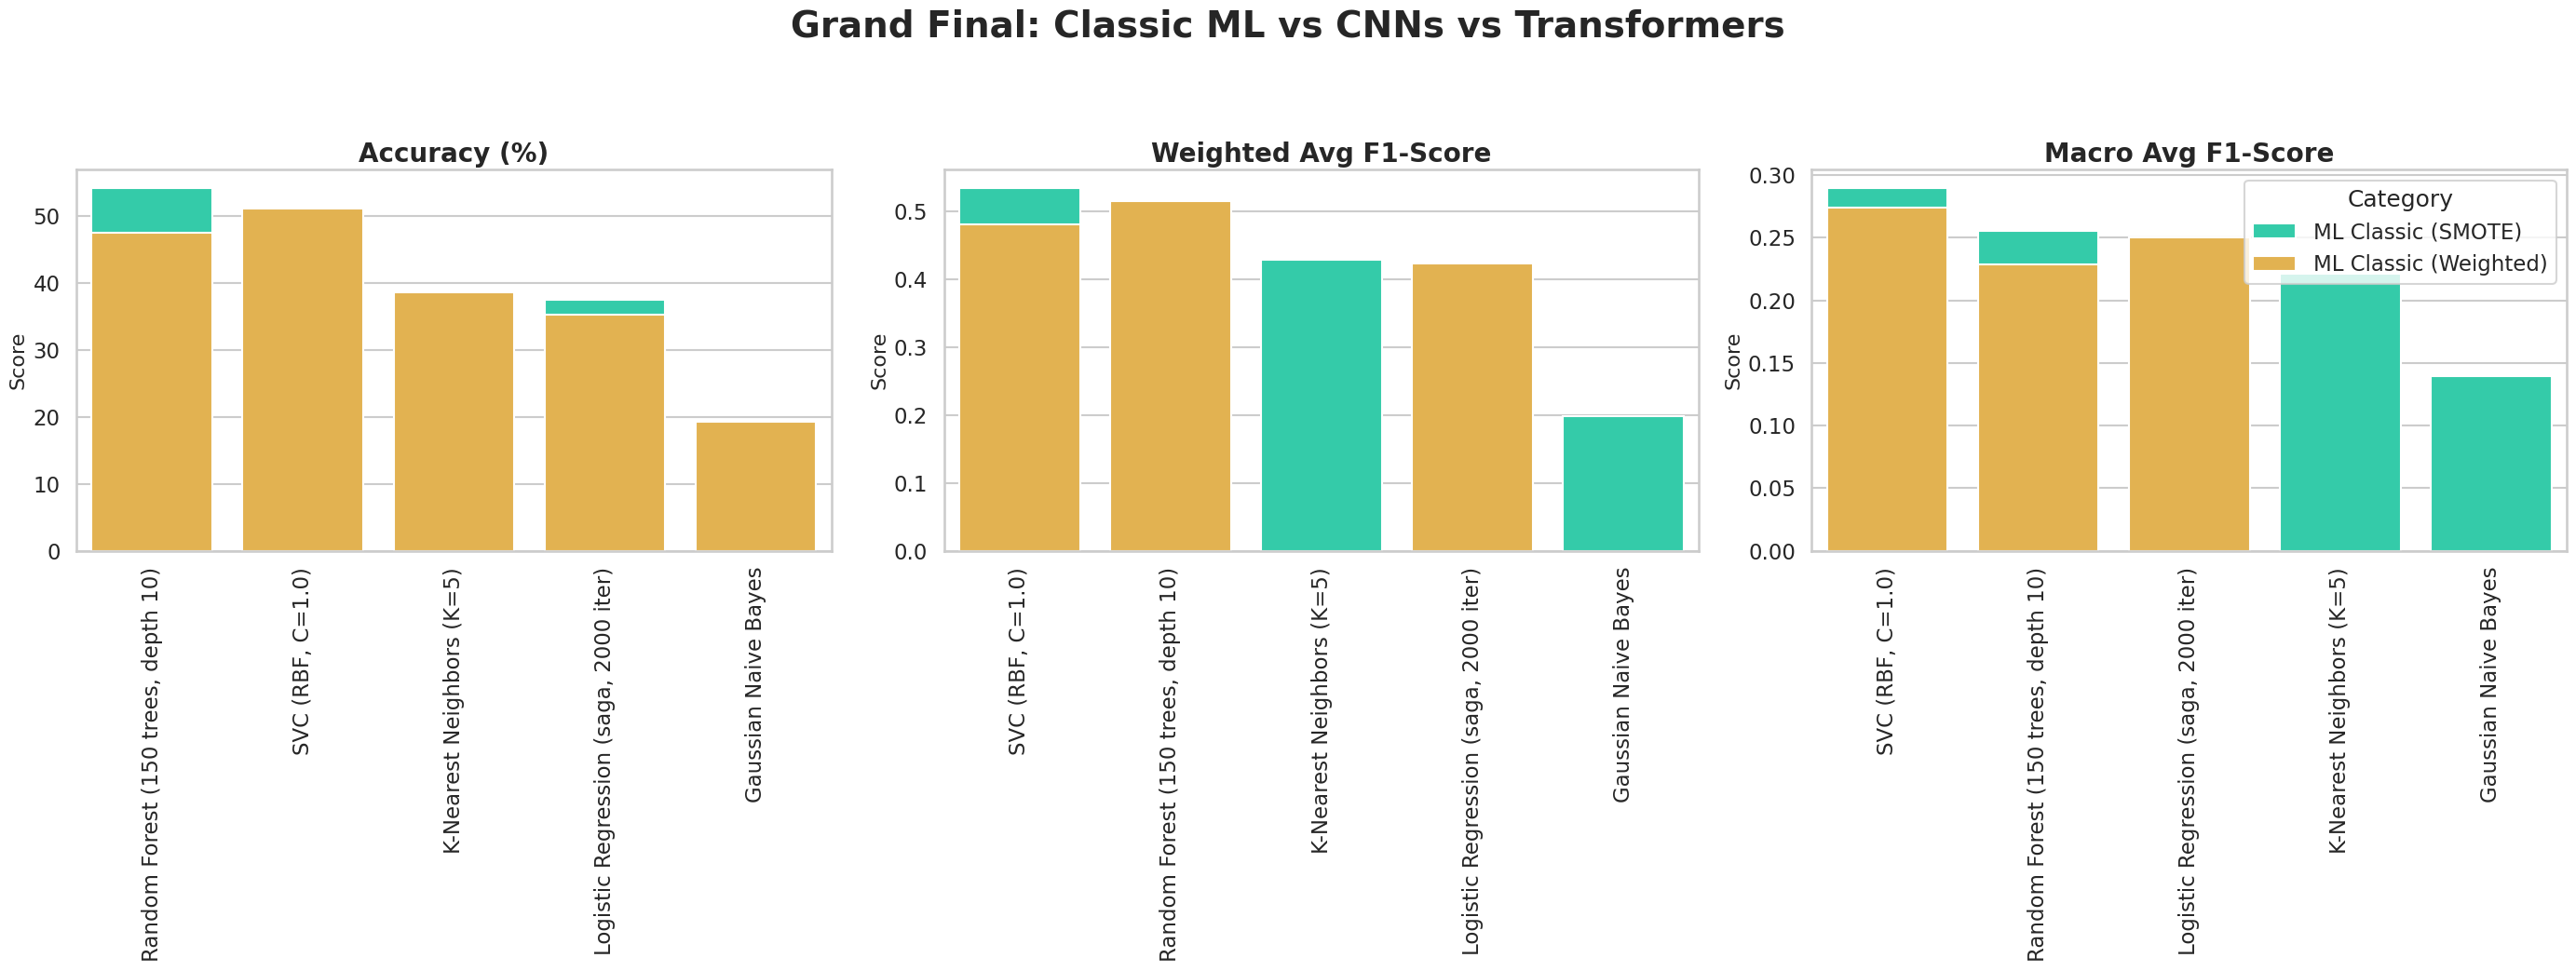

In [28]:
sns.set_theme(style="whitegrid", context="talk")

# 1. Kumpulkan semua hasil
dfs_to_concat = []
if 'results_list_weighted' in locals(): 
    dfs_to_concat.append(pd.DataFrame(results_list_weighted).assign(Kategori='ML Classic (Weighted)'))
if 'results_list_smote' in locals(): 
    dfs_to_concat.append(pd.DataFrame(results_list_smote).assign(Kategori='ML Classic (SMOTE)'))
if 'results_list_dl' in locals(): 
    dfs_to_concat.append(pd.DataFrame(results_list_dl).assign(Kategori='Deep Learning (CNN)'))
if 'results_list_tr' in locals(): 
    dfs_to_concat.append(pd.DataFrame(results_list_tr).assign(Kategori='Transformer'))

if dfs_to_concat:
    df_grand_final = pd.concat(dfs_to_concat, ignore_index=True)
    
    # 2. Tampilkan Tabel Leaderboard (Diurutkan berdasarkan Macro F1)
    print("\n" + "="*80)
    print("🏆 GRAND FINAL LEADERBOARD: PERFORMANCE COMPARISON 🏆")
    print("="*80)
    df_sorted = df_grand_final.sort_values(by="Macro Avg F1-Score", ascending=False)
    
    # Pilih kolom penting saja
    cols_show = ['Model', 'Kategori', 'Accuracy (%)', 'Macro Avg F1-Score', 'Weighted Avg F1-Score']
    print(df_sorted[cols_show].to_markdown(index=False, floatfmt=".3f"))

    # 3. Visualisasi Perbandingan (Bar Plot)
    print("\nGenerating Grand Final Comparison Plots...")
    
    fig, axes = plt.subplots(1, 3, figsize=(28, 10), sharey=False)
    fig.suptitle("Grand Final: Classic ML vs CNNs vs Transformers", y=1.05, fontsize=28, fontweight='bold')
    
    plot_metrics = ["Accuracy (%)", "Weighted Avg F1-Score", "Macro Avg F1-Score"]
    
    for i, metric in enumerate(plot_metrics):
        ax = axes[i]
        # Urutkan visualisasi berdasarkan skor metrik tersebut
        df_plot = df_grand_final.sort_values(by=metric, ascending=False)
        
        sns.barplot(
            data=df_plot,
            x="Model", y=metric, hue="Kategori",
            palette="turbo", # Palet warna kontras tinggi
            ax=ax, dodge=False
        )
        ax.set_title(metric, fontsize=20, fontweight='bold')
        ax.set_xlabel("")
        ax.set_ylabel("Score", fontsize=16)
        ax.tick_params(axis='x', rotation=90) # Putar label agar terbaca
        
        # Hanya tampilkan legenda di plot terakhir agar tidak penuh
        if i < 2: 
            ax.get_legend().remove()
        else:
            ax.legend(title="Category", loc='upper right', bbox_to_anchor=(1.0, 1.0))

    plt.tight_layout()
    plt.show()
    
else:
    print("❌ Data hasil tidak lengkap. Pastikan semua alur kerja (A, B, C) sudah dijalankan.")


🏆 FINAL LEADERBOARD: CLASSIC ML vs DEEP LEARNING (CNN) 🏆
| Model                                 | Kategori              |   Accuracy (%) |   Macro Avg F1-Score |   Weighted Avg F1-Score |
|:--------------------------------------|:----------------------|---------------:|---------------------:|------------------------:|
| SVC (RBF, C=1.0)                      | ML Classic (SMOTE)    |         51.050 |                0.290 |                   0.535 |
| SVC (RBF, C=1.0)                      | ML Classic (Weighted) |         44.943 |                0.274 |                   0.481 |
| Random Forest (150 trees, depth 10)   | ML Classic (SMOTE)    |         47.519 |                0.255 |                   0.496 |
| Logistic Regression (saga, 2000 iter) | ML Classic (Weighted) |         37.500 |                0.250 |                   0.424 |
| Logistic Regression (saga, 2000 iter) | ML Classic (SMOTE)    |         35.210 |                0.231 |                   0.404 |
| Random Forest (1

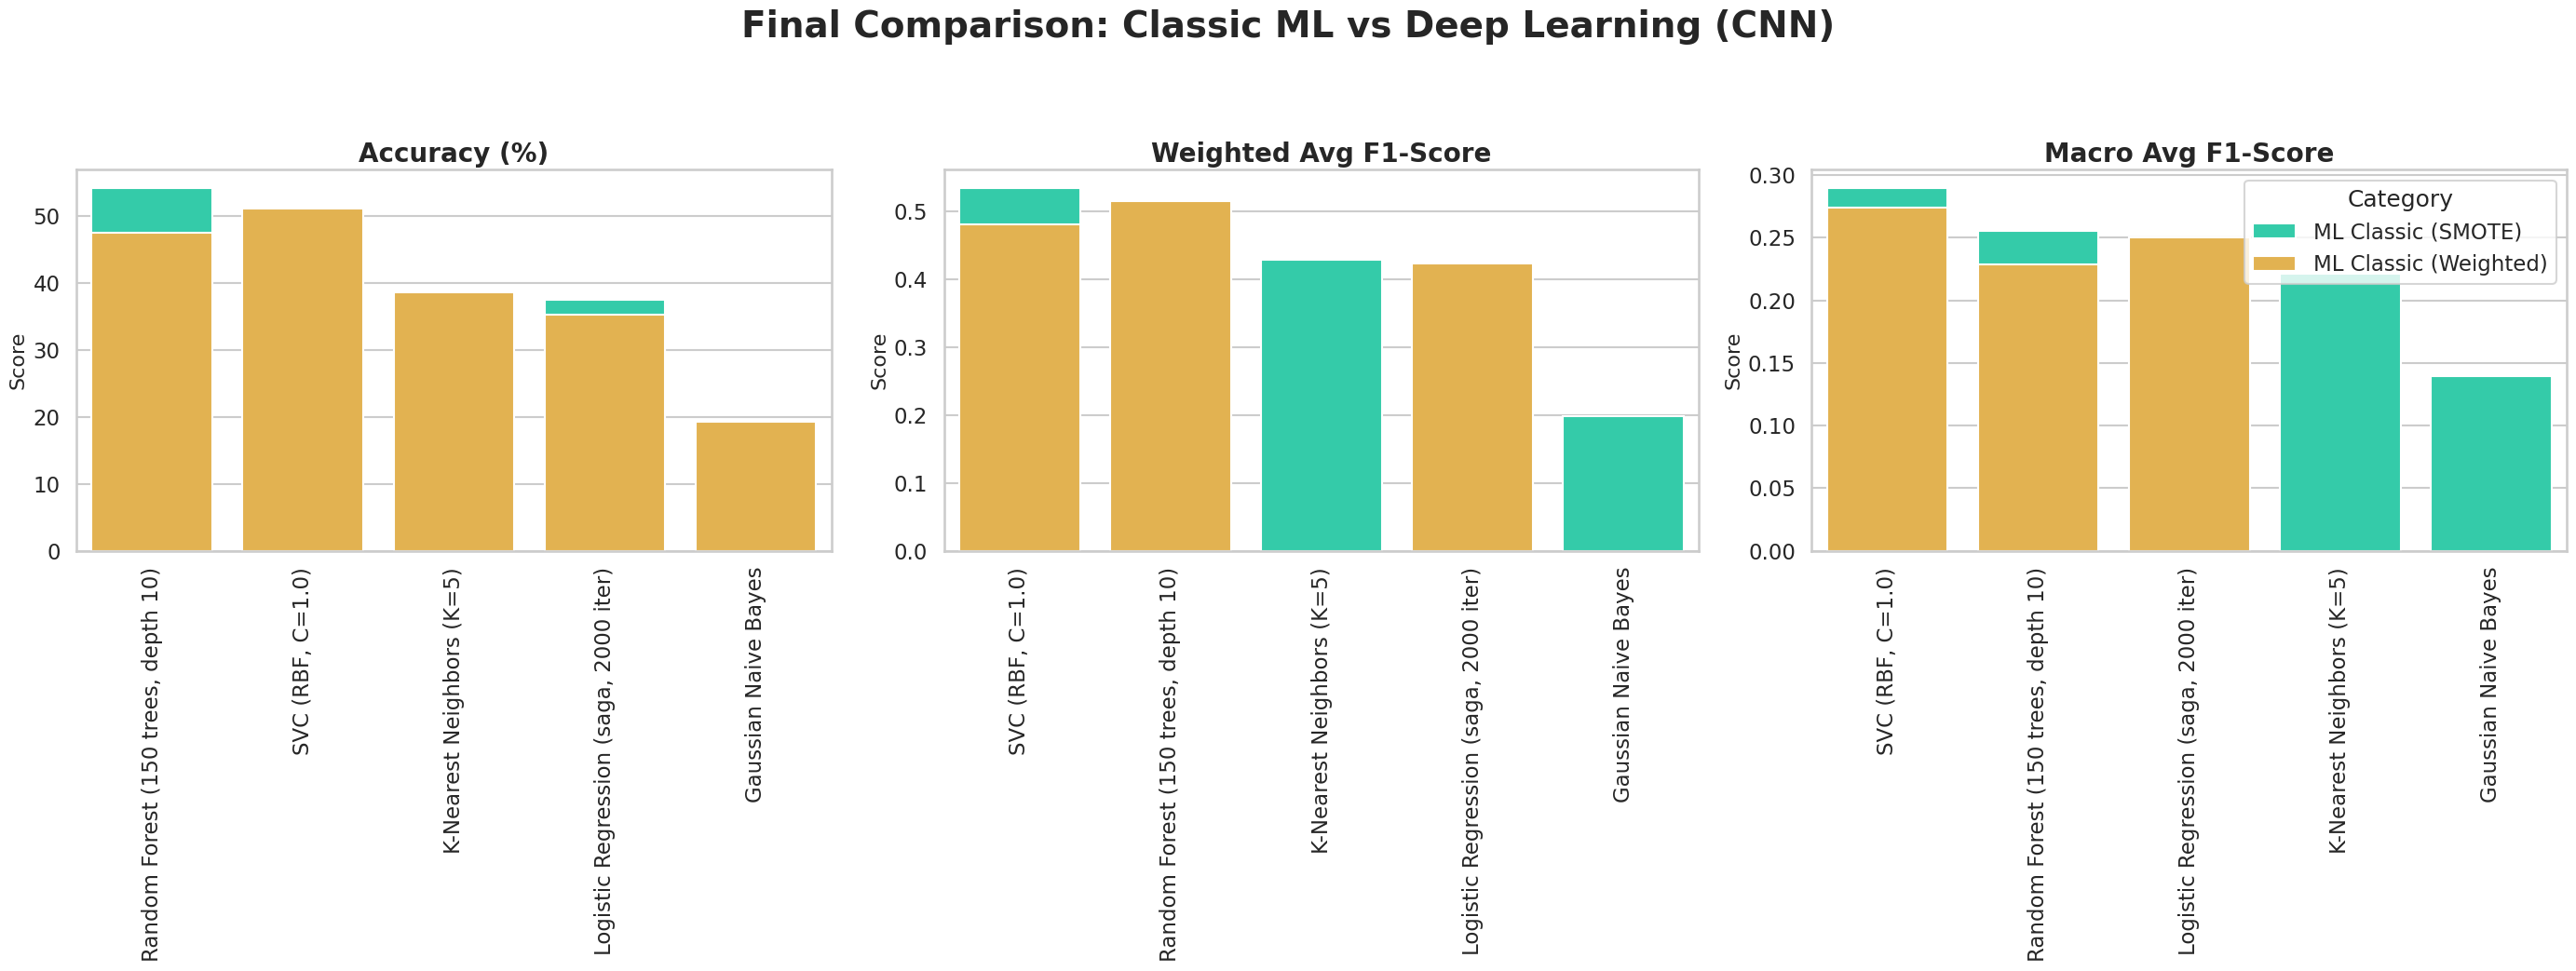

In [ ]:
# ==============================================================================
# PERBANDINGAN AKHIR (ML KLASIK vs DEEP LEARNING CNN)
# ==============================================================================

sns.set_theme(style="whitegrid", context="talk")

# 1. Kumpulkan hasil (HANYA ML Klasik dan DL CNN)
dfs_to_concat = []

# -- Masukkan ML Klasik --
if 'results_list_weighted' in locals(): 
    dfs_to_concat.append(pd.DataFrame(results_list_weighted).assign(Kategori='ML Classic (Weighted)'))
if 'results_list_smote' in locals(): 
    dfs_to_concat.append(pd.DataFrame(results_list_smote).assign(Kategori='ML Classic (SMOTE)'))

# -- Masukkan Deep Learning (CNN) --
if 'results_list_dl' in locals(): 
    dfs_to_concat.append(pd.DataFrame(results_list_dl).assign(Kategori='Deep Learning (CNN)'))

# -- CATATAN: Transformer (results_list_tr) TIDAK dimasukkan --

if dfs_to_concat:
    df_final_comparison = pd.concat(dfs_to_concat, ignore_index=True)
    
    # 2. Tampilkan Tabel Leaderboard (Diurutkan berdasarkan Macro F1)
    print("\n" + "="*80)
    print("🏆 FINAL LEADERBOARD: CLASSIC ML vs DEEP LEARNING (CNN) 🏆")
    print("="*80)
    df_sorted = df_final_comparison.sort_values(by="Macro Avg F1-Score", ascending=False)
    
    # Pilih kolom penting saja
    cols_show = ['Model', 'Kategori', 'Accuracy (%)', 'Macro Avg F1-Score', 'Weighted Avg F1-Score']
    print(df_sorted[cols_show].to_markdown(index=False, floatfmt=".3f"))

    # 3. Visualisasi Perbandingan (Bar Plot)
    print("\nGenerating Comparison Plots...")
    
    fig, axes = plt.subplots(1, 3, figsize=(28, 10), sharey=False)
    # Judul diperbarui
    fig.suptitle("Final Comparison: Classic ML vs Deep Learning (CNN)", y=1.05, fontsize=28, fontweight='bold')
    
    plot_metrics = ["Accuracy (%)", "Weighted Avg F1-Score", "Macro Avg F1-Score"]
    
    for i, metric in enumerate(plot_metrics):
        ax = axes[i]
        # Urutkan visualisasi berdasarkan skor metrik tersebut
        df_plot = df_final_comparison.sort_values(by=metric, ascending=False)
        
        sns.barplot(
            data=df_plot,
            x="Model", y=metric, hue="Kategori",
            palette="turbo", # Palet warna kontras tinggi
            ax=ax, dodge=False
        )
        ax.set_title(metric, fontsize=20, fontweight='bold')
        ax.set_xlabel("")
        ax.set_ylabel("Score", fontsize=16)
        ax.tick_params(axis='x', rotation=90) # Putar label agar terbaca
        
        # Hanya tampilkan legenda di plot terakhir agar tidak penuh
        if i < 2: 
            ax.get_legend().remove()
        else:
            ax.legend(title="Category", loc='upper right', bbox_to_anchor=(1.0, 1.0))

    plt.tight_layout()
    plt.show()
    
else:
    print("❌ Data hasil tidak lengkap. Pastikan alur kerja ML dan DL (CNN) sudah dijalankan.")

### Perbandingan Confusion Matrix & ECE dari Model Terbaik Tiap Kategori


🔬 DEEP DIVE ANALYSIS: CHAMPION MODEL COMPARISON
Juara Terpilih: ['SVC (RBF, C=1.0)']
   🔍 Mengambil data untuk: SVC (RBF, C=1.0) (ML Classic (SMOTE))...


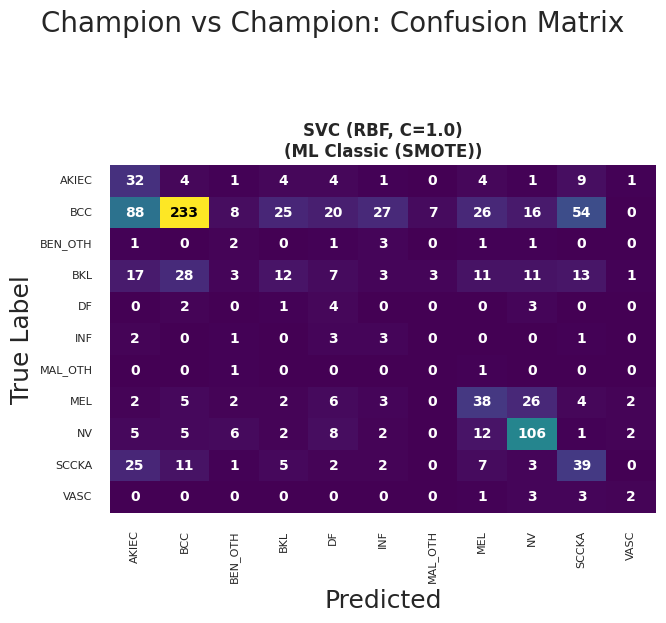


Generating Reliability Diagrams for 1 models...


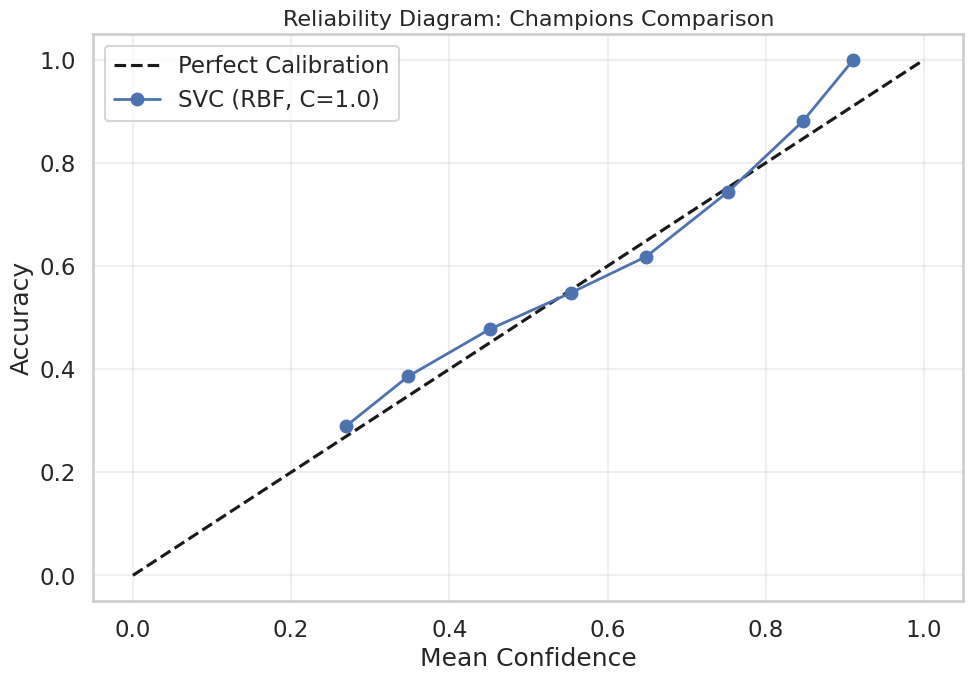

In [30]:
# ==============================================================================
# ANALISIS "CHAMPION vs CHAMPION" (CONFUSION MATRIX & KALIBRASI)
# ==============================================================================
"""
DOKUMENTASI ANALISIS:
Modul ini melakukan 'Deep Dive Analysis' untuk membandingkan performa kualitatif
dan reliabilitas dari model terbaik (Champion) di setiap kategori: 
ML Klasik, Deep Learning (CNN), dan Transformer.

Fitur Utama:
1. Seleksi Otomatis: Memilih model terbaik berdasarkan skor Macro F1 tertinggi.
2. Smart Prediction Fetch: Mekanisme pengambilan data prediksi yang cerdas.
   Jika data prediksi atau probabilitas tidak tersedia di memori (cache), fungsi ini
   akan secara otomatis menjalankan inferensi ulang (force inference) untuk menjamin
   ketersediaan data bagi analisis Confusion Matrix dan Kurva Kalibrasi.
3. Visualisasi Komparatif:
   - Confusion Matrix: Membandingkan pola kesalahan antar arsitektur.
   - Reliability Diagram: Mengevaluasi kepercayaan diri (confidence calibration) model.
"""

import torch
import torch.nn.functional as F
from sklearn.calibration import calibration_curve
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Konfigurasi Device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def annotate_heatmap_manual(ax, cm, cmap='viridis'):
    """
    Menambahkan anotasi angka pada heatmap secara manual untuk menjamin visibilitas.
    Warna teks disesuaikan dengan latar belakang (Putih untuk gelap, Hitam untuk terang).
    """
    sns.heatmap(cm, annot=False, fmt='d', cmap=cmap, ax=ax, cbar=False)
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            text_color = "black" if cm[i, j] > thresh else "white"
            ax.text(j + 0.5, i + 0.5, f'{cm[i, j]}',
                    ha="center", va="center", color=text_color,
                    fontsize=10, fontweight='bold')

def get_predictions_smart_final(model_name, category):
    """
    Mengambil prediksi dan probabilitas model. 
    Melakukan inferensi ulang jika data tidak ditemukan di cache global.
    """
    print(f"   🔍 Mengambil data untuk: {model_name} ({category})...")
    g = globals() 
    
    # --- KATEGORI 1: ML CLASSIC ---
    if 'Classic' in category:
        model = None
        if 'trained_models_weighted' in g and model_name in g['trained_models_weighted']: 
            model = g['trained_models_weighted'][model_name]
        elif 'trained_models_smote' in g and model_name in g['trained_models_smote']: 
            model = g['trained_models_smote'][model_name]
        
        if model:
            preds = model.predict(g['X_val_scaled'])
            try: probs = model.predict_proba(g['X_val_scaled'])
            except: probs = None # Beberapa model ML (e.g. SVM linear) tidak support probs
            return preds, probs, g['y_val_labels']

    # --- KATEGORI 2 & 3: DEEP LEARNING / TRANSFORMER ---
    elif any(x in category for x in ['Deep Learning', 'Transformer', 'CNN']):
        
        # 1. Cari Model
        model = None
        if 'trained_models_dl' in g and model_name in g['trained_models_dl']: 
            model = g['trained_models_dl'][model_name]
        elif 'trained_models_tr' in g and model_name in g['trained_models_tr']: 
            model = g['trained_models_tr'][model_name]
            
        # 2. Cari DataLoader Validasi
        loader = None
        if 'val_loader_dl' in g: loader = g['val_loader_dl']
        elif 'val_loader_tr' in g: loader = g['val_loader_tr']
            
        # 3. Eksekusi Inferensi Ulang (Force Calculation)
        if model and loader:
            print("      🔄 Menjalankan inferensi ulang untuk mendapatkan Probabilitas...")
            model.to(DEVICE)
            model.eval()
            all_preds, all_probs, all_targets = [], [], []
            
            try:
                with torch.no_grad():
                    for inputs, targets in loader:
                        inputs = inputs.to(DEVICE)
                        outputs = model(inputs)
                        all_preds.append(outputs.argmax(1).cpu())
                        all_probs.append(F.softmax(outputs, dim=1).cpu())
                        all_targets.append(targets.cpu())
                
                # Kembalikan model ke CPU untuk menghemat VRAM
                model.cpu()
                return torch.cat(all_preds).numpy(), torch.cat(all_probs).numpy(), torch.cat(all_targets).numpy()
            except Exception as e:
                print(f"      ❌ Error saat inferensi ulang: {e}")
        
        # Fallback: Cek cache lama (jika inferensi gagal)
        print("      ⚠️ Model tidak ditemukan di memori, mencoba cache lama...")
        if 'y_preds_tr' in g and model_name in g['y_preds_tr']:
             return g['y_preds_tr'][model_name].cpu().numpy(), None, None

    print("      ❌ Data tidak ditemukan sama sekali.")
    return None, None, None


# --- EKSEKUSI UTAMA ---
if 'df_grand_final' in locals():
    print("\n" + "="*80)
    print("🔬 DEEP DIVE ANALYSIS: CHAMPION MODEL COMPARISON")
    print("="*80)
    
    # 1. Seleksi Model Terbaik (Champion)
    def get_best_row(category_keyword):
        subset = df_grand_final[df_grand_final['Kategori'].str.contains(category_keyword, case=False, na=False)]
        if not subset.empty:
            return subset.sort_values(by="Macro Avg F1-Score", ascending=False).iloc[0]
        return None

    champ_ml = get_best_row('ML')
    champ_dl = get_best_row('CNN')       
    champ_tr = get_best_row('Transformer')

    champions_data = []
    if champ_ml is not None: champions_data.append((champ_ml['Model'], champ_ml['Kategori']))
    if champ_dl is not None: champions_data.append((champ_dl['Model'], champ_dl['Kategori']))
    if champ_tr is not None: champions_data.append((champ_tr['Model'], champ_tr['Kategori']))
    
    print(f"Juara Terpilih: {[c[0] for c in champions_data]}")

    if not champions_data:
        print("❌ Tidak ada juara yang ditemukan.")
    else:
        # --- PLOT 1: CONFUSION MATRIX ---
        fig, axes = plt.subplots(1, len(champions_data), figsize=(7 * len(champions_data), 6))
        if len(champions_data) == 1: axes = [axes]
        fig.suptitle("Champion vs Champion: Confusion Matrix", y=1.05, fontsize=20)
        
        valid_probs_data = []

        for i, (name, category) in enumerate(champions_data):
            ax = axes[i]
            # Panggil fungsi Smart Fetch
            preds, probs, targets = get_predictions_smart_final(name, category)
            
            if preds is not None and targets is not None:
                # Sinkronisasi panjang data (untuk menangani drop_last batch)
                min_len = min(len(preds), len(targets))
                preds = preds[:min_len]
                targets = targets[:min_len]
                
                if probs is not None: 
                    probs = probs[:min_len]
                    valid_probs_data.append((name, probs, targets))

                # Visualisasi Heatmap
                cm = confusion_matrix(targets, preds)
                annotate_heatmap_manual(ax, cm, cmap='viridis')
                ax.set_title(f"{name}\n({category})", fontsize=12, fontweight='bold')
                ax.set_xlabel("Predicted")
                ax.set_ylabel("True Label")
                if 'DIAGNOSIS_COLUMNS' in locals():
                    ax.set_xticklabels(DIAGNOSIS_COLUMNS, rotation=90, fontsize=8)
                    ax.set_yticklabels(DIAGNOSIS_COLUMNS, rotation=0, fontsize=8)
            else:
                ax.text(0.5, 0.5, "Data Missing", ha='center', va='center')
                
        plt.tight_layout()
        plt.show()

        # --- PLOT 2: DIAGRAM KALIBRASI ---
        if valid_probs_data:
            print(f"\nGenerating Reliability Diagrams for {len(valid_probs_data)} models...")
            plt.figure(figsize=(10, 7))
            plt.plot([0, 1], [0, 1], 'k--', label="Perfect Calibration")
            
            for name, probs, targets in valid_probs_data:
                y_confidences = np.max(probs, axis=1)
                y_correct = (np.argmax(probs, axis=1) == targets)
                
                frac_pos, mean_val = calibration_curve(y_correct, y_confidences, n_bins=10)
                plt.plot(mean_val, frac_pos, 'o-', label=f"{name}", linewidth=2)
                
            plt.title("Reliability Diagram: Champions Comparison", fontsize=16)
            plt.xlabel("Mean Confidence")
            plt.ylabel("Accuracy")
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.show()
        else:
            print("\n⚠️ Tidak ada data probabilitas yang tersedia untuk Plot Kalibrasi.")
else:
    print("❌ DataFrame Grand Final tidak ditemukan.")

### Error Analysis (Confusing Pairs & Visualization Errors)

   🔍 Mengambil data untuk: SVC (RBF, C=1.0) (ML Classic (SMOTE))...

🔍 ERROR ANALYSIS: SVC (RBF, C=1.0)

📋 Top 10 Paling Sering Tertukar (Confused Pairs):
| True Class   | Predicted   |   Error Count |
|:-------------|:------------|--------------:|
| BCC          | AKIEC       |            88 |
| BCC          | SCCKA       |            54 |
| BKL          | BCC         |            28 |
| BCC          | INF         |            27 |
| BCC          | MEL         |            26 |
| MEL          | NV          |            26 |
| BCC          | BKL         |            25 |
| SCCKA        | AKIEC       |            25 |
| BCC          | DF          |            20 |
| BKL          | AKIEC       |            17 |


/tmp/ipykernel_328458/2523171773.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_confused, x='Error Count',


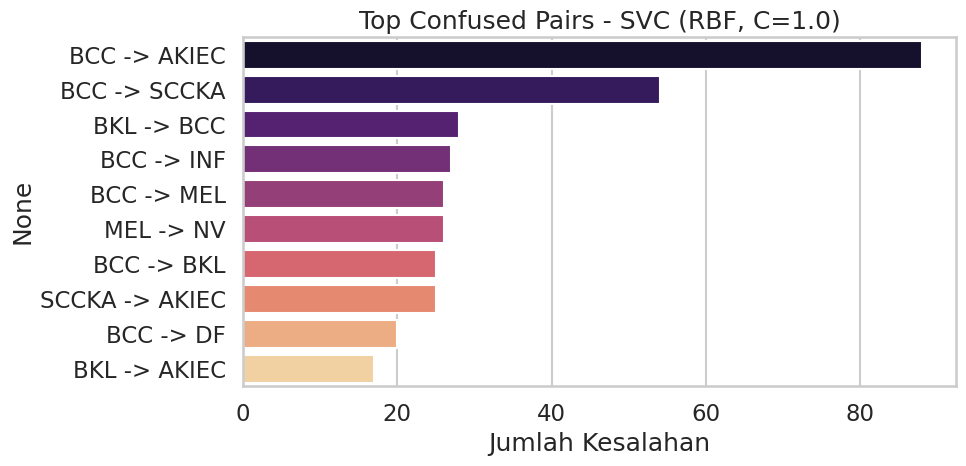


🖼️ Top 5 'High Confidence Errors' (Salah Tapi Yakin):


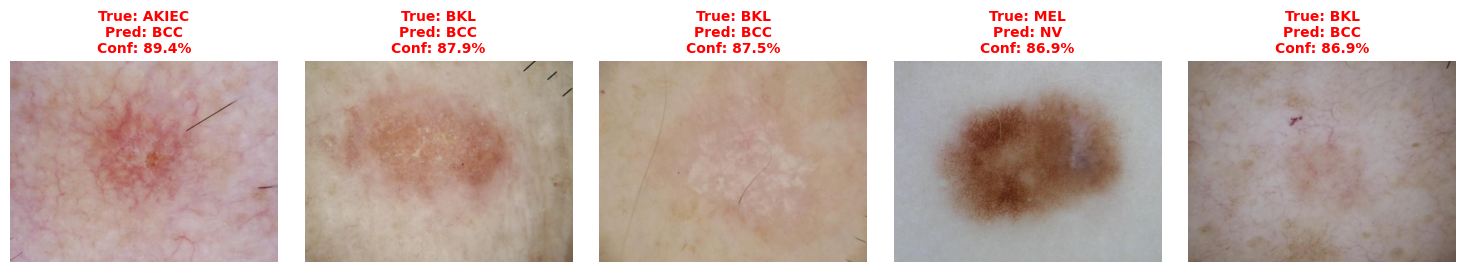

In [31]:
# ==============================================================================
# ERROR ANALYSIS (CONFUSED PAIRS & VISUALISASI)
# ==============================================================================
"""
DOKUMENTASI ANALISIS ERROR:
Modul ini melakukan investigasi kualitatif terhadap kegagalan model.

1. Top Confused Pairs (Kuantitatif):
   Mengidentifikasi pasangan kelas (Ground Truth vs Prediksi) yang paling sering 
   salah diklasifikasikan. Ini membantu mendeteksi bias sistematis (misal: 
   BCC sering dikira NV).

2. Worst Failures / High Confidence Errors (Kualitatif):
   Menampilkan sampel gambar di mana model melakukan kesalahan prediksi namun 
   dengan tingkat kepercayaan (confidence score) yang sangat tinggi. 
   Ini adalah kesalahan "fatal" yang perlu diinspeksi secara visual.
"""

import matplotlib.gridspec as gridspec
from sklearn.metrics import confusion_matrix
from PIL import Image 

def analyze_errors(model_name, preds, probs, targets, df_val, class_names=DIAGNOSIS_COLUMNS):
    """Menjalankan analisis error lengkap untuk satu model."""
    
    print(f"\n{'='*80}")
    print(f"🔍 ERROR ANALYSIS: {model_name}")
    print(f"{'='*80}")
    
    # Normalisasi input ke numpy array
    if torch.is_tensor(preds): preds = preds.cpu().numpy()
    if torch.is_tensor(targets): targets = targets.cpu().numpy()
    if probs is not None and torch.is_tensor(probs): probs = probs.cpu().numpy()
    
    # ---------------------------------------------------------
    # BAGIAN 1: TOP CONFUSED PAIRS
    # ---------------------------------------------------------
    cm = confusion_matrix(targets, preds)
    np.fill_diagonal(cm, 0) # Abaikan prediksi yang benar
    
    pairs = []
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            if cm[i, j] > 0:
                pairs.append({
                    'True Class': class_names[i],
                    'Predicted': class_names[j],
                    'Error Count': cm[i, j]
                })
    
    # Tampilkan Top 10 Error
    if pairs:
        df_confused = pd.DataFrame(pairs).sort_values(by='Error Count', ascending=False).head(10)
        print("\n📋 Top 10 Paling Sering Tertukar (Confused Pairs):")
        print(df_confused.to_markdown(index=False))
        
        # Visualisasi Bar Plot
        plt.figure(figsize=(10, 5))
        sns.barplot(data=df_confused, x='Error Count', 
                    y=df_confused.apply(lambda x: f"{x['True Class']} -> {x['Predicted']}", axis=1), 
                    palette='magma')
        plt.title(f"Top Confused Pairs - {model_name}")
        plt.xlabel("Jumlah Kesalahan")
        plt.tight_layout()
        plt.show()
    else:
        print("✅ Model sempurna! Tidak ada kesalahan yang ditemukan.")
    
    # ---------------------------------------------------------
    # BAGIAN 2: VISUALISASI "WORST FAILURES"
    # ---------------------------------------------------------
    if probs is not None:
        pred_confidences = np.max(probs, axis=1)
        incorrect_indices = np.where(preds != targets)[0]
        
        if len(incorrect_indices) > 0:
            incorrect_confidences = pred_confidences[incorrect_indices]
            
            # Urutkan berdasarkan confidence tertinggi (paling "yakin" tapi salah)
            sorted_idx_relative = np.argsort(incorrect_confidences)[::-1]
            top_fail_indices = incorrect_indices[sorted_idx_relative][:5] 
            
            print(f"\n🖼️ Top 5 'High Confidence Errors' (Salah Tapi Yakin):")
            
            fig = plt.figure(figsize=(15, 4))
            
            for i, idx in enumerate(top_fail_indices):
                ax = fig.add_subplot(1, 5, i+1)
                
                # Ambil path gambar dari DataFrame Validasi
                img_path = df_val.iloc[idx]['dermoscopic_full_path']
                
                try:
                    img = Image.open(img_path)
                    ax.imshow(img)
                except Exception:
                    ax.text(0.5, 0.5, "Image Not Found", ha='center')
                
                true_cls = class_names[targets[idx]]
                pred_cls = class_names[preds[idx]]
                conf = pred_confidences[idx] * 100
                
                ax.set_title(f"True: {true_cls}\nPred: {pred_cls}\nConf: {conf:.1f}%", 
                             color='red', fontsize=10, fontweight='bold')
                ax.axis('off')
            
            plt.tight_layout()
            plt.show()
        else:
            print("✅ Tidak ada prediksi yang salah untuk divisualisasikan.")
    else:
        print("⚠️ Visualisasi 'High Confidence Errors' dilewati (Probabilitas tidak tersedia).")


# --- EKSEKUSI PADA MODEL JUARA ---
if 'champions_data' in locals() and 'val_df' in locals():
    for name, category in champions_data:
        # Gunakan fungsi smart fetch dari SEL 23
        preds, probs, targets = get_predictions_smart_final(name, category)
        
        if preds is not None and targets is not None:
            # Sinkronisasi panjang data
            min_len = min(len(preds), len(targets))
            preds = preds[:min_len]
            targets = targets[:min_len]
            if probs is not None: probs = probs[:min_len]
            
            analyze_errors(name, preds, probs, targets, val_df, DIAGNOSIS_COLUMNS)
else:
    print("❌ Data Juara atau DataFrame Validasi tidak ditemukan. Pastikan SEL 23 telah dijalankan.")

## Kode Saving Model (Universal)

In [32]:
# ==============================================================================
# MODUL PENYIMPANAN MODEL (SAVING ARTIFACTS)
# ==============================================================================
import os

"""
DOKUMENTASI TEKNIS:
Modul ini menyimpan 'state_dict' (bobot parameter) dari seluruh model eksperimen 
ke direktori eksternal '../Models' agar terpisah dari kode sumber.

Mekanisme Path:
- Path '../Models' berarti folder 'Models' akan dibuat satu level di atas 
  folder tempat notebook ini berada. 
- Ini berguna untuk menjaga struktur proyek tetap rapi (Code & Artifacts terpisah).

Format Penyimpanan:
- Menggunakan format standar PyTorch (.pth).
- Nama file disanitasi dari spasi/karakter khusus (misal: 'ResNet50 (LoRA)' -> 'ResNet50_LoRA.pth').
"""

def save_experiment_models(model_dictionaries, output_folder="../Models"):
    """
    Menyimpan semua model dalam dictionary ke path target.
    
    Args:
        model_dictionaries (list): List berisi dictionary model (misal: [models_dl, models_vit]).
        output_folder (str): Path direktori tujuan (default: '../Models').
    """
    # 1. Buat Folder Secara Rekursif (jika belum ada)
    if not os.path.exists(output_folder):
        try:
            os.makedirs(output_folder)
            print(f"📂 Membuat direktori baru: '{output_folder}'")
        except OSError as e:
            print(f"❌ Gagal membuat direktori {output_folder}: {e}")
            return
    else:
        print(f"📂 Direktori target ditemukan: '{output_folder}'")

    print("="*60)
    
    count = 0
    # 2. Iterasi melalui setiap dictionary model yang ada
    for model_dict in model_dictionaries:
        if not model_dict: continue # Skip jika dict kosong
            
        for name, model in model_dict.items():
            # Sanitasi nama file agar aman untuk OS
            safe_name = name.replace(" ", "_").replace("(", "").replace(")", "").replace("-", "_")
            filename = f"{safe_name}.pth"
            save_path = os.path.join(output_folder, filename)
            
            try:
                # 3. Simpan State Dict (Bobot Model)
                # Logika khusus: Jika model adalah Wrapper ViT, ambil model aslinya (.hf_model)
                if hasattr(model, 'hf_model'): 
                    torch.save(model.hf_model.state_dict(), save_path)
                else:
                    torch.save(model.state_dict(), save_path)
                
                # Cek ukuran file untuk konfirmasi
                if os.path.exists(save_path):
                    file_size_mb = os.path.getsize(save_path) / (1024 * 1024)
                    print(f"💾 Berhasil menyimpan: {filename:<30} | Lokasi: {save_path} | Ukuran: {file_size_mb:.2f} MB")
                    count += 1
                
            except Exception as e:
                print(f"❌ Gagal menyimpan {name}: {e}")

    print("="*60)
    print(f"✅ Total {count} model berhasil diamankan di '{output_folder}'.")

# ==============================================================================
# EKSEKUSI PENYIMPANAN
# ==============================================================================

# Kumpulkan dictionary model yang ada di memori
dicts_to_save = []

# Cek keberadaan variabel model CNN
if 'models_to_train_dl' in locals():
    dicts_to_save.append(models_to_train_dl)

# Cek keberadaan variabel model Transformer
if 'models_to_train_vit' in locals():
    dicts_to_save.append(models_to_train_vit)

# Jalankan fungsi save ke path '../Models'
if dicts_to_save:
    save_experiment_models(dicts_to_save, output_folder="../Models")
else:
    print("⚠️ Tidak ada variabel model (models_to_train_dl/vit) yang ditemukan di memori untuk disimpan.")

📂 Direktori target ditemukan: '../Models'
💾 Berhasil menyimpan: CustomCNN_Scratch.pth          | Lokasi: ../Models/CustomCNN_Scratch.pth | Ukuran: 0.50 MB
💾 Berhasil menyimpan: ResNet50_Frozen.pth            | Lokasi: ../Models/ResNet50_Frozen.pth | Ukuran: 90.07 MB
💾 Berhasil menyimpan: ResNet50_FullFT.pth            | Lokasi: ../Models/ResNet50_FullFT.pth | Ukuran: 90.07 MB
💾 Berhasil menyimpan: ResNet50_LoRA.pth              | Lokasi: ../Models/ResNet50_LoRA.pth | Ukuran: 90.75 MB
💾 Berhasil menyimpan: VGG16_Frozen.pth               | Lokasi: ../Models/VGG16_Frozen.pth | Ukuran: 512.35 MB
💾 Berhasil menyimpan: VGG16_FullFT.pth               | Lokasi: ../Models/VGG16_FullFT.pth | Ukuran: 512.35 MB
💾 Berhasil menyimpan: VGG16_LoRA.pth                 | Lokasi: ../Models/VGG16_LoRA.pth | Ukuran: 513.15 MB
💾 Berhasil menyimpan: EffNetB0_Frozen.pth            | Lokasi: ../Models/EffNetB0_Frozen.pth | Ukuran: 15.63 MB
💾 Berhasil menyimpan: EffNetB0_FullFT.pth            | Lokasi: ../Model

## Academic Poster Content

### Visualisasi Metodologi (Data Distribution)

📂 Membuat folder baru: 'image'

🎨 Generating plot (ID)...


/tmp/ipykernel_328458/138400149.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=class_counts.index, y=class_counts.values, palette="mako")


✅ Gambar disimpan: image/Fig1_Distribusi_Data_Indo.png


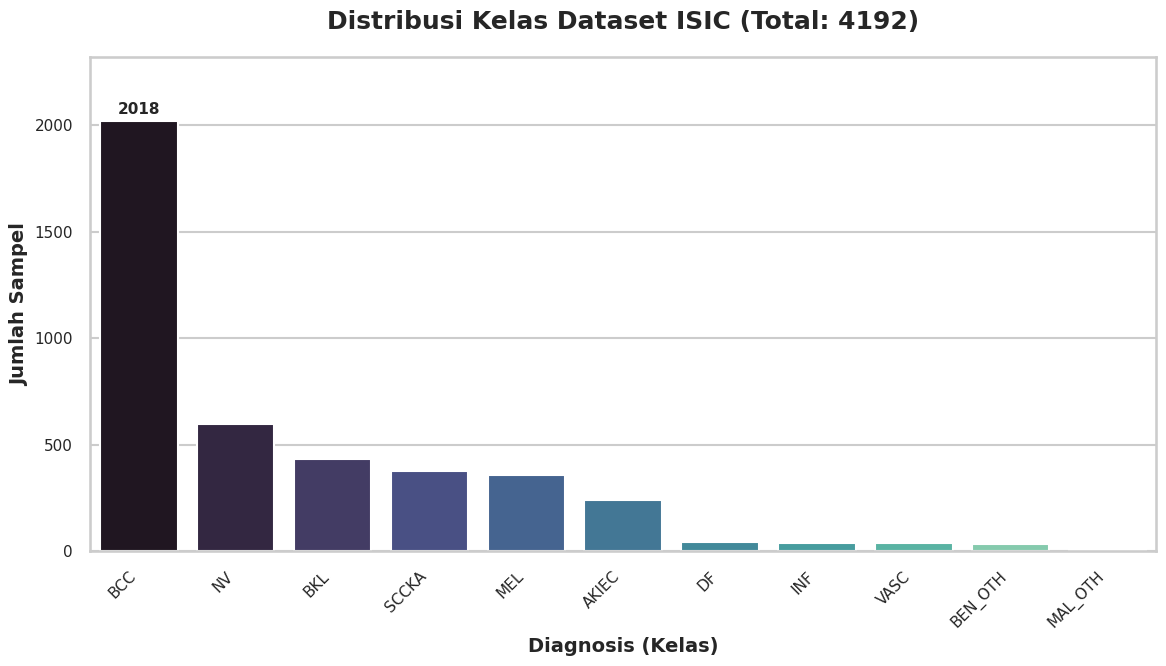


🎨 Generating plot (EN)...


/tmp/ipykernel_328458/138400149.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=class_counts.index, y=class_counts.values, palette="mako")


✅ Gambar disimpan: image/Fig1_Data_Distribution_English.png


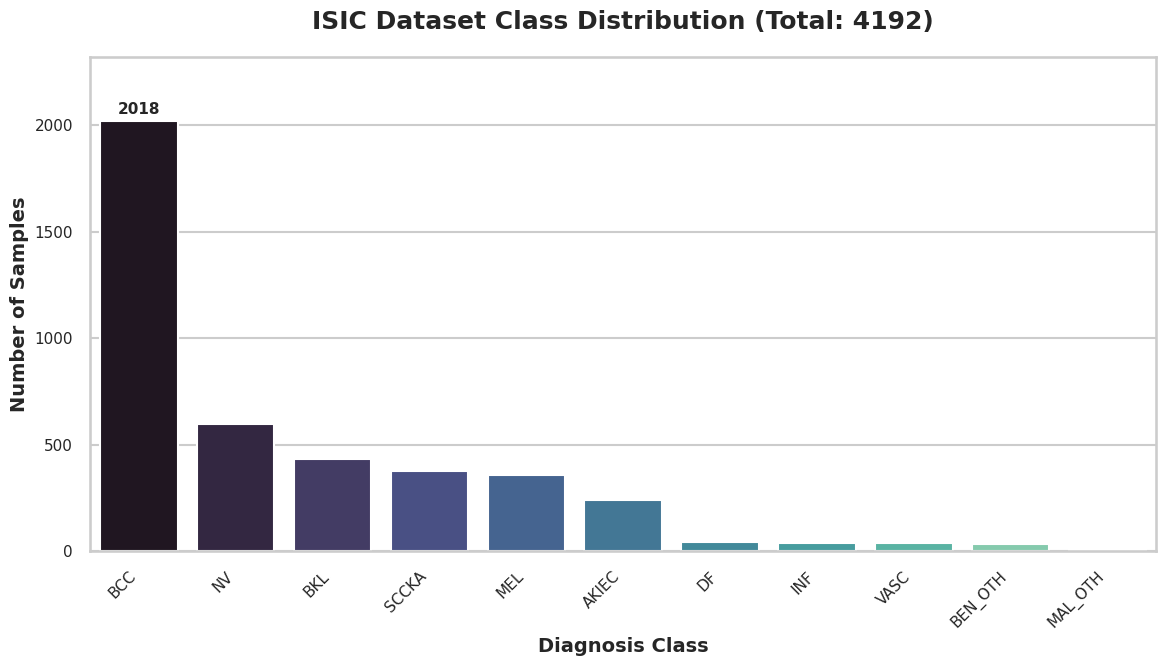

✅ File deskripsi disimpan: image/Fig1_Caption_Deskripsi.txt

[CAPTION - INDONESIA]
Gambar 1. Distribusi Kelas Dataset ISIC. Grafik menunjukkan ketidakseimbangan data yang signifikan pada 11 kategori diagnosis. Kelas mayoritas 'BCC' mendominasi dengan 2018 sampel.

[CAPTION - ENGLISH]
Figure 1. Class Distribution of the ISIC Dataset. The bar chart illustrates significant class imbalance across 11 diagnostic categories. The majority class 'BCC' dominates with 2018 samples.




In [40]:
# ==============================================================================
# 1. VISUALISASI DISTRIBUSI DATA (UNTUK BAGIAN METHODOLOGY)
# ==============================================================================
# ==============================================================================
# 1. VISUALISASI DISTRIBUSI DATA (DUAL BAHASA -> FOLDER IMAGE)
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os

def plot_data_distribution_dual_lang(df, column_list):
    # 1. Setup Folder Penyimpanan
    output_folder = "image"
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
        print(f"📂 Membuat folder baru: '{output_folder}'")
    
    # 2. Hitung Statistik Data
    class_counts = df[column_list].sum().sort_values(ascending=False)
    total_samples = int(class_counts.sum())
    
    # 3. Konfigurasi Bahasa (Indo & English)
    configs = [
        {
            "lang": "ID",
            "filename": "Fig1_Distribusi_Data_Indo.png",
            "title": f"Distribusi Kelas Dataset ISIC (Total: {total_samples})",
            "xlabel": "Diagnosis (Kelas)",
            "ylabel": "Jumlah Sampel",
            "caption_header": "[CAPTION - INDONESIA]"
        },
        {
            "lang": "EN",
            "filename": "Fig1_Data_Distribution_English.png",
            "title": f"ISIC Dataset Class Distribution (Total: {total_samples})",
            "xlabel": "Diagnosis Class",
            "ylabel": "Number of Samples",
            "caption_header": "[CAPTION - ENGLISH]"
        }
    ]

    # 4. Loop untuk membuat 2 Gambar
    caption_content = ""
    
    for config in configs:
        print(f"\n🎨 Generating plot ({config['lang']})...")
        
        plt.figure(figsize=(12, 7))
        sns.set_style("whitegrid")
        
        # Plot Bar Chart
        ax = sns.barplot(x=class_counts.index, y=class_counts.values, palette="mako")
        
        # Formatting Label & Judul Sesuai Bahasa
        plt.title(config['title'], fontsize=18, fontweight='bold', pad=20)
        plt.xlabel(config['xlabel'], fontsize=14, fontweight='bold')
        plt.ylabel(config['ylabel'], fontsize=14, fontweight='bold')
        
        # Ticks
        plt.xticks(rotation=45, ha='right', fontsize=11)
        plt.yticks(fontsize=11)
        
        # Angka di atas bar (Integer)
        ax.bar_label(ax.containers[0], fmt='%d', padding=3, fontsize=11, fontweight='bold')
        
        # Batas atas Y axis (+15%)
        plt.ylim(0, class_counts.values.max() * 1.15)
        
        plt.tight_layout()
        
        # Simpan ke Folder 'image'
        save_path = os.path.join(output_folder, config['filename'])
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✅ Gambar disimpan: {save_path}")
        plt.show()
        
        # Tambahkan ke text caption
        caption_content += f"{config['caption_header']}\n"
        if config['lang'] == 'ID':
            caption_content += f"Gambar 1. Distribusi Kelas Dataset ISIC. Grafik menunjukkan ketidakseimbangan data yang signifikan pada 11 kategori diagnosis. Kelas mayoritas '{class_counts.index[0]}' mendominasi dengan {int(class_counts.values[0])} sampel.\n\n"
        else:
            caption_content += f"Figure 1. Class Distribution of the ISIC Dataset. The bar chart illustrates significant class imbalance across 11 diagnostic categories. The majority class '{class_counts.index[0]}' dominates with {int(class_counts.values[0])} samples.\n\n"

    # 5. Simpan File Caption di folder yang sama
    caption_path = os.path.join(output_folder, "Fig1_Caption_Deskripsi.txt")
    with open(caption_path, "w") as f:
        f.write(caption_content.strip())
        
    print(f"✅ File deskripsi disimpan: {caption_path}")
    print("\n" + "="*60)
    print(caption_content)

# --- EKSEKUSI ---
if 'train_df' in locals() and 'DIAGNOSIS_COLUMNS' in locals():
    plot_data_distribution_dual_lang(train_df, DIAGNOSIS_COLUMNS)
else:
    print("❌ Variabel 'train_df' atau 'DIAGNOSIS_COLUMNS' tidak ditemukan.")

### Kurva Pembelajaran (Training Dynamics)

🏆 Champions Found:
   - ML Classic: Random Forest (150 trees, depth 10) (54.20%)
   - CNN: ResNet50_FullFT (63.65%)
   - Transformer: Swin_FullFT (69.85%)
✅ Gambar disimpan: image/Fig2_Dinamika_Training_Indo.png


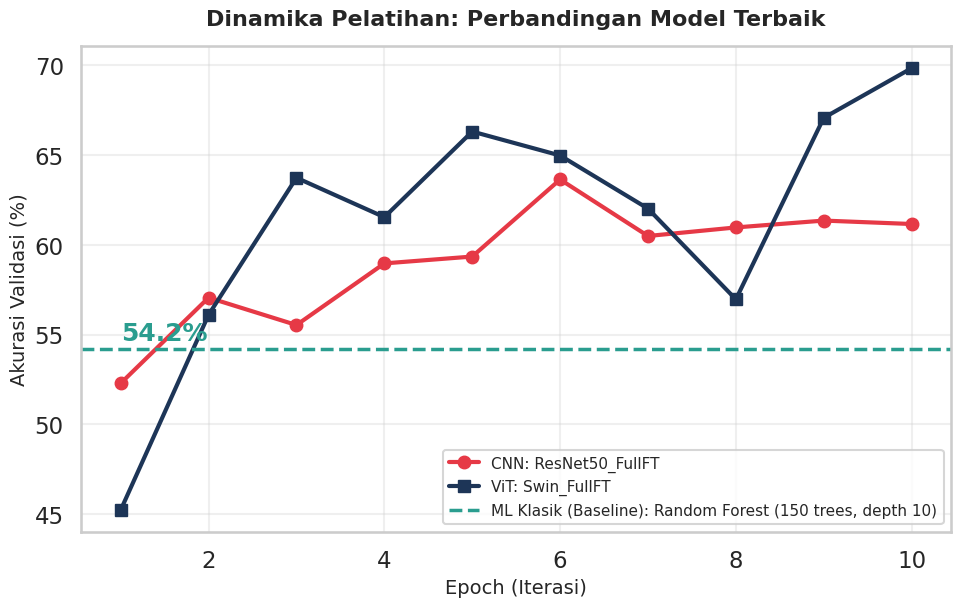

✅ Gambar disimpan: image/Fig2_Training_Dynamics_English.png


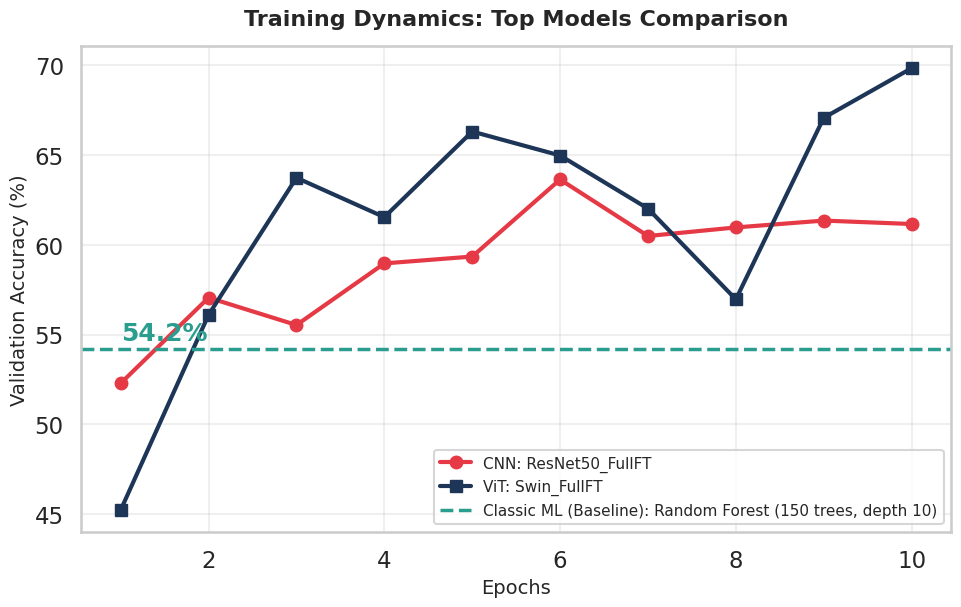

✅ File caption disimpan: image/Fig2_Caption_Training.txt

[CAPTION - INDONESIA]
Gambar 2. Dinamika Pelatihan Model Terbaik. Garis merah dan biru menunjukkan peningkatan akurasi validasi seiring bertambahnya epoch untuk model Deep Learning (CNN) dan Transformer. Garis putus-putus hijau menunjukkan performa model Machine Learning Klasik (Random Forest (150 trees, depth 10)) sebagai baseline perbandingan.

[CAPTION - ENGLISH]
Figure 2. Training Dynamics of Top Performing Models. The red and blue curves illustrate the validation accuracy progression over epochs for the best Deep Learning (CNN) and Transformer models. The green dashed line represents the Classic Machine Learning (Random Forest (150 trees, depth 10)) performance as a baseline.




In [41]:
# ==============================================================================
# 2. VISUALISASI TRAINING CURVES (BEST OF THE BEST: ML vs CNN vs ViT)
# ==============================================================================
# ==============================================================================
# 2. VISUALISASI TRAINING CURVES (BEST OF THE BEST: ML vs CNN vs ViT)
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd

def find_champion_model(history_dict):
    """Mencari nama model dengan akurasi validasi tertinggi dari dictionary history"""
    if not history_dict: return None, None, []
    
    best_name = None
    best_score = -1
    best_curve = []
    
    for name, hist in history_dict.items():
        if hist['val_acc']:
            current_max = max(hist['val_acc'])
            if current_max > best_score:
                best_score = current_max
                best_name = name
                best_curve = hist['val_acc']
                
    return best_name, best_score, best_curve

def plot_grand_comparison_curves(hist_dl, hist_vit, ml_results_list=None):
    # 1. Setup Folder
    output_folder = "image"
    if not os.path.exists(output_folder): os.makedirs(output_folder)
    
    # 2. Cari Para Juara (Champions)
    cnn_name, cnn_score, cnn_curve = find_champion_model(hist_dl)
    vit_name, vit_score, vit_curve = find_champion_model(hist_vit)
    
    # Cari Juara ML Klasik (Jika ada)
    ml_name, ml_score = None, 0
    if ml_results_list:
        # Asumsi ml_results_list adalah list of dicts seperti di Alur Kerja A
        # Kita cari yang akurasinya paling tinggi
        df_ml = pd.DataFrame(ml_results_list)
        # Pastikan nama kolom sesuai (Accuracy atau Accuracy (%))
        col_acc = 'Accuracy (%)' if 'Accuracy (%)' in df_ml.columns else 'Accuracy'
        if col_acc in df_ml.columns:
            best_row = df_ml.loc[df_ml[col_acc].idxmax()]
            ml_name = best_row['Model']
            ml_score = best_row[col_acc]

    print(f"🏆 Champions Found:")
    if ml_name: print(f"   - ML Classic: {ml_name} ({ml_score:.2f}%)")
    if cnn_name: print(f"   - CNN: {cnn_name} ({cnn_score:.2f}%)")
    if vit_name: print(f"   - Transformer: {vit_name} ({vit_score:.2f}%)")

    # 3. Konfigurasi Bahasa
    configs = [
        {
            "lang": "ID",
            "filename": "Fig2_Dinamika_Training_Indo.png",
            "title": "Dinamika Pelatihan: Perbandingan Model Terbaik",
            "xlabel": "Epoch (Iterasi)",
            "ylabel": "Akurasi Validasi (%)",
            "label_ml": "ML Klasik (Baseline)"
        },
        {
            "lang": "EN",
            "filename": "Fig2_Training_Dynamics_English.png",
            "title": "Training Dynamics: Top Models Comparison",
            "xlabel": "Epochs",
            "ylabel": "Validation Accuracy (%)",
            "label_ml": "Classic ML (Baseline)"
        }
    ]
    
    caption_content = ""

    # 4. Loop Plotting
    for config in configs:
        plt.figure(figsize=(10, 6))
        sns.set_style("whitegrid")
        
        # Plot CNN Curve
        if cnn_name:
            epochs = range(1, len(cnn_curve) + 1)
            plt.plot(epochs, cnn_curve, linewidth=3, label=f"CNN: {cnn_name}", color='#E63946', marker='o')
            
        # Plot Transformer Curve
        if vit_name:
            epochs = range(1, len(vit_curve) + 1)
            plt.plot(epochs, vit_curve, linewidth=3, label=f"ViT: {vit_name}", color='#1D3557', marker='s')
            
        # Plot ML Classic (Sebagai Garis Horizontal/Baseline)
        if ml_name:
            plt.axhline(y=ml_score, color='#2A9D8F', linestyle='--', linewidth=2.5, 
                        label=f"{config['label_ml']}: {ml_name}")
            # Tambah teks kecil di pinggir garis
            plt.text(1, ml_score + 0.5, f"{ml_score:.1f}%", color='#2A9D8F', fontweight='bold')

        # Styling
        plt.title(config['title'], fontsize=16, fontweight='bold', pad=15)
        plt.xlabel(config['xlabel'], fontsize=14)
        plt.ylabel(config['ylabel'], fontsize=14)
        plt.legend(fontsize=11, loc='lower right')
        plt.grid(True, alpha=0.3)
        
        # Save
        save_path = os.path.join(output_folder, config['filename'])
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✅ Gambar disimpan: {save_path}")
        plt.show()
        
        # Generate Caption Text
        lang_tag = "[CAPTION - INDONESIA]" if config['lang'] == 'ID' else "[CAPTION - ENGLISH]"
        desc = ""
        if config['lang'] == 'ID':
            desc = f"Gambar 2. Dinamika Pelatihan Model Terbaik. Garis merah dan biru menunjukkan peningkatan akurasi validasi seiring bertambahnya epoch untuk model Deep Learning (CNN) dan Transformer. Garis putus-putus hijau menunjukkan performa model Machine Learning Klasik ({ml_name}) sebagai baseline perbandingan."
        else:
            desc = f"Figure 2. Training Dynamics of Top Performing Models. The red and blue curves illustrate the validation accuracy progression over epochs for the best Deep Learning (CNN) and Transformer models. The green dashed line represents the Classic Machine Learning ({ml_name}) performance as a baseline."
            
        caption_content += f"{lang_tag}\n{desc}\n\n"

    # 5. Simpan Caption
    caption_path = os.path.join(output_folder, "Fig2_Caption_Training.txt")
    with open(caption_path, "w") as f:
        f.write(caption_content.strip())
    print(f"✅ File caption disimpan: {caption_path}")
    print("\n" + caption_content)

# --- EKSEKUSI OTOMATIS ---
# Kumpulkan data hasil ML Klasik (jika ada)
ml_list = []
if 'results_list_weighted' in locals(): ml_list = results_list_weighted
elif 'results_list_smote' in locals(): ml_list = results_list_smote

# Pastikan history DL dan ViT ada
h_dl = history_dl if 'history_dl' in locals() else {}
h_vit = history_vit if 'history_vit' in locals() else {}

plot_grand_comparison_curves(h_dl, h_vit, ml_list)


🏆 GRAND FINAL LEADERBOARD: ACCURACY COMPARISON 🏆
| Model                                 | Kategori                    |   Accuracy (%) |
|:--------------------------------------|:----------------------------|---------------:|
| Swin_FullFT                           | Transformer (ViT/Swin/DeiT) |          69.85 |
| ViT_FullFT                            | Transformer (ViT/Swin/DeiT) |          68.13 |
| DeiT_FullFT                           | Transformer (ViT/Swin/DeiT) |          67.75 |
| ResNet50_FullFT                       | CNN (Deep Learning)         |          63.65 |
| EffNetB0_FullFT                       | CNN (Deep Learning)         |          62.69 |
| ViT_LoRA                              | Transformer (ViT/Swin/DeiT) |          55.34 |
| VGG16_FullFT                          | CNN (Deep Learning)         |          54.29 |
| Random Forest (150 trees, depth 10)   | ML Classic                  |          54.20 |
| ResNet50_LoRA                         | CNN (Deep Learning

✅ Grafik (ID) disimpan: image/poster_grand_final_Indo.png


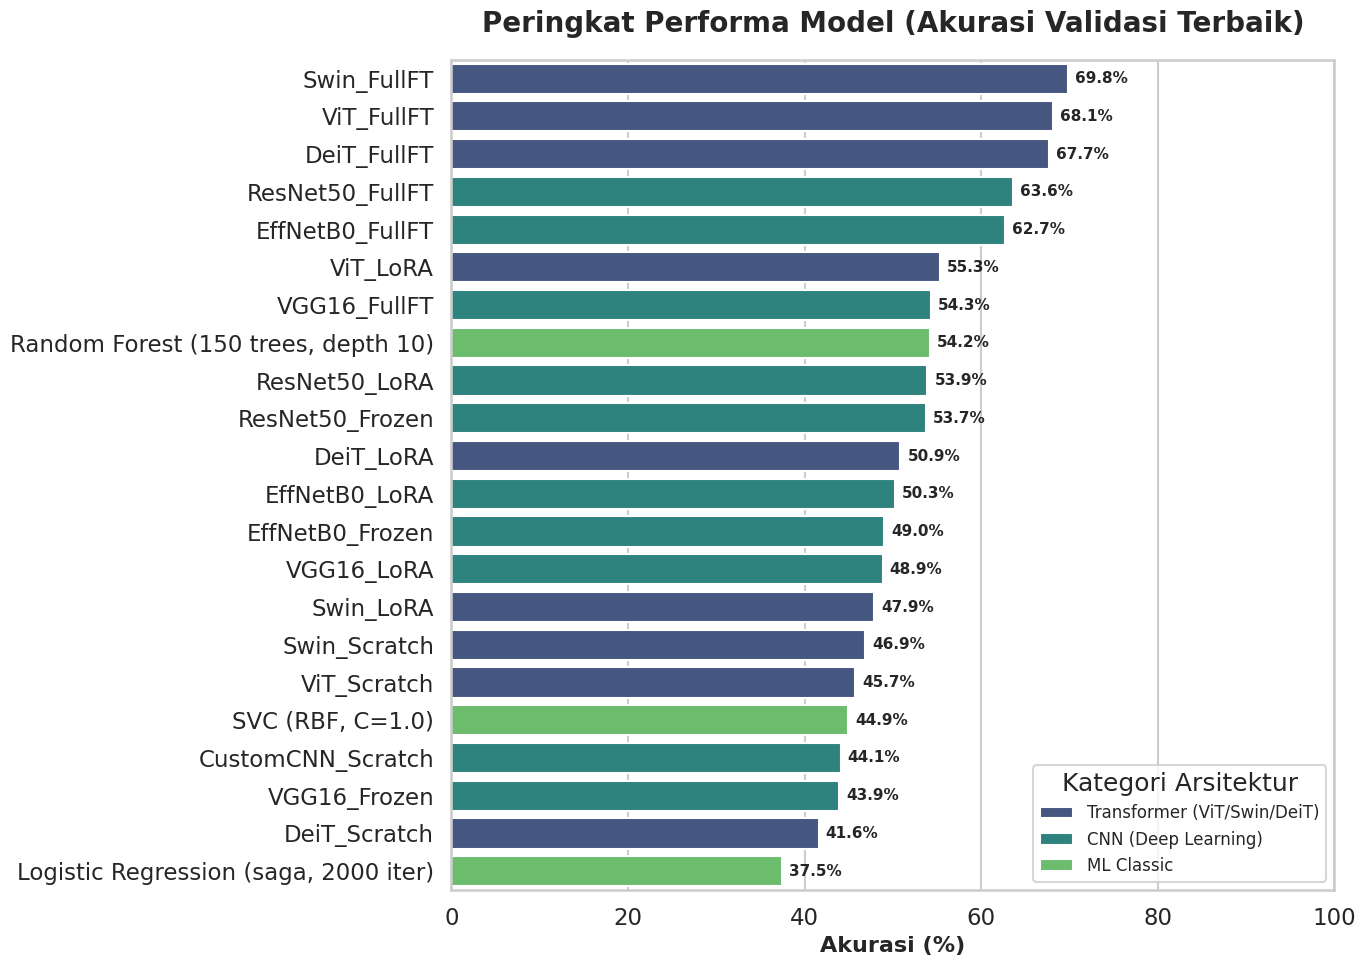

✅ Grafik (EN) disimpan: image/poster_grand_final_English.png


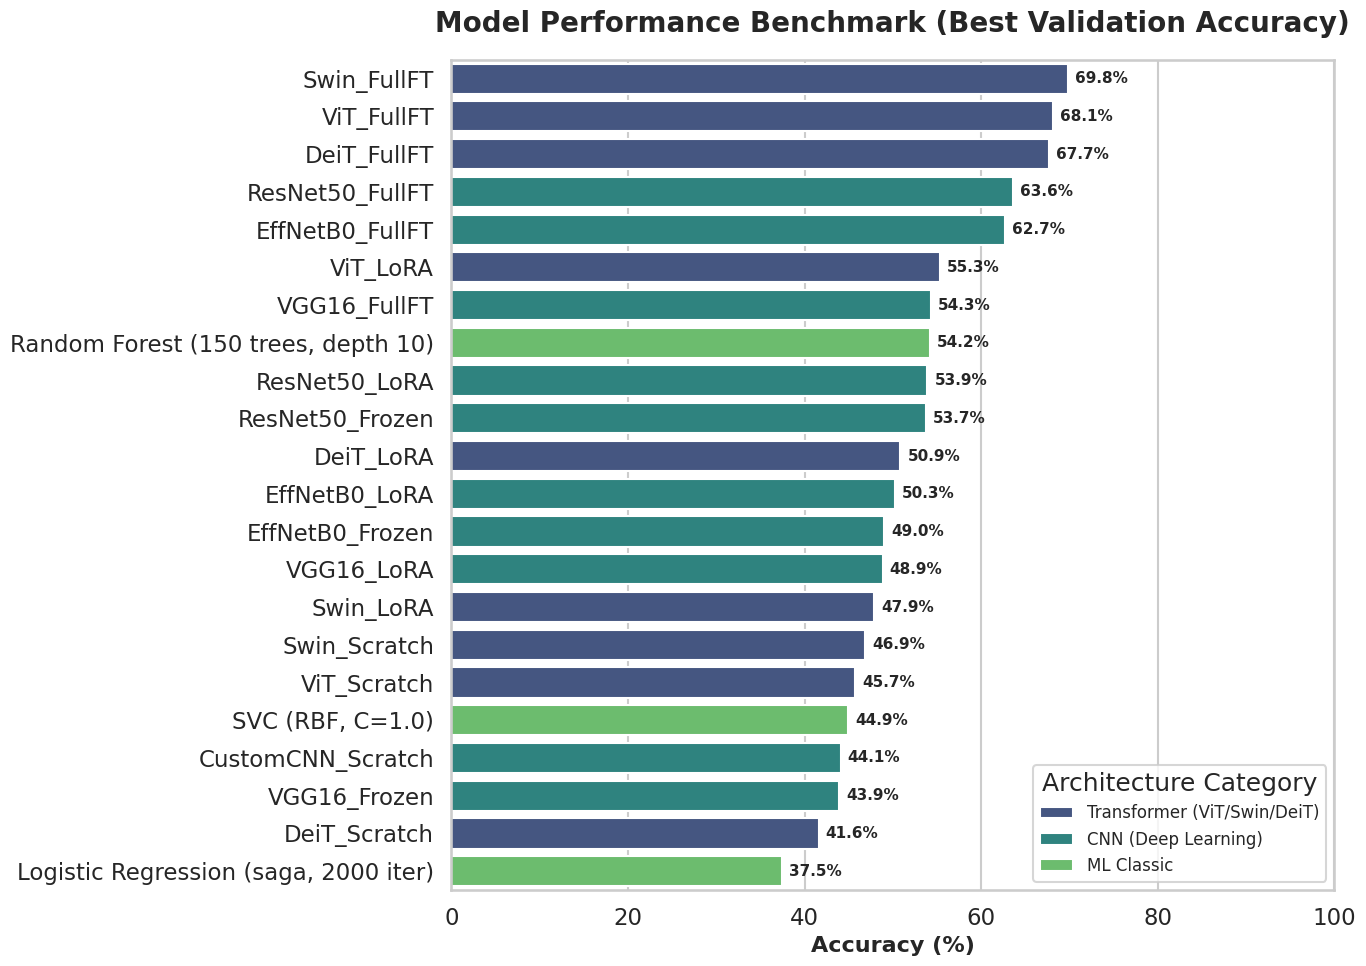


🏁 Selesai! Semua tabel dan gambar sudah siap di folder 'image/'.


In [59]:
# ==============================================================================
# GRAND FINAL VISUALIZATION: ML CLASSIC vs CNN vs TRANSFORMER (DUAL LANGUAGE)
# ==============================================================================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Set Style Profesional ala Jurnal/Poster
sns.set_theme(style="whitegrid", context="talk")

# --- 1. KUMPULKAN SEMUA DATA HASIL ---
dfs_to_concat = []

# A. Ambil Hasil ML Klasik
if 'results_list_weighted' in locals(): 
    dfs_to_concat.append(pd.DataFrame(results_list_weighted).assign(Kategori='ML Classic'))
elif 'results_list_smote' in locals(): 
    dfs_to_concat.append(pd.DataFrame(results_list_smote).assign(Kategori='ML Classic'))

# B. Ambil Hasil Deep Learning (CNN)
if 'history_dl' in locals():
    dl_results = []
    for name, hist in history_dl.items():
        if hist['val_acc']:
            best_acc = max(hist['val_acc'])
            dl_results.append({
                'Model': name,
                'Accuracy (%)': best_acc,
                'Kategori': 'CNN (Deep Learning)'
            })
    if dl_results:
        dfs_to_concat.append(pd.DataFrame(dl_results))

# C. Ambil Hasil Transformer
if 'history_vit' in locals():
    tr_results = []
    for name, hist in history_vit.items():
        if hist['val_acc']:
            best_acc = max(hist['val_acc'])
            tr_results.append({
                'Model': name,
                'Accuracy (%)': best_acc,
                'Kategori': 'Transformer (ViT/Swin/DeiT)'
            })
    if tr_results:
        dfs_to_concat.append(pd.DataFrame(tr_results))

# --- 2. PROSES & VISUALISASI ---
if dfs_to_concat:
    # Gabungkan semua data
    df_grand_final = pd.concat(dfs_to_concat, ignore_index=True)
    
    # Urutkan dari yang terbaik (Leaderboard)
    df_sorted = df_grand_final.sort_values(by="Accuracy (%)", ascending=False)
    
    # A. TAMPILKAN TABEL LEADERBOARD
    print("\n" + "="*80)
    print("🏆 GRAND FINAL LEADERBOARD: ACCURACY COMPARISON 🏆")
    print("="*80)
    # Tampilkan di output cell
    print(df_sorted[['Model', 'Kategori', 'Accuracy (%)']].to_markdown(index=False, floatfmt=".2f"))
    
    # Simpan ke CSV
    if not os.path.exists("image"): os.makedirs("image")
    csv_path = "image/poster_grand_final_results.csv"
    df_sorted.to_csv(csv_path, index=False)
    print(f"✅ Tabel hasil disimpan ke '{csv_path}'")

    # B. GENERATE GRAFIK DUAL BAHASA (Indo & English)
    print("\n🎨 Generating High-Res Poster Plots...")
    
    configs = [
        {
            "lang": "ID",
            "filename": "poster_grand_final_Indo.png",
            "title": "Peringkat Performa Model (Akurasi Validasi Terbaik)",
            "xlabel": "Akurasi (%)",
            "ylabel": "Model",
            "legend_title": "Kategori Arsitektur"
        },
        {
            "lang": "EN",
            "filename": "poster_grand_final_English.png",
            "title": "Model Performance Benchmark (Best Validation Accuracy)",
            "xlabel": "Accuracy (%)",
            "ylabel": "Model",
            "legend_title": "Architecture Category"
        }
    ]

    for config in configs:
        plt.figure(figsize=(14, 10)) # Canvas Besar
        
        ax = sns.barplot(
            data=df_sorted,
            x="Accuracy (%)", 
            y="Model", 
            hue="Kategori",
            dodge=False, 
            palette="viridis" # Warna gradasi modern
        )
        
        # Formatting Label & Judul Sesuai Bahasa
        plt.title(config['title'], fontsize=20, fontweight='bold', pad=20)
        plt.xlabel(config['xlabel'], fontsize=16, fontweight='bold')
        plt.ylabel("", fontsize=14)
        plt.xlim(0, 100)
        
        # Tambahkan Angka di Ujung Bar
        for container in ax.containers:
            ax.bar_label(container, fmt='%.1f%%', padding=5, fontsize=11, fontweight='bold')

        # Legenda
        plt.legend(title=config['legend_title'], loc='lower right', fontsize=12)
        
        plt.tight_layout()
        
        # Simpan Gambar
        save_path = os.path.join("image", config['filename'])
        plt.savefig(save_path, dpi=300)
        print(f"✅ Grafik ({config['lang']}) disimpan: {save_path}")
        
        # --- PERBAIKAN: TAMPILKAN GAMBAR DI OUTPUT ---
        plt.show() 
        
    print("\n🏁 Selesai! Semua tabel dan gambar sudah siap di folder 'image/'.")
    
else:
    print("❌ Data hasil tidak lengkap. Pastikan variable 'history_dl', 'history_vit', atau hasil ML Klasik tersedia.")

### Tabel Hasil & Bar Chart (The Main Result)

✅ Tabel hasil disimpan ke 'poster_table_results.csv'
                Model Category  Best Accuracy (%)  Final Loss
14        Swin_FullFT     Swin          69.847328    1.477068
11         ViT_FullFT      ViT          68.129771    1.355644
17        DeiT_FullFT     DeiT          67.748092    1.544644
2     ResNet50_FullFT      CNN          63.645038    2.109873
8     EffNetB0_FullFT     DeiT          62.690840    1.730057
12           ViT_LoRA      ViT          55.343511    1.972547
5        VGG16_FullFT      CNN          54.293893    1.827409
3       ResNet50_LoRA      CNN          53.912214    1.687296
1     ResNet50_Frozen      CNN          53.721374    1.920061
18          DeiT_LoRA     DeiT          50.858779    1.712315
9       EffNetB0_LoRA     DeiT          50.286260    1.702781
7     EffNetB0_Frozen     DeiT          49.045802    1.874240
6          VGG16_LoRA      CNN          48.854962    1.892345
15          Swin_LoRA     Swin          47.900763    1.774212
13       Swin_Scr

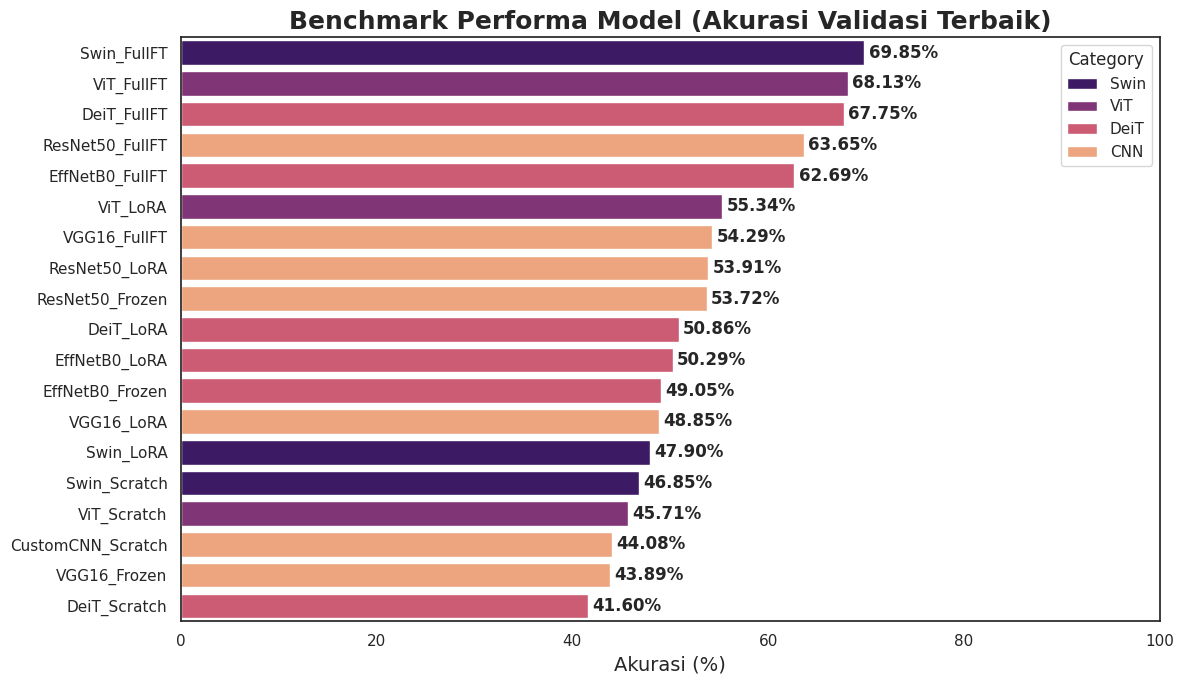

In [43]:
# ==============================================================================
# 3. AGREGASI HASIL & BENCHMARK PLOT (RESULT SECTION)
# ==============================================================================

def generate_results_summary(histories):
    results = []
    for name, hist in histories.items():
        if not hist['val_acc']: continue # Skip jika kosong
        
        # Ambil metrics dari epoch terakhir (atau max)
        best_acc = max(hist['val_acc'])
        final_loss = hist['val_loss'][-1]
        
        # Tentukan Kategori (CNN/ViT/Swin/DeiT)
        if "ResNet" in name or "VGG" in name or "Custom" in name:
            category = "CNN"
        elif "ViT" in name:
            category = "ViT"
        elif "Swin" in name:
            category = "Swin"
        else:
            category = "DeiT"
            
        results.append({
            "Model": name,
            "Category": category,
            "Best Accuracy (%)": best_acc,
            "Final Loss": final_loss
        })
        
    return pd.DataFrame(results).sort_values(by="Best Accuracy (%)", ascending=False)

# 1. Buat DataFrame
df_results = generate_results_summary(all_history)

# 2. Simpan Tabel ke CSV (Bisa dicopy ke Excel untuk poster)
df_results.to_csv("poster_table_results.csv", index=False)
print("✅ Tabel hasil disimpan ke 'poster_table_results.csv'")
print(df_results)

# 3. Plot Bar Chart Komparasi
plt.figure(figsize=(12, 7))
sns.set_style("white") # Background putih bersih untuk poster

# Plot
bar_plot = sns.barplot(data=df_results, x="Best Accuracy (%)", y="Model", hue="Category", dodge=False, palette="magma")

# Tambahkan angka di ujung bar
for container in bar_plot.containers:
    bar_plot.bar_label(container, fmt='%.2f%%', padding=3, fontweight='bold')

plt.title("Benchmark Performa Model (Akurasi Validasi Terbaik)", fontsize=18, fontweight='bold')
plt.xlabel("Akurasi (%)", fontsize=14)
plt.ylabel("", fontsize=14)
plt.xlim(0, 100) # Skala 0-100

plt.tight_layout()
plt.savefig("image/poster_fig3_benchmark.png", dpi=300)
print("✅ Gambar disimpan: poster_fig3_benchmark.png")
plt.show()

### Confusion Matrix (Qualitative Analysis)

In [42]:
# ==============================================================================
# 4. VISUALISASI CONFUSION MATRIX (ALL MODELS - DUAL LANGUAGE)
# ==============================================================================
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import os
import numpy as np

def get_preds_from_model(model, loader, device):
    """Helper function untuk mendapatkan prediksi dari model PyTorch"""
    model.to(device)
    model.eval()
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    return all_labels, all_preds

def plot_confusion_matrix_dual(y_true, y_pred, class_names, model_name, output_folder="image"):
    """Fungsi plotting Confusion Matrix dengan 2 bahasa"""
    
    # Hitung Matrix Sekali Saja
    cm = confusion_matrix(y_true, y_pred)
    
    # Konfigurasi Bahasa
    configs = [
        {
            "lang": "ID",
            "filename": f"CM_{model_name}_Indo.png",
            "title": f"Confusion Matrix: {model_name}",
            "xlabel": "Prediksi Model",
            "ylabel": "Label Sebenarnya (Ground Truth)"
        },
        {
            "lang": "EN",
            "filename": f"CM_{model_name}_English.png",
            "title": f"Confusion Matrix: {model_name}",
            "xlabel": "Predicted Label",
            "ylabel": "True Label"
        }
    ]
    
    for config in configs:
        plt.figure(figsize=(10, 8)) # Ukuran canvas
        sns.set(font_scale=1.0)
        
        # Gunakan Heatmap Seaborn agar lebih cantik & customizable
        sns.heatmap(
            cm, 
            annot=True, 
            fmt='d', # Format integer
            cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names,
            cbar=False,
            square=True
        )
        
        plt.title(config['title'], fontsize=16, fontweight='bold', pad=15)
        plt.xlabel(config['xlabel'], fontsize=13, fontweight='bold')
        plt.ylabel(config['ylabel'], fontsize=13, fontweight='bold')
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        
        plt.tight_layout()
        
        # Simpan
        if not os.path.exists(output_folder): os.makedirs(output_folder)
        save_path = os.path.join(output_folder, config['filename'])
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.close() # Tutup plot agar memori tidak penuh
        
    print(f"✅ CM Disimpan: {model_name} (ID & EN)")

# ==============================================================================
# EKSEKUSI OTOMATIS UNTUK SEMUA MODEL
# ==============================================================================

print("\n🎨 Generating Confusion Matrices for ALL Models...")
print("="*60)

# 1. Pastikan Class Names Tersedia
if 'DIAGNOSIS_COLUMNS' in locals():
    class_names = DIAGNOSIS_COLUMNS
else:
    # Fallback dummy jika variabel hilang
    class_names = [f"Class {i}" for i in range(NUM_CLASSES)]

# 2. Loop Model Deep Learning (CNN)
if 'models_to_train_dl' in locals():
    for name, model in models_to_train_dl.items():
        print(f"⏳ Processing CNN: {name}...")
        # Gunakan val_loader (Standard CNN)
        y_true, y_pred = get_preds_from_model(model, val_loader, DEVICE)
        plot_confusion_matrix_dual(y_true, y_pred, class_names, name)

# 3. Loop Model Transformer (ViT/Swin/DeiT)
if 'models_to_train_vit' in locals():
    for name, model in models_to_train_vit.items():
        print(f"⏳ Processing Transformer: {name}...")
        # Gunakan val_loader_vit (Khusus Transformer)
        y_true, y_pred = get_preds_from_model(model, val_loader_vit, DEVICE)
        plot_confusion_matrix_dual(y_true, y_pred, class_names, name)

print("\n🏁 Selesai! Semua Confusion Matrix tersimpan di folder 'image/'.")


🎨 Generating Confusion Matrices for ALL Models...
⏳ Processing CNN: CustomCNN_Scratch...
✅ CM Disimpan: CustomCNN_Scratch (ID & EN)
⏳ Processing CNN: ResNet50_Frozen...
✅ CM Disimpan: ResNet50_Frozen (ID & EN)
⏳ Processing CNN: ResNet50_FullFT...
✅ CM Disimpan: ResNet50_FullFT (ID & EN)
⏳ Processing CNN: ResNet50_LoRA...
✅ CM Disimpan: ResNet50_LoRA (ID & EN)
⏳ Processing CNN: VGG16_Frozen...
✅ CM Disimpan: VGG16_Frozen (ID & EN)
⏳ Processing CNN: VGG16_FullFT...
✅ CM Disimpan: VGG16_FullFT (ID & EN)
⏳ Processing CNN: VGG16_LoRA...
✅ CM Disimpan: VGG16_LoRA (ID & EN)
⏳ Processing CNN: EffNetB0_Frozen...
✅ CM Disimpan: EffNetB0_Frozen (ID & EN)
⏳ Processing CNN: EffNetB0_FullFT...
✅ CM Disimpan: EffNetB0_FullFT (ID & EN)
⏳ Processing CNN: EffNetB0_LoRA...
✅ CM Disimpan: EffNetB0_LoRA (ID & EN)
⏳ Processing Transformer: ViT_Scratch...
✅ CM Disimpan: ViT_Scratch (ID & EN)
⏳ Processing Transformer: ViT_FullFT...
✅ CM Disimpan: ViT_FullFT (ID & EN)
⏳ Processing Transformer: ViT_LoRA...
✅ C

### Efficiency Analysis

In [37]:
# ==============================================================================
# EFFICIENCY ANALYSIS: PARAMETER COUNTING & VISUALIZATION
# ==============================================================================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def get_model_efficiency_metrics(model_dict):
    metrics = []
    
    for name, model in model_dict.items():
        # Hitung Total Parameter
        total_params = sum(p.numel() for p in model.parameters())
        
        # Hitung Trainable Parameter (Yang dilatih)
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        
        # Hitung % Penghematan
        ratio = (trainable_params / total_params) * 100
        
        # Tentukan Kategori & Strategi dari nama
        if "LoRA" in name: strategy = "LoRA"
        elif "Frozen" in name: strategy = "Frozen"
        elif "Scratch" in name: strategy = "Scratch"
        else: strategy = "Full FT"
            
        if "ViT" in name or "Swin" in name or "DeiT" in name:
            arch_type = "Transformer"
        else:
            arch_type = "CNN"
            
        metrics.append({
            "Model Name": name,
            "Architecture Type": arch_type,
            "Strategy": strategy,
            "Total Parameters": total_params,
            "Trainable Parameters": trainable_params,
            "Trainable Ratio (%)": ratio,
            "Params (Millions)": total_params / 1e6
        })
        
    return metrics

# 1. Kumpulkan semua model (Pastikan variabel dictionary model masih ada di memori)
# Jika memory error, jalankan analisis ini terpisah untuk CNN dan ViT
all_models_dict = {}

if 'models_to_train_dl' in locals():
    all_models_dict.update(models_to_train_dl)
    
if 'models_to_train_vit' in locals():
    all_models_dict.update(models_to_train_vit)

if not all_models_dict:
    print("⚠️ Peringatan: Tidak ada model ditemukan di memori.")
    print("   Harap jalankan sel 'Setup Dictionary Eksperimen' (setup_dl/vit) terlebih dahulu (tanpa training).")
else:
    # 2. Buat DataFrame
    efficiency_data = get_model_efficiency_metrics(all_models_dict)
    df_eff = pd.DataFrame(efficiency_data)

    # Urutkan agar rapi
    df_eff = df_eff.sort_values(by=["Architecture Type", "Total Parameters"], ascending=False)
    
    # Simpan ke CSV untuk Poster
    df_eff.to_csv("poster_table_efficiency.csv", index=False)
    
    # Tampilkan Tabel
    print("📊 Tabel Efisiensi Model (Disimpan ke 'poster_table_efficiency.csv'):")
    display(df_eff[['Model Name', 'Strategy', 'Total Parameters', 'Trainable Parameters', 'Trainable Ratio (%)']])

📊 Tabel Efisiensi Model (Disimpan ke 'poster_table_efficiency.csv'):


Model Name Strategy  Total Parameters  Trainable Parameters  \
18          DeiT_LoRA     LoRA          86406934                598283   
12           ViT_LoRA     LoRA          86405398                598283   
16       DeiT_Scratch  Scratch          85808651              85808651   
17        DeiT_FullFT  Full FT          85808651              85808651   
10        ViT_Scratch  Scratch          85807115              85807115   
11         ViT_FullFT  Full FT          85807115              85807115   
15          Swin_LoRA     LoRA          27818896                291083   
13       Swin_Scratch  Scratch          27527813              27527813   
14        Swin_FullFT  Full FT          27527813              27527813   
6          VGG16_LoRA     LoRA         134514518                208907   
4        VGG16_Frozen   Frozen         134305611                 45067   
5        VGG16_FullFT  Full FT         134305611             134305611   
3       ResNet50_LoRA     LoRA          23706710                176139   
1     ResNet50_Frozen   Frozen          23530571                 22539   
2     ResNet50_FullFT  Full FT          23530571              23530571   
9       EffNetB0_LoRA     LoRA           4066194                 44555   
7     EffNetB0_Frozen   Frozen           4021639                 14091   
8     EffNetB0_FullFT  Full FT           4021639               4021639   
0   CustomCNN_Scratch  Scratch            129547                129547   

    Trainable Ratio (%)  
18             0.692402  
12             0.692414  
16           100.000000  
17           100.000000  
10           100.000000  
11           100.000000  
15             1.046350  
13           100.000000  
14           100.000000  
6              0.155304  
4              0.033556  
5            100.000000  
3              0.742992  
1              0.095786  
2            100.000000  
9              1.095742  
7              0.350380  
8            100.000000  
0            100.000000

In [47]:
# ==============================================================================
# TAMPILKAN & SIMPAN SEMUA HASIL (LENGKAP)
# ==============================================================================
import pandas as pd

# 1. Pastikan DataFrame hasil akhir sudah ada
if 'df_results_final' in locals():
    # Atur agar pandas menampilkan semua baris (tidak dipotong '...')
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_colwidth', None)
    
    # 2. Tampilkan di Layar (Urut berdasarkan Akurasi Tertinggi)
    print("\n" + "="*80)
    print(f"📋 DAFTAR LENGKAP SEMUA MODEL ({len(df_results_final)} Model)")
    print("="*80)
    
    # Tampilkan kolom penting saja agar rapi
    print(df_results_final[['Model', 'Category', 'Accuracy (%)']].to_markdown(index=False, floatfmt=".2f"))
    
    # 3. Simpan ke CSV (Versi Lengkap)
    filename_csv = "image/all_model_results.csv"
    df_results_final.to_csv(filename_csv, index=False)
    print(f"\n✅ File CSV Lengkap disimpan ke: '{filename_csv}'")
    
    # Reset option pandas ke default (agar tidak memenuhi layar di cell lain)
    pd.reset_option('display.max_rows')
else:
    print("❌ Variabel 'df_results_final' belum terbentuk. Jalankan langkah 'Agregasi Hasil' sebelumnya.")


📋 DAFTAR LENGKAP SEMUA MODEL (22 Model)
| Model                                 | Category           |   Accuracy (%) |
|:--------------------------------------|:-------------------|---------------:|
| Swin_FullFT                           | Transformer (Swin) |          69.85 |
| ViT_FullFT                            | Transformer (ViT)  |          68.13 |
| DeiT_FullFT                           | Transformer (DeiT) |          67.75 |
| ResNet50_FullFT                       | CNN (ResNet)       |          63.65 |
| EffNetB0_FullFT                       | CNN (EfficientNet) |          62.69 |
| ViT_LoRA                              | Transformer (ViT)  |          55.34 |
| VGG16_FullFT                          | CNN (VGG)          |          54.29 |
| Random Forest (150 trees, depth 10)   | Classic ML         |          54.20 |
| ResNet50_LoRA                         | CNN (ResNet)       |          53.91 |
| ResNet50_Frozen                       | CNN (ResNet)       |          53.72 |

In [54]:
# ==============================================================================
# VISUALISASI EFISIENSI (CLEAN - TANPA ML KLASIK)
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd
import numpy as np

def plot_efficiency_visuals_clean(df_eff, df_acc, output_folder="image"):
    if df_eff.empty:
        print("⚠️ Data efisiensi kosong.")
        return
    if df_acc.empty:
        print("⚠️ Data akurasi (df_results_final) kosong.")
        return

    if not os.path.exists(output_folder): os.makedirs(output_folder)

    # --------------------------------------------------------------------------
    # A. BAR CHART: TRAINABLE PARAMETERS (LOG SCALE)
    # --------------------------------------------------------------------------
    subset = df_eff[df_eff['Strategy'].isin(['Full FT', 'LoRA', 'Scratch'])].copy()
    
    configs_bar = [
        {
            "lang": "ID", "filename": "Fig5_Efisiensi_Parameter_Indo.png",
            "title": "Efisiensi Komputasi: Perbandingan Jumlah Parameter",
            "xlabel": "Jumlah Parameter yang Dilatih (Skala Log)", "ylabel": "Model",
            "legend": "Strategi Pelatihan"
        },
        {
            "lang": "EN", "filename": "Fig5_Parameter_Efficiency_English.png",
            "title": "Computational Efficiency: Trainable Parameter Comparison",
            "xlabel": "Trainable Parameters (Log Scale)", "ylabel": "Model",
            "legend": "Training Strategy"
        }
    ]

    for config in configs_bar:
        plt.figure(figsize=(12, 10))
        sns.set_style("whitegrid")
        
        ax = sns.barplot(
            data=subset, 
            y="Model Name", 
            x="Trainable Parameters", 
            hue="Strategy",
            palette={"Full FT": "#1D3557", "LoRA": "#E63946", "Scratch": "#457B9D"}
        )
        
        plt.xscale('log') 
        plt.title(config['title'], fontsize=16, fontweight='bold', pad=15)
        plt.xlabel(config['xlabel'], fontsize=14, fontweight='bold')
        plt.ylabel(config['ylabel'], fontsize=14, fontweight='bold')
        plt.legend(title=config['legend'], loc="lower right")
        
        for container in ax.containers:
            labels = []
            for val in container.datavalues:
                if val >= 1e6: txt = f'{val/1e6:.1f}M'
                elif val >= 1e3: txt = f'{val/1e3:.0f}K'
                else: txt = f'{val:.0f}'
                labels.append(txt)
            ax.bar_label(container, labels=labels, padding=5, fontsize=9, fontweight='bold')

        plt.tight_layout()
        save_path = os.path.join(output_folder, config['filename'])
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✅ Grafik Bar Efisiensi disimpan: {save_path}")
        plt.close()

    # --------------------------------------------------------------------------
    # B. SCATTER PLOT: ACCURACY vs PARAMETERS (Deep Learning Only)
    # --------------------------------------------------------------------------
    df_scatter = pd.merge(df_eff, df_acc[['Model', 'Accuracy (%)']], 
                          left_on='Model Name', right_on='Model', how='inner')
        
    if not df_scatter.empty:
        configs_scatter = [
            {
                "lang": "ID", "filename": "Fig6_TradeOff_Akurasi_vs_Param_Indo.png",
                "title": "Trade-off: Akurasi vs Efisiensi Parameter",
                "xlabel": "Total Parameter Model (Jutaan)", "ylabel": "Akurasi Validasi (%)",
                "size_legend": "Parameter Dilatih"
            },
            {
                "lang": "EN", "filename": "Fig6_Accuracy_vs_Params_English.png",
                "title": "Trade-off Analysis: Accuracy vs Parameter Efficiency",
                "xlabel": "Total Model Parameters (Millions)", "ylabel": "Validation Accuracy (%)",
                "size_legend": "Trainable Params"
            }
        ]
        
        for config in configs_scatter:
            plt.figure(figsize=(11, 8))
            sns.set_style("whitegrid")
            
            # PLOT TITIK DEEP LEARNING & TRANSFORMER
            sns.scatterplot(
                data=df_scatter,
                x="Params (Millions)",
                y="Accuracy (%)",
                hue="Architecture Type", 
                style="Strategy",        
                size="Trainable Ratio (%)", 
                sizes=(50, 500),
                palette="viridis",
                alpha=0.8,
                edgecolor="black"
            )
            
            # (BAGIAN ML KLASIK TELAH DIHAPUS SEPENUHNYA)

            # Label Nama Model
            avg_acc = df_scatter['Accuracy (%)'].mean()
            for i in range(df_scatter.shape[0]):
                row = df_scatter.iloc[i]
                if row['Accuracy (%)'] > avg_acc or "LoRA" in row['Model Name']: 
                    plt.text(
                        row['Params (Millions)']+0.5, 
                        row['Accuracy (%)']+0.2, 
                        row['Model Name'].replace("ResNet50", "ResNet").replace("EfficientNetB0", "EffNet"), 
                        fontsize=9, 
                        alpha=0.8,
                        weight='bold'
                    )

            plt.title(config['title'], fontsize=16, fontweight='bold', pad=15)
            plt.xlabel(config['xlabel'], fontsize=14, fontweight='bold')
            plt.ylabel(config['ylabel'], fontsize=14, fontweight='bold')
            
            plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)
            
            plt.tight_layout()
            save_path = os.path.join(output_folder, config['filename'])
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"✅ Grafik Scatter Trade-off disimpan: {save_path}")
            plt.close()
    else:
        print("⚠️ Tidak ada data Deep Learning yang cocok untuk Scatter Plot.")

# --- EKSEKUSI ---
if 'df_eff' in locals() and 'df_results_final' in locals():
    plot_efficiency_visuals_clean(df_eff, df_results_final)
else:
    print("❌ Variabel df_eff atau df_results_final tidak ditemukan.")

✅ Grafik Bar Efisiensi disimpan: image/Fig5_Efisiensi_Parameter_Indo.png
✅ Grafik Bar Efisiensi disimpan: image/Fig5_Parameter_Efficiency_English.png
✅ Grafik Scatter Trade-off disimpan: image/Fig6_TradeOff_Akurasi_vs_Param_Indo.png
✅ Grafik Scatter Trade-off disimpan: image/Fig6_Accuracy_vs_Params_English.png


📂 Menampilkan gambar dari folder 'image/':

🖼️  Fig5_Efisiensi_Parameter_Indo.png


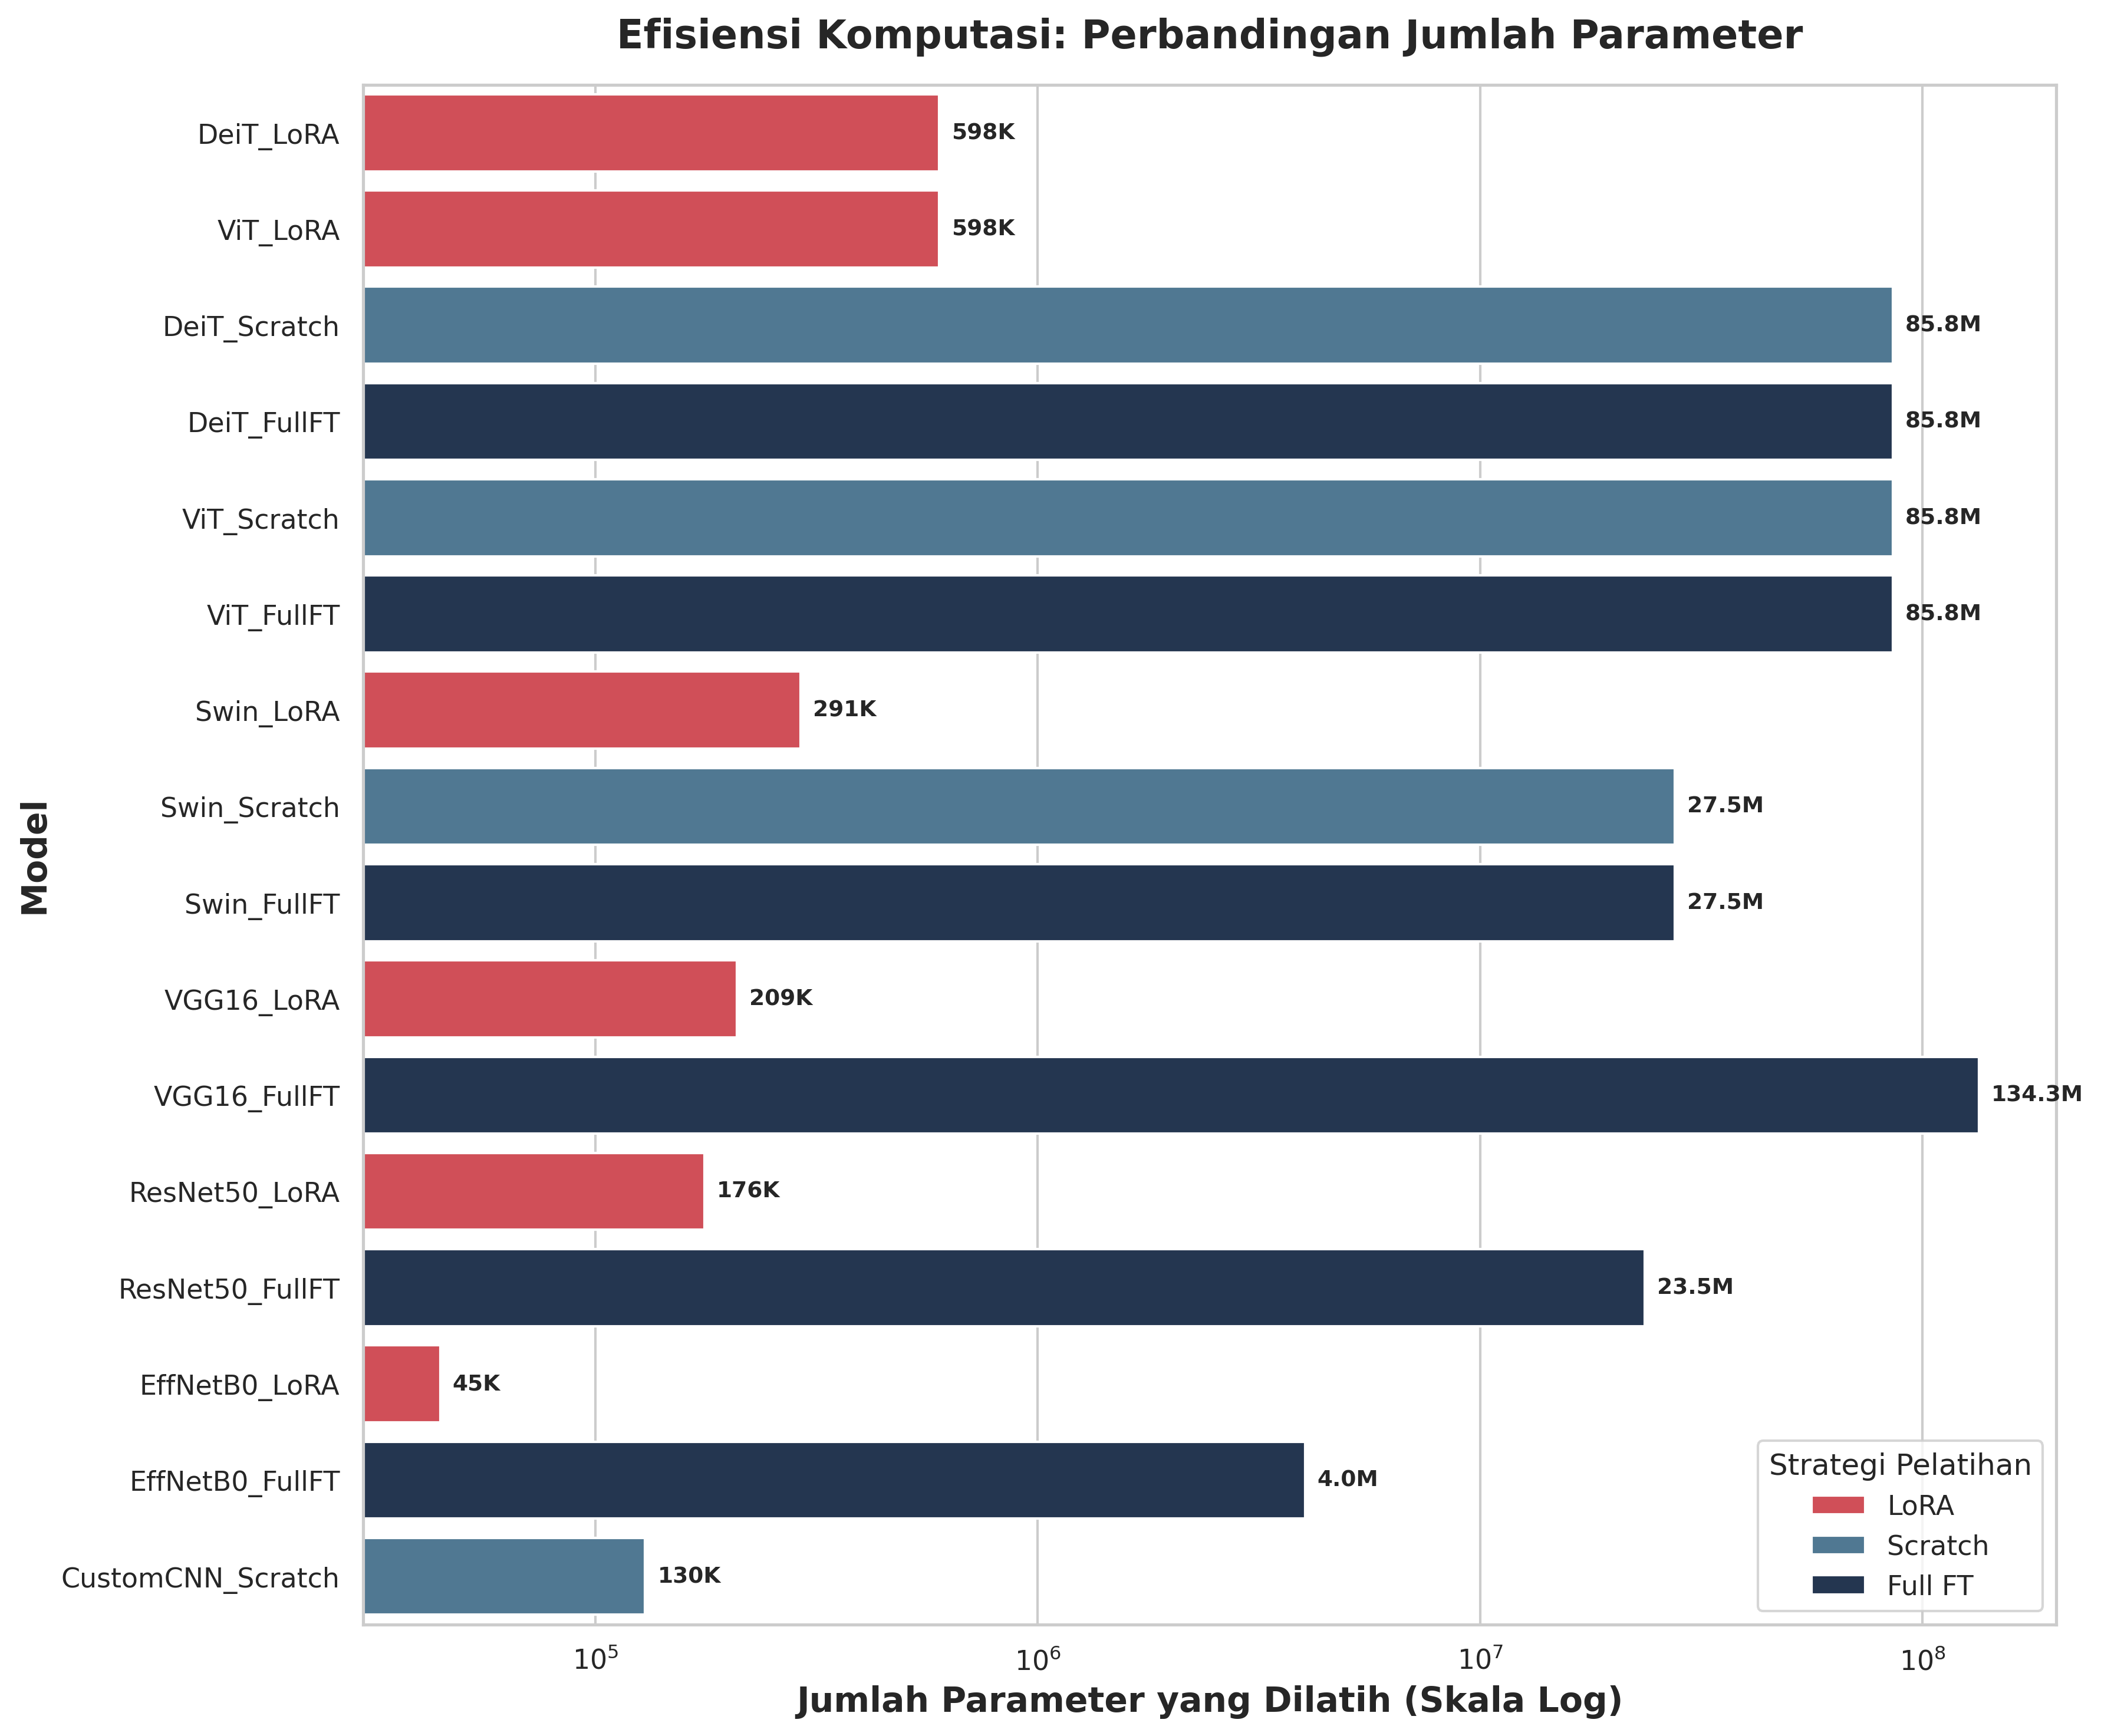

--------------------------------------------------------------------------------

🖼️  Fig5_Parameter_Efficiency_English.png


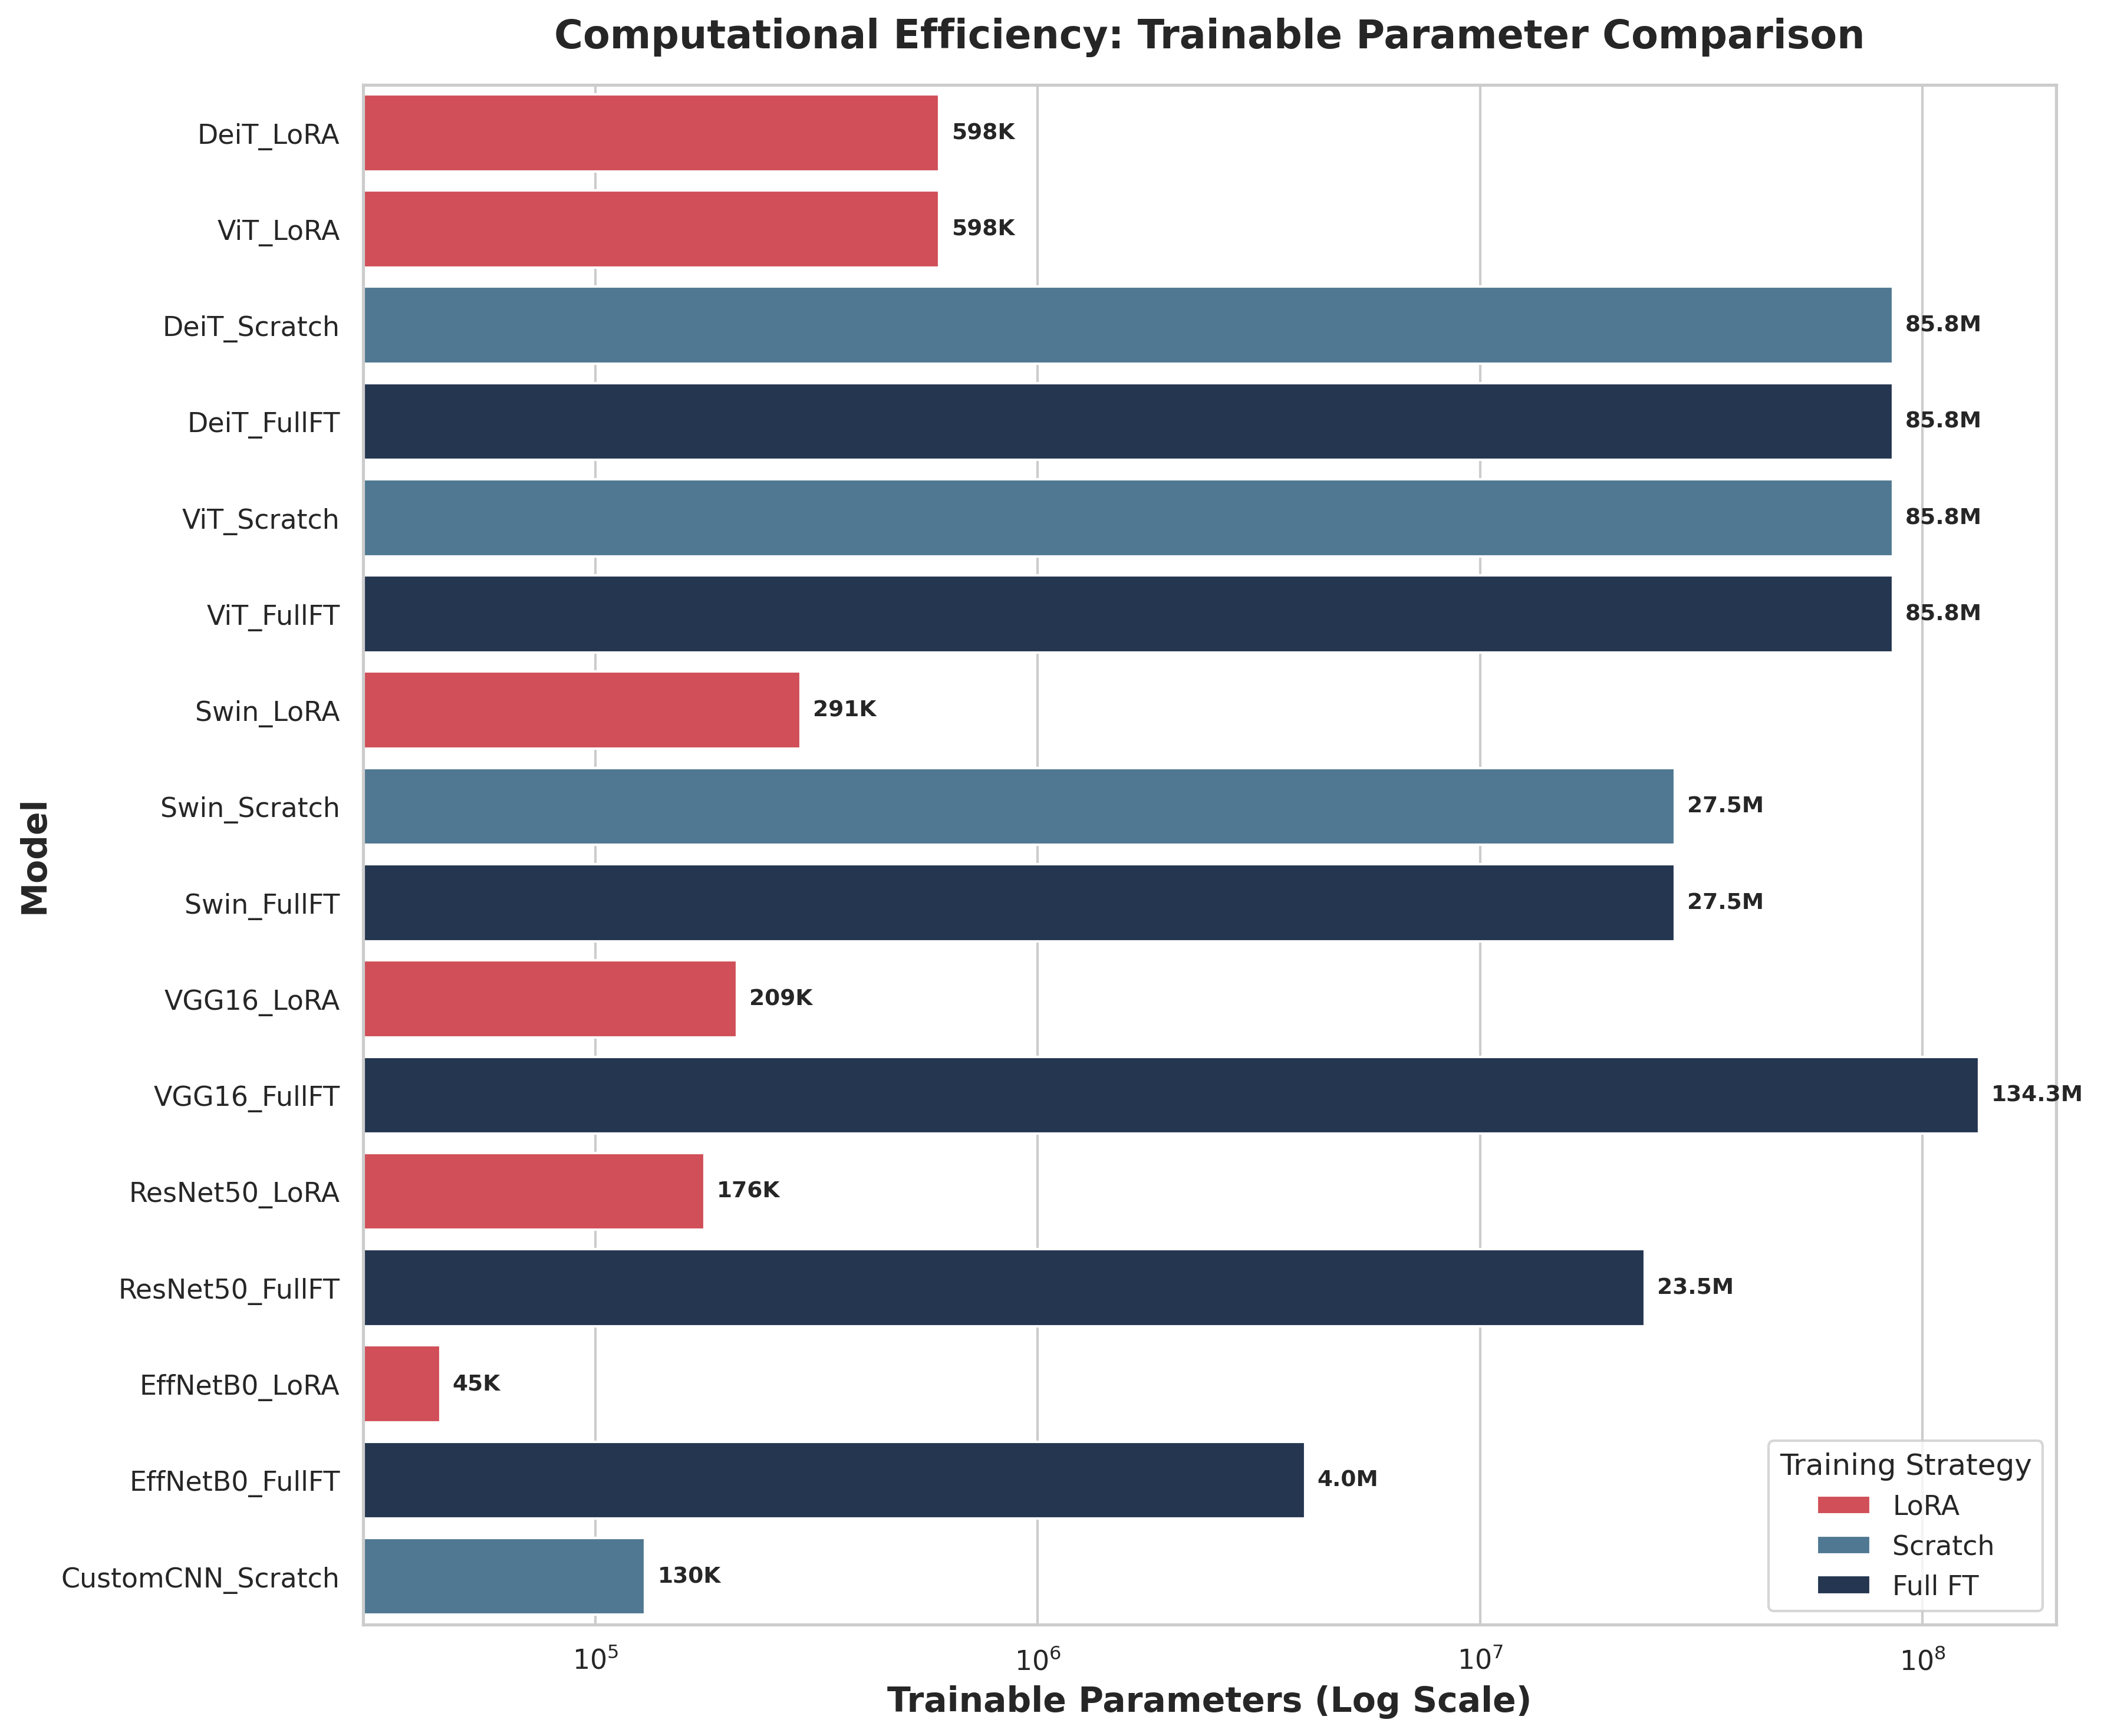

--------------------------------------------------------------------------------

🖼️  Fig6_TradeOff_Akurasi_vs_Param_Indo.png


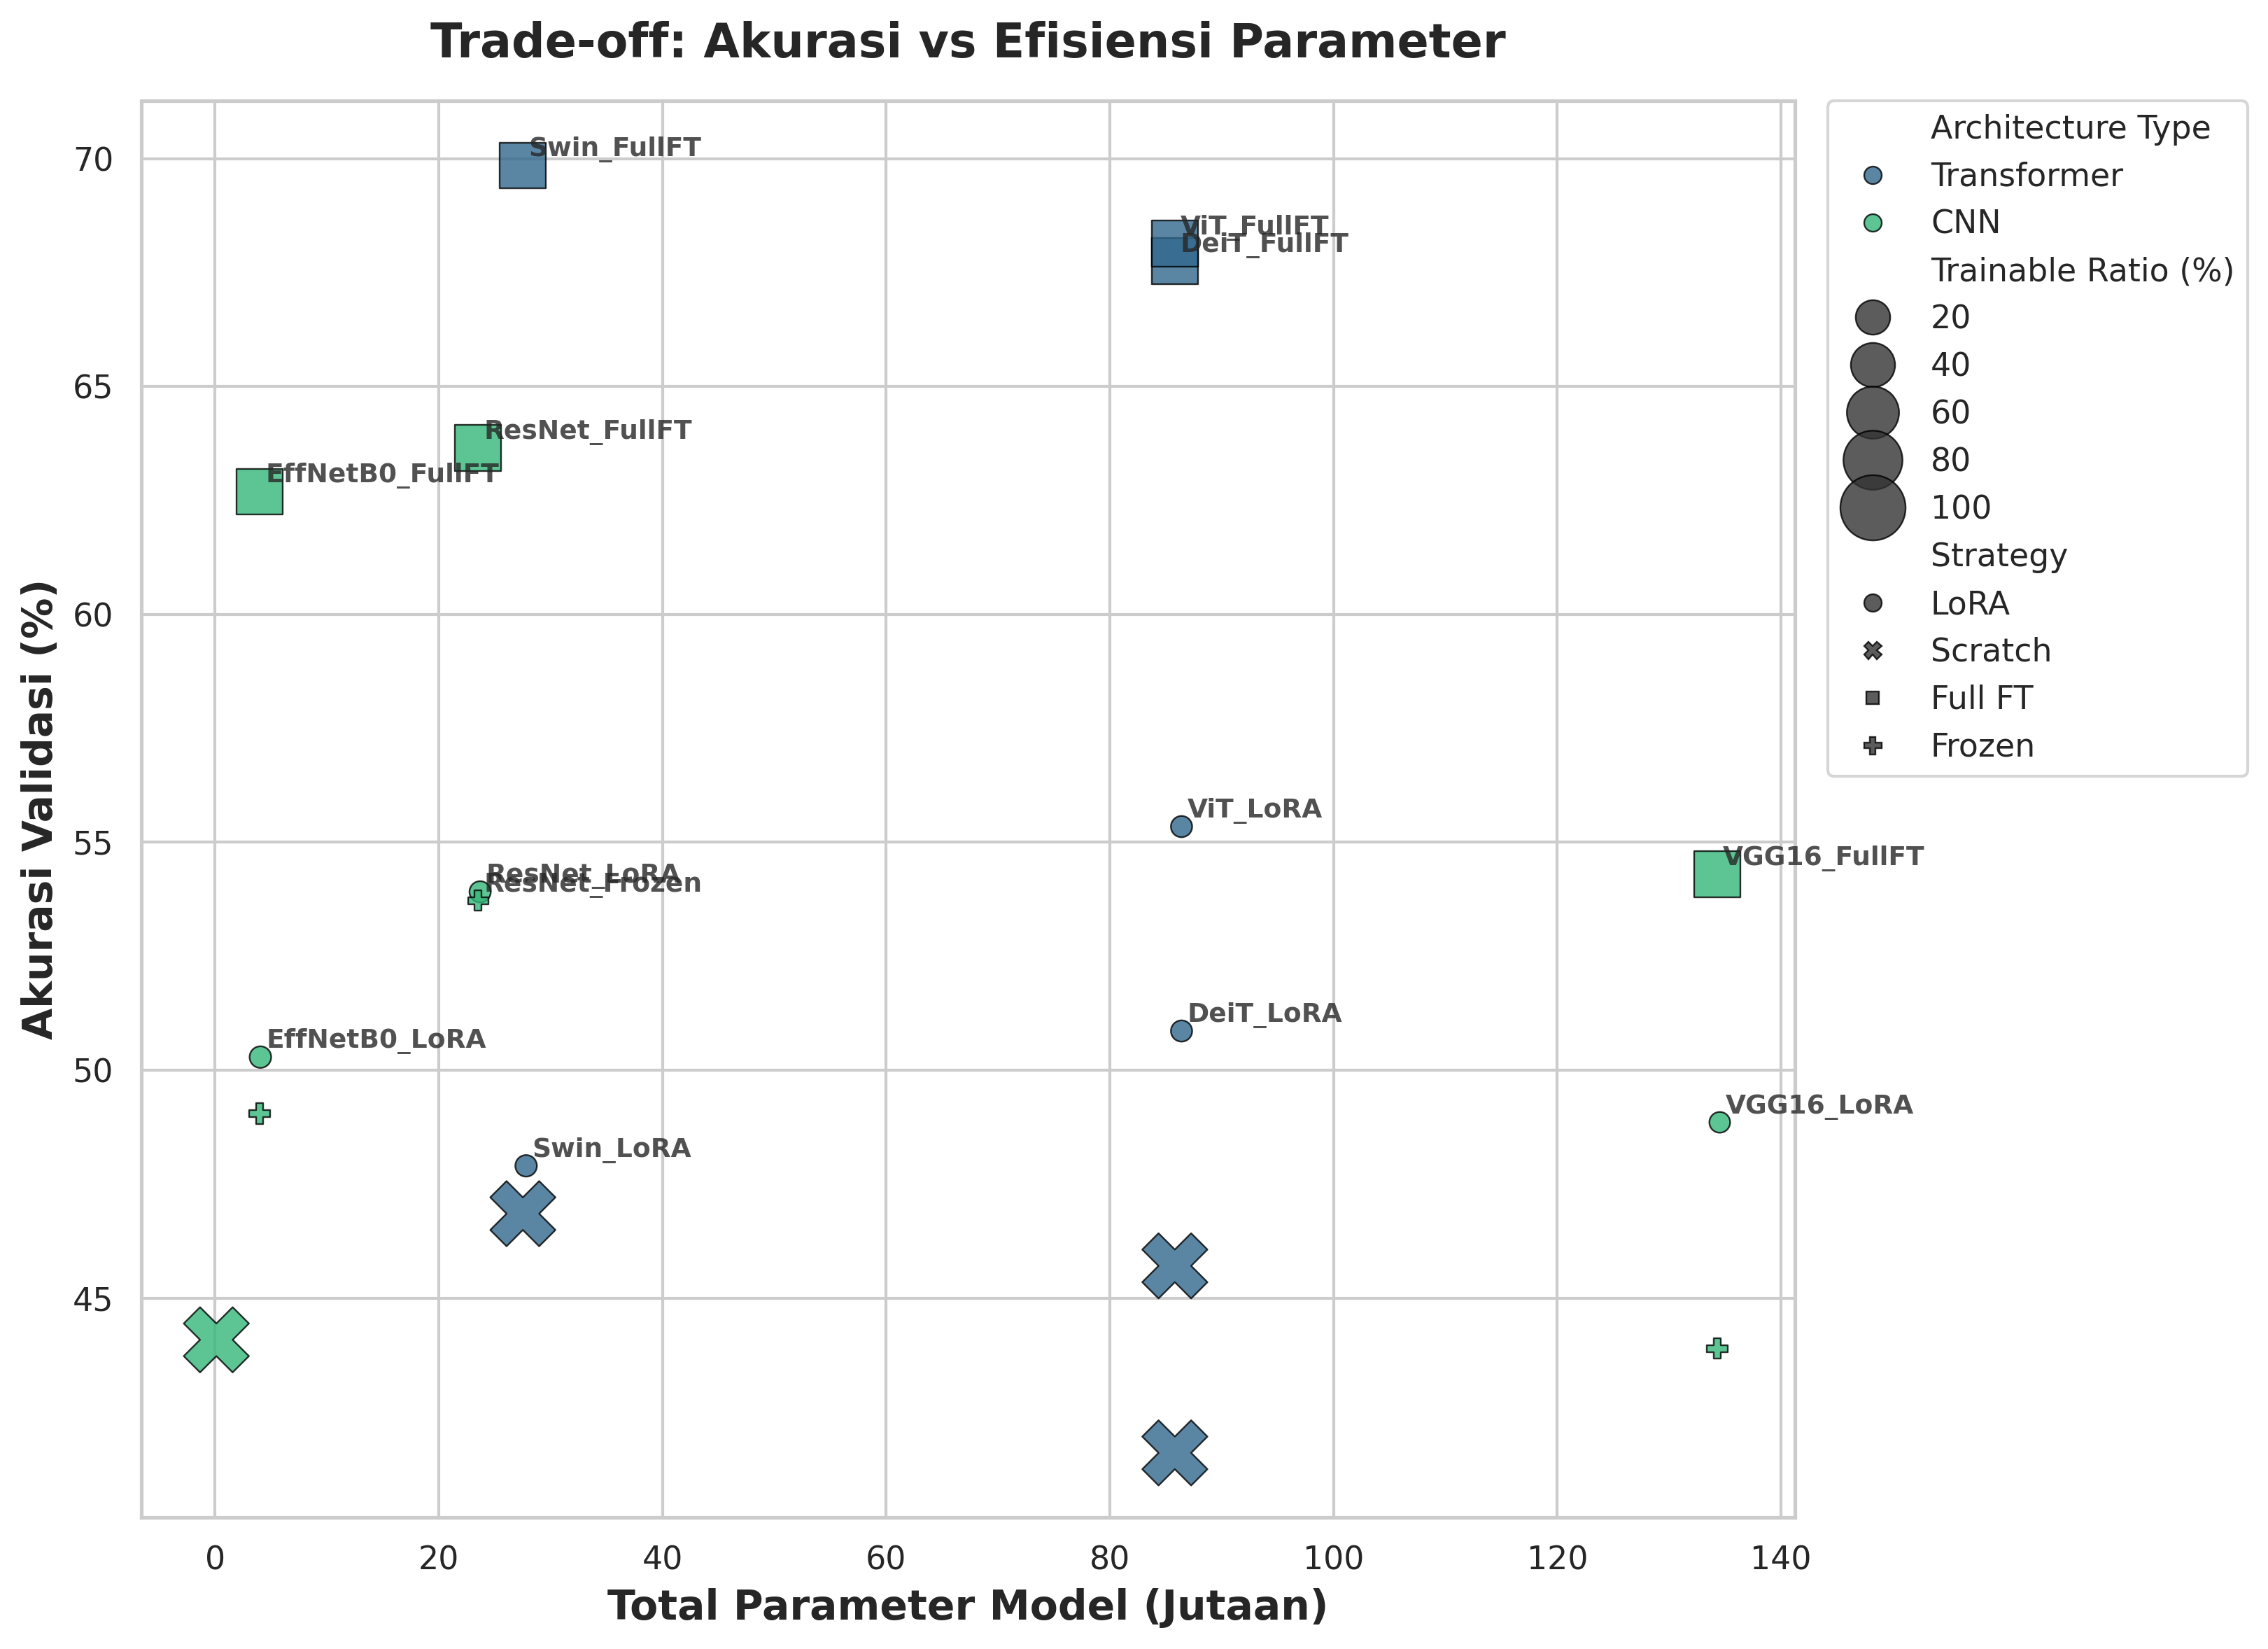

--------------------------------------------------------------------------------

🖼️  Fig6_Accuracy_vs_Params_English.png


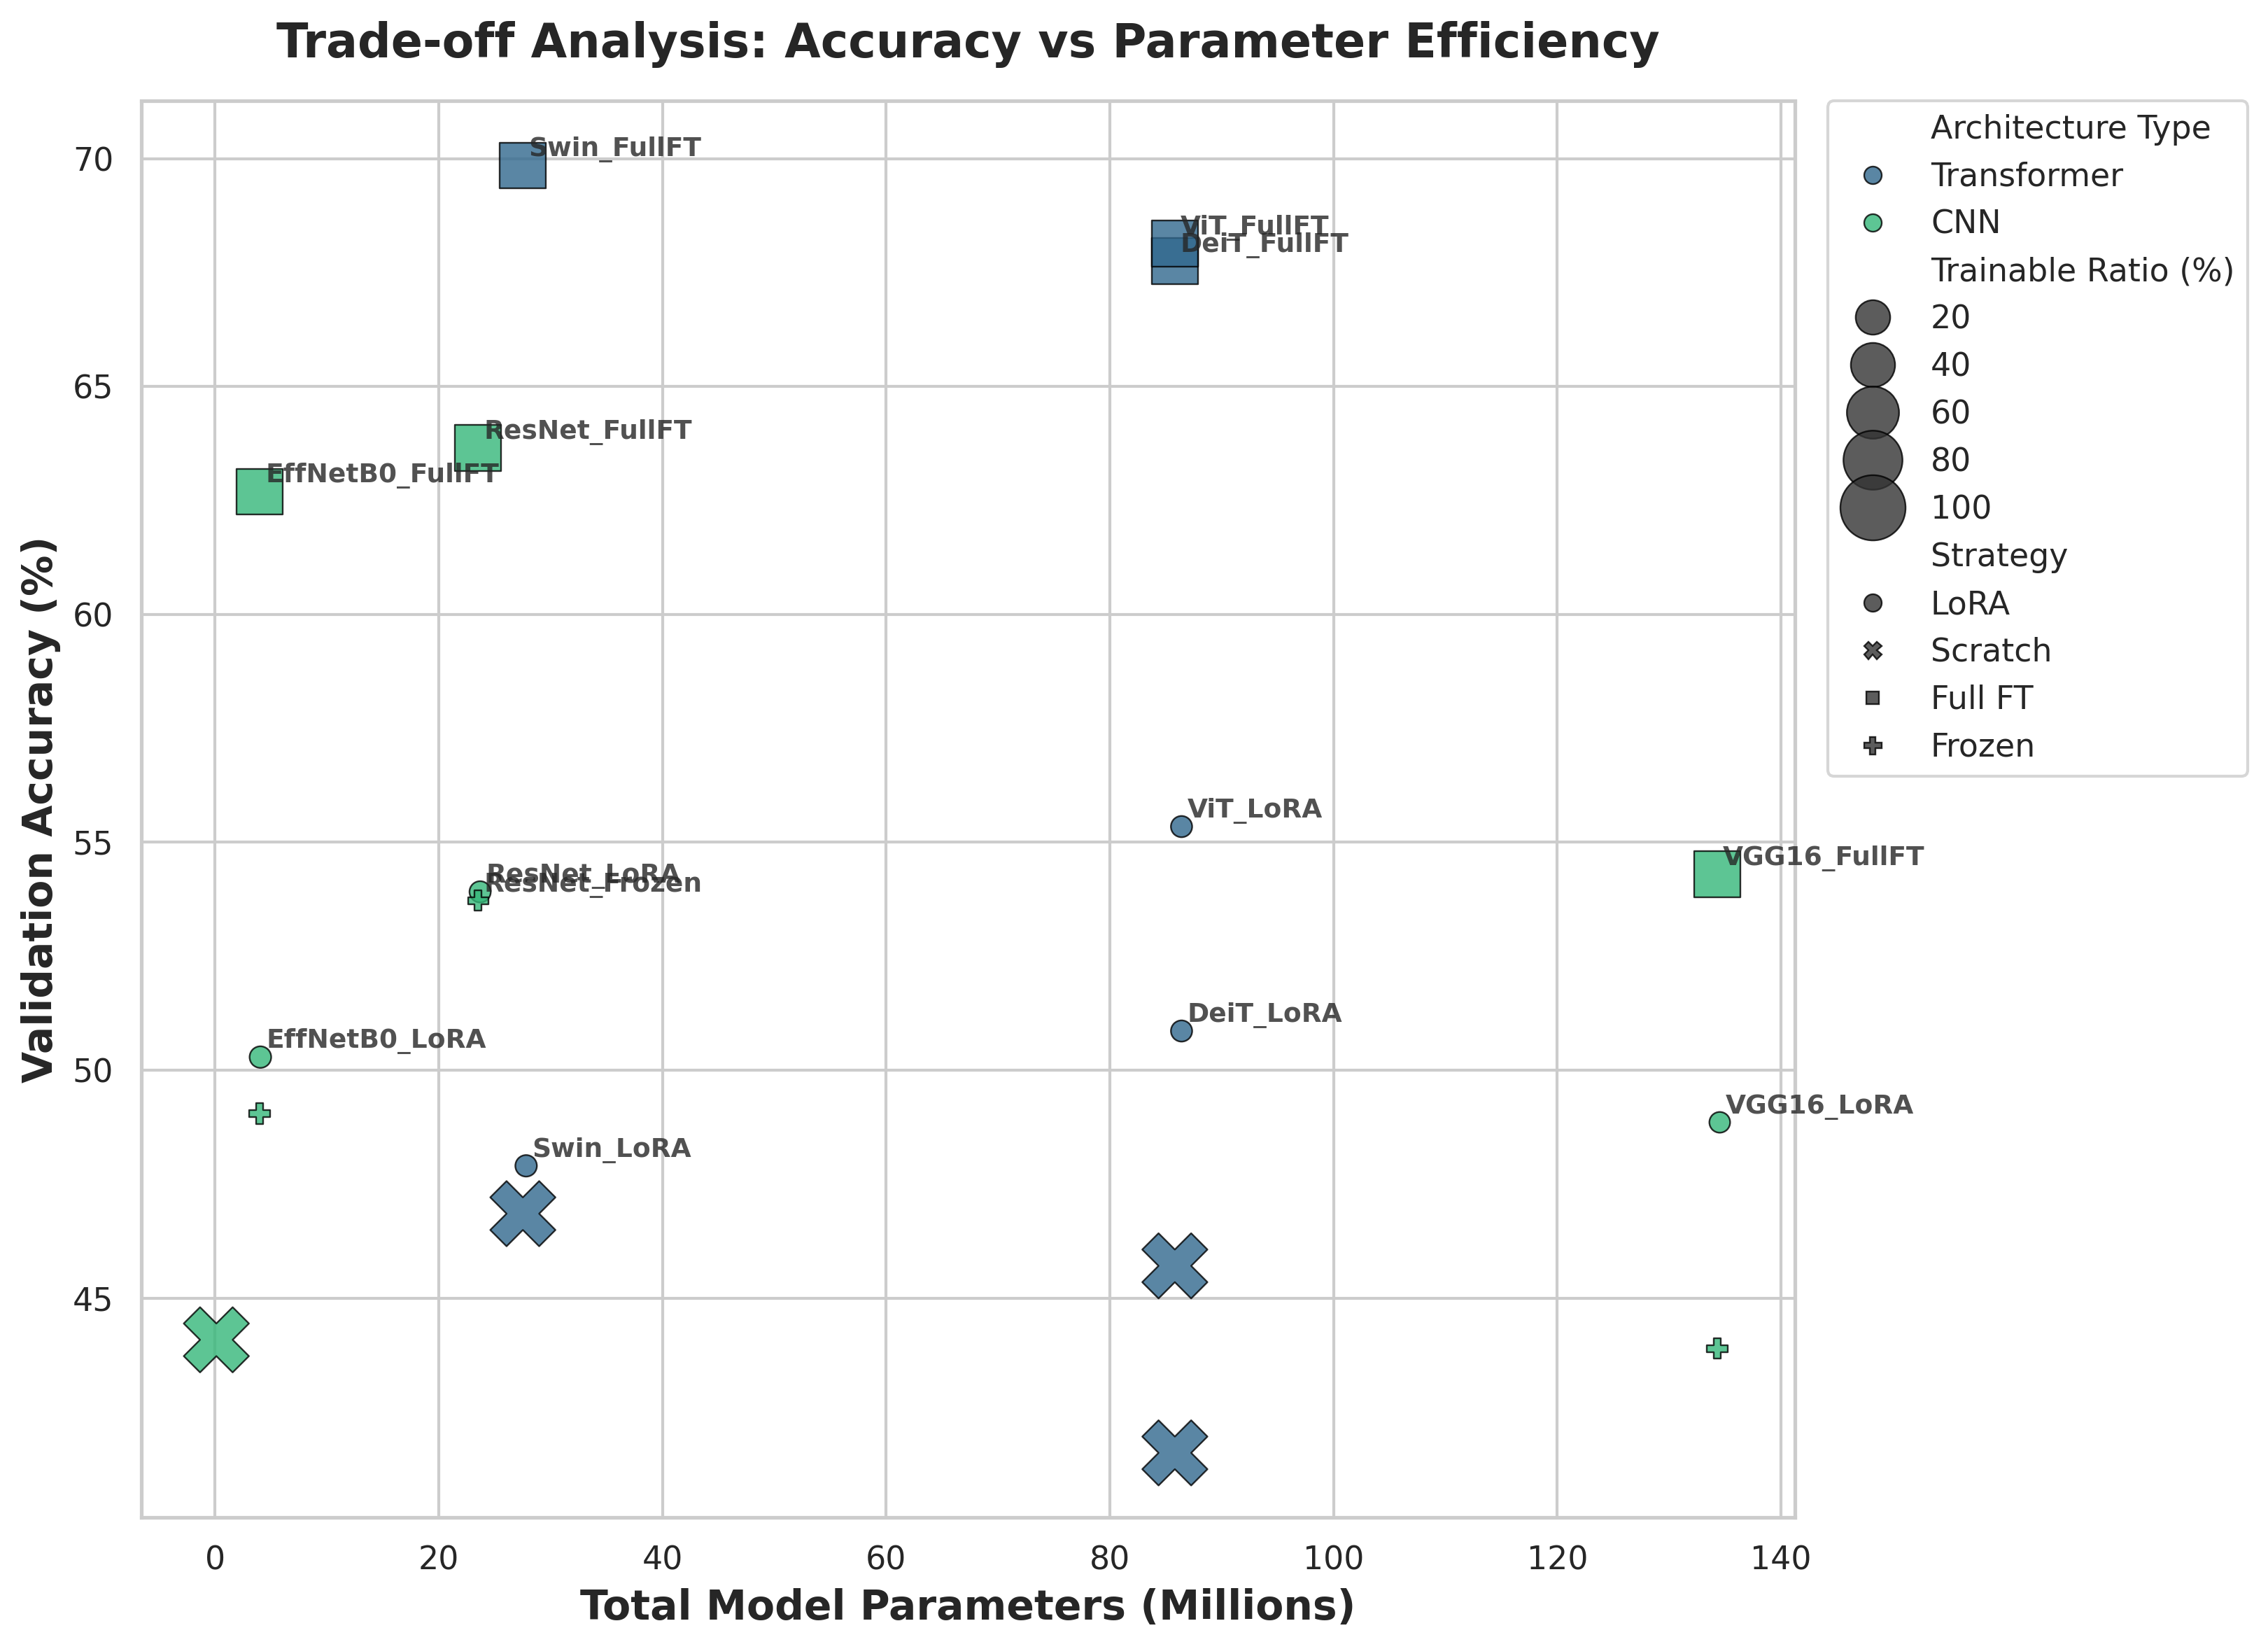

--------------------------------------------------------------------------------



In [55]:
# ==============================================================================
# TAMPILKAN GAMBAR HASIL ANALISIS EFISIENSI
# ==============================================================================
from IPython.display import display, Image
import os

def show_saved_images(filenames, folder="image"):
    print(f"📂 Menampilkan gambar dari folder '{folder}/':\n")
    
    for fname in filenames:
        path = os.path.join(folder, fname)
        if os.path.exists(path):
            print(f"🖼️  {fname}")
            display(Image(filename=path, width=800)) # Tampilkan gambar lebar 800px
            print("-" * 80 + "\n")
        else:
            print(f"⚠️  File tidak ditemukan: {fname}\n")

# Daftar file yang dihasilkan dari kode sebelumnya
target_images = [
    # Grafik Bar Chart (Efisiensi Parameter)
    "Fig5_Efisiensi_Parameter_Indo.png",
    "Fig5_Parameter_Efficiency_English.png",
    
    # Grafik Scatter Plot (Trade-off Akurasi)
    "Fig6_TradeOff_Akurasi_vs_Param_Indo.png",
    "Fig6_Accuracy_vs_Params_English.png"
]

# Eksekusi
show_saved_images(target_images)